In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.append('../')
import Hybrid_nn
import torch
from torch import nn
import data
import pennylane as qml
import embedding

# 1. Load Test data for distance measurements

In [2]:
feature_reduction = 'PCA8'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', '2', feature_reduction=feature_reduction, classes=classes)
X1_test, X0_test = [], []
for i in range(len(X_test)):
    if Y_test[i] == 1:
        X1_test.append(X_test[i])
    else:
        X0_test.append(X_test[i])
X1_test, X0_test = torch.tensor(X1_test), torch.tensor(X0_test)

2022-12-06 14:56:25.993119: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/g3/xz_ycw3d0qdd8s4r2rdd6m940000gn/T/ipykernel_27519/399496202.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646991213/work/torch/csrc/utils/tensor_new.cpp:233.)
  X1_test, X0_test = torch.tensor(X1_test), torch.tensor(X0_test)


# 1. Trace Distance before training the quantum circuit

In [32]:
dev = qml.device('default.qubit', wires=8)

@qml.qnode(dev, interface="torch")
def distance_circuit1(inputs): 
    embedding.QuantumEmbedding1(inputs[0:8])
    return qml.density_matrix(wires=range(8))

class Distance(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer1_distance = qml.qnn.TorchLayer(distance_circuit1, weight_shapes={})
    
    def forward(self, x1, x0, measure):
        rhos1 = self.qlayer1_distance(x1)
        rhos0 = self.qlayer1_distance(x0)
        rho1 = torch.sum(rhos1, dim=0) / len(x1)
        rho0 = torch.sum(rhos0, dim=0) / len(x0)
        rho_diff = rho1 - rho0

        if measure == "Trace":
            eigvals = torch.linalg.eigvals(rho_diff)
            return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))
        elif measure == "Hilbert-Schmidt":
            return 0.5 * torch.real(torch.trace(rho_diff @ rho_diff))
        

D = Distance()
D_trace = D(X1_test, X0_test, "Trace")
D_HS = D(X1_test, X0_test, "Hilbert-Schmidt")
print(f"Trace Distance before: {D_trace}\n")
print(f"Hilbert Schmidt distance before: {D_HS}")

Trace Distance before: 0.35613536834716797

Hilbert Schmidt distance before: 0.0024180735927075148


# 2.1. Model1 with Fidelity

In [3]:
loss_history1 = np.array([0.5320174098014832, 0.46896642446517944, 0.4524284899234772, 0.36133113503456116, 0.28939342498779297, 0.4100181460380554, 0.4882064759731293, 0.4370163679122925, 0.2862531840801239, 0.4545011520385742, 0.5269883871078491, 0.2882140576839447, 0.39746299386024475, 0.47208327054977417, 0.3669015169143677, 0.4232816696166992, 0.32996344566345215, 0.33577340841293335, 0.4961149990558624, 0.3968241810798645, 0.2108333557844162, 0.3917687237262726, 0.231553316116333, 0.2918131649494171, 0.33560627698898315, 0.3333889842033386, 0.369953453540802, 0.4282498061656952, 0.4384094476699829, 0.39573919773101807, 0.30761757493019104, 0.4728486239910126, 0.3516088128089905, 0.4247584939002991, 0.2621266841888428, 0.3109436631202698, 0.2566045820713043, 0.22877107560634613, 0.392619252204895, 0.34593069553375244, 0.2677442729473114, 0.32728496193885803, 0.2767339050769806, 0.28945764899253845, 0.3079056441783905, 0.2170683741569519, 0.27346259355545044, 0.24126972258090973, 0.12052538245916367, 0.37514978647232056, 0.19829069077968597, 0.3185077905654907, 0.24242940545082092, 0.16263963282108307, 0.26064762473106384, 0.2763039469718933, 0.23495392501354218, 0.21183302998542786, 0.12970930337905884, 0.34164953231811523, 0.24512293934822083, 0.16071483492851257, 0.2730134427547455, 0.2273779958486557, 0.16936412453651428, 0.09268520027399063, 0.22486251592636108, 0.19112323224544525, 0.1467021256685257, 0.11125551164150238, 0.17807166278362274, 0.1839016079902649, 0.12229802459478378, 0.11830803751945496, 0.15699386596679688, 0.19206781685352325, 0.18655143678188324, 0.12699352204799652, 0.12200672179460526, 0.11872947216033936, 0.17094138264656067, 0.16860072314739227, 0.12579786777496338, 0.1685272604227066, 0.22943033277988434, 0.1730591505765915, 0.09421321749687195, 0.07402298599481583, 0.0879874899983406, 0.15284748375415802, 0.1252228021621704, 0.16269366443157196, 0.10065451264381409, 0.19371233880519867, 0.11539638042449951, 0.08556827157735825, 0.11779863387346268, 0.09903779625892639, 0.16967250406742096, 0.20228968560695648, 0.18569369614124298, 0.10456012189388275, 0.1519879549741745, 0.14094297587871552, 0.13071005046367645, 0.10359571129083633, 0.14025673270225525, 0.056880734860897064, 0.16236566007137299, 0.08038518577814102, 0.12212720513343811, 0.13294778764247894, 0.08942656964063644, 0.14548411965370178, 0.10658516734838486, 0.0723300501704216, 0.07289662957191467, 0.13039261102676392, 0.08242011070251465, 0.08346929401159286, 0.13364113867282867, 0.06851958483457565, 0.08545608073472977, 0.07610258460044861, 0.25346997380256653, 0.08516554534435272, 0.13509470224380493, 0.08640217781066895, 0.0946572795510292, 0.10936792194843292, 0.10705549269914627, 0.14623862504959106, 0.19512327015399933, 0.03274081274867058, 0.10136755555868149, 0.04758249595761299, 0.07868430018424988, 0.06632665544748306, 0.052855730056762695, 0.04828094318509102, 0.10662460327148438, 0.06481875479221344, 0.036809083074331284, 0.1163797527551651, 0.02065597102046013, 0.05775339901447296, 0.0992017537355423, 0.12916213274002075, 0.09507005661725998, 0.037677276879549026, 0.06911250203847885, 0.027385327965021133, 0.04413921758532524, 0.031774938106536865, 0.0532941035926342, 0.04680895060300827, 0.05860358476638794, 0.041664283722639084, 0.06018778309226036, 0.057313840836286545, 0.07271058112382889, 0.04054013267159462, 0.0258956141769886, 0.0723087415099144, 0.07513365894556046, 0.03722919523715973, 0.04844340309500694, 0.042082518339157104, 0.14363019168376923, 0.08355233818292618, 0.05562831833958626, 0.03787029907107353, 0.06845592707395554, 0.032936520874500275, 0.033584244549274445, 0.03678756207227707, 0.0316988080739975, 0.017945190891623497, 0.1627994179725647, 0.05833164229989052, 0.03086322918534279, 0.04040167108178139, 0.0967121422290802, 0.020085010677576065, 0.06609923392534256, 0.047243423759937286, 0.02664264105260372, 0.11294368654489517, 0.03804345428943634, 0.03992494195699692, 0.03885223716497421, 0.1250377744436264, 0.03505455702543259, 0.03480939194560051, 0.056544817984104156, 0.04760989174246788, 0.0368083193898201, 0.04310816526412964, 0.05996975675225258, 0.03681166097521782, 0.05525568872690201, 0.060117267072200775, 0.04399289935827255, 0.017612669616937637, 0.03836991637945175, 0.033882252871990204, 0.02799898572266102, 0.04034166783094406, 0.06907550990581512, 0.03757065534591675, 0.027867550030350685, 0.03890841826796532, 0.01957930624485016, 0.02507627010345459, 0.05782807990908623, 0.0472831130027771, 0.02418416179716587, 0.03222218528389931, 0.04290297254920006, 0.041347019374370575, 0.018175814300775528, 0.07427560538053513, 0.018544495105743408, 0.02931191213428974, 0.04632283002138138, 0.029069360345602036, 0.024167869240045547, 0.0156971774995327, 0.08236388117074966, 0.04607090353965759, 0.04439445212483406, 0.07611078023910522, 0.07122797518968582, 0.045861855149269104, 0.08553832769393921, 0.029480205848813057, 0.07090403139591217, 0.03582482412457466, 0.049295395612716675, 0.05805585905909538, 0.05195029079914093, 0.046601686626672745, 0.08766710013151169, 0.03736213967204094, 0.08398132771253586, 0.07791516184806824, 0.08039254695177078, 0.009771066717803478, 0.02541985735297203, 0.06196146830916405, 0.07713552564382553, 0.03743800148367882, 0.009588627144694328, 0.03625333681702614, 0.03752746805548668, 0.06628799438476562, 0.04855639487504959, 0.03568105772137642, 0.07276996225118637, 0.038785018026828766, 0.027271214872598648, 0.041573550552129745, 0.04132505878806114, 0.007940802723169327, 0.13094958662986755, 0.01929529197514057, 0.05544477701187134, 0.011332675814628601, 0.06527106463909149, 0.04209693893790245, 0.08034897595643997, 0.04693189635872841, 0.05991475284099579, 0.03425217419862747, 0.00819473247975111, 0.0581076554954052, 0.0316963754594326, 0.02805548906326294, 0.028677958995103836, 0.06184632331132889, 0.014575500041246414, 0.05650411173701286, 0.0328584648668766, 0.0185431856662035, 0.05600997433066368, 0.01654156669974327, 0.07116822153329849, 0.023038377985358238, 0.015637749806046486, 0.018175367265939713, 0.07068075239658356, 0.039314813911914825, 0.013062657788395882, 0.037032078951597214, 0.014285425655543804, 0.03576216474175453, 0.01723494380712509, 0.038559556007385254, 0.05308137834072113, 0.07683209329843521, 0.021381337195634842, 0.012857364490628242, 0.04503684863448143, 0.055193882435560226, 0.07495446503162384, 0.008887588046491146, 0.02042579837143421, 0.055287521332502365, 0.013465703465044498, 0.008030697703361511, 0.04970133304595947, 0.0301731675863266, 0.020517297089099884, 0.056305497884750366, 0.010771091096103191, 0.03634271398186684, 0.06257966160774231, 0.02449558675289154, 0.052774447947740555, 0.021699333563447, 0.0626731663942337, 0.08389750123023987, 0.07637424021959305, 0.012082395143806934, 0.05526864901185036, 0.008425160311162472, 0.017934463918209076, 0.041958265006542206, 0.05827490612864494, 0.053879816085100174, 0.05659781023859978, 0.059049900621175766, 0.06242672726511955, 0.025030888617038727, 0.016289934515953064, 0.029136458411812782, 0.03735429793596268, 0.009098141454160213, 0.008333033882081509, 0.04454340040683746, 0.024296659976243973, 0.008821657858788967, 0.08555437624454498, 0.016184043139219284, 0.0717664286494255, 0.040967751294374466, 0.040729932487010956, 0.022139599546790123, 0.03497033193707466, 0.040172796696424484, 0.013654591515660286, 0.07117541879415512, 0.030055560171604156, 0.09281068295240402, 0.032014213502407074, 0.007182045839726925, 0.06606365740299225, 0.05344879627227783, 0.07357782125473022, 0.03171975538134575, 0.013784618116915226, 0.009328557178378105, 0.0496225543320179, 0.013569783419370651, 0.05289238318800926, 0.03296965733170509, 0.04544688016176224, 0.007138795219361782, 0.02725653164088726, 0.020231477916240692, 0.011709456332027912, 0.01334922295063734, 0.03530324995517731, 0.005980732385069132, 0.07741634547710419, 0.04856641963124275, 0.01559496484696865, 0.007823975756764412, 0.04005764052271843, 0.009642377495765686, 0.08449635654687881, 0.023146262392401695, 0.0128069669008255, 0.14746375381946564, 0.03713925927877426, 0.02582312934100628, 0.023773150518536568, 0.027365101501345634, 0.07848826050758362, 0.057317931205034256, 0.05190107226371765, 0.025507884100079536, 0.08701949566602707, 0.01622670143842697, 0.04952897131443024, 0.10415327548980713, 0.006993426941335201, 0.0368855744600296, 0.06386954337358475, 0.027693428099155426, 0.029903585091233253, 0.049394283443689346, 0.017951926216483116, 0.020223088562488556, 0.0361798033118248, 0.01346110925078392, 0.012738138437271118, 0.043689437210559845, 0.06645917892456055, 0.06501001864671707, 0.07289786636829376, 0.017576906830072403, 0.04747425392270088, 0.03555284067988396, 0.01072698924690485, 0.01447286456823349, 0.006499079521745443, 0.02403743751347065, 0.03396196290850639, 0.06323393434286118, 0.043934229761362076, 0.11259256303310394, 0.05437099188566208, 0.061236340552568436, 0.006598456297069788, 0.03959903120994568, 0.0032106302678585052, 0.026335954666137695, 0.02646389976143837, 0.05735497176647186, 0.04024900496006012, 0.049284983426332474, 0.003156207036226988, 0.05819098651409149, 0.01010907907038927, 0.021897710859775543, 0.00854545459151268, 0.014722279272973537, 0.023287272080779076, 0.08354869484901428, 0.11137093603610992, 0.014734421856701374, 0.03551606088876724, 0.03761156275868416, 0.025309745222330093, 0.006579055450856686, 0.03903534263372421, 0.026859745383262634, 0.035819340497255325, 0.0634283721446991, 0.03311329334974289, 0.024025138467550278, 0.05548455938696861, 0.057930998504161835, 0.04749780520796776, 0.04530026763677597, 0.005180607549846172, 0.011816277168691158, 0.03240199014544487, 0.028956767171621323, 0.006346085108816624, 0.023698018863797188, 0.05651946738362312, 0.016242297366261482, 0.07585933804512024, 0.022929871454834938, 0.015498669818043709, 0.01157305110245943, 0.047760095447301865, 0.004236600361764431, 0.019937343895435333, 0.028786787763237953, 0.06840016692876816, 0.019493646919727325, 0.08528445661067963, 0.03973552957177162, 0.051322951912879944, 0.03811249881982803, 0.02200445532798767, 0.02855237014591694, 0.04660860821604729, 0.005913258530199528, 0.006190747953951359, 0.09117989242076874, 0.007465543691068888, 0.0775638073682785, 0.06680332869291306, 0.0056447903625667095, 0.006715984083712101, 0.06852398812770844, 0.049637045711278915, 0.0071881478652358055, 0.11421530693769455, 0.05381463095545769, 0.044253647327423096, 0.03839884325861931, 0.06460631638765335, 0.03209980949759483, 0.03686923906207085, 0.027780838310718536, 0.07286636531352997, 0.028428785502910614, 0.04521486535668373, 0.03797662630677223, 0.016217004507780075, 0.013649873435497284, 0.03502654656767845, 0.03211700916290283, 0.009229058399796486, 0.015828406438231468, 0.06618595868349075, 0.039551857858896255, 0.03846733644604683, 0.04698609560728073, 0.024488402530550957, 0.06250885128974915, 0.014933574013411999, 0.006141873076558113, 0.010531723499298096, 0.028695814311504364, 0.06270904839038849, 0.06622584909200668, 0.07289285212755203, 0.05098702758550644, 0.017354456707835197, 0.033819716423749924, 0.009167823940515518, 0.04463724419474602, 0.005141067784279585, 0.010180236771702766, 0.019777745008468628, 0.050957441329956055, 0.05527811497449875, 0.057903140783309937, 0.007802310865372419, 0.06394018977880478, 0.0123787522315979, 0.05885917693376541, 0.005314190406352282, 0.010057419538497925, 0.03438492864370346, 0.06005968898534775, 0.013515294529497623, 0.04185917228460312, 0.008077016100287437, 0.0036997152492403984, 0.019214240834116936, 0.021444477140903473, 0.01789107918739319, 0.02430824190378189, 0.0064466712065041065, 0.016964174807071686, 0.011911706998944283, 0.029723064973950386, 0.04988142475485802, 0.07573150098323822, 0.041650161147117615, 0.021658847108483315, 0.03266606852412224, 0.01663150079548359, 0.02082844264805317, 0.013110145926475525, 0.07730289548635483, 0.045423753559589386, 0.023964842781424522, 0.05528201162815094, 0.021731819957494736, 0.07830705493688583, 0.044454507529735565, 0.05098775774240494, 0.0959664136171341, 0.021851226687431335, 0.006175745744258165, 0.022741464897990227, 0.0072533744387328625, 0.02054056152701378, 0.01145724393427372, 0.010346446186304092, 0.03340544179081917, 0.014135090634226799, 0.02625628001987934, 0.024506740272045135, 0.01978744938969612, 0.05772778391838074, 0.023355230689048767, 0.005980504211038351, 0.018247058615088463, 0.013159671798348427, 0.00804836954921484, 0.016034487634897232, 0.05473736673593521, 0.04041179269552231, 0.015116416849195957, 0.05610072612762451, 0.018903791904449463, 0.031413331627845764, 0.01733080856502056, 0.024992434307932854, 0.015478596091270447, 0.00854802317917347, 0.003573057474568486, 0.04022407531738281, 0.0501885786652565, 0.05133263021707535, 0.007707207463681698, 0.04552031308412552, 0.003475910285487771, 0.005960808135569096, 0.020754773169755936, 0.044941700994968414, 0.02768736332654953, 0.015537477098405361, 0.02437596209347248, 0.04559667780995369, 0.0190485380589962, 0.06702947616577148, 0.06368803232908249, 0.03270407021045685, 0.005843448452651501, 0.022037183865904808, 0.011146151460707188, 0.027155715972185135, 0.002226507058367133, 0.0027915029786527157, 0.011647241190075874, 0.03329106792807579, 0.058424051851034164, 0.005189012736082077, 0.02552751451730728, 0.03115019202232361, 0.03698724880814552, 0.060977160930633545, 0.037747036665678024, 0.059159569442272186, 0.005359596107155085, 0.048055846244096756, 0.05560973659157753, 0.08395478129386902, 0.1039440929889679, 0.005038562696427107, 0.014469417743384838, 0.010340615175664425, 0.023542460054159164, 0.015374215319752693, 0.0816621482372284, 0.03083827905356884, 0.017670685425400734, 0.013612131588160992, 0.037825025618076324, 0.016004711389541626, 0.04302916303277016, 0.01862749271094799, 0.020094310864806175, 0.07290323078632355, 0.10599604994058609, 0.04138421267271042, 0.04645073786377907, 0.010821176692843437, 0.021412791684269905, 0.004700713325291872, 0.05176373943686485, 0.059026796370744705, 0.005561967380344868, 0.02082390896975994, 0.014287213794887066, 0.04170661047101021, 0.002343043452128768, 0.01065246481448412, 0.005930991843342781, 0.039519302546978, 0.08063541352748871, 0.09311231225728989, 0.06003037467598915, 0.048166122287511826, 0.028729131445288658, 0.0429995134472847, 0.0073542604222893715, 0.06351108103990555, 0.010574826039373875, 0.03754382207989693, 0.04393719509243965, 0.009642991237342358, 0.047132667154073715, 0.00786504801362753, 0.015943756327033043, 0.011149350553750992, 0.017200779169797897, 0.03769952058792114, 0.04716182500123978, 0.023120015859603882, 0.013347836211323738, 0.015933802351355553, 0.010055401362478733, 0.007651048246771097, 0.06470974534749985, 0.02172405831515789, 0.054290447384119034, 0.02257794328033924, 0.025594614446163177, 0.06619326770305634, 0.01736866869032383, 0.0822669267654419, 0.022527847439050674, 0.027619818225502968, 0.007145112380385399, 0.028970958665013313, 0.028654279187321663, 0.020855937153100967, 0.036442555487155914, 0.04374436289072037, 0.02102481760084629, 0.005347175989300013, 0.004349449183791876, 0.0086202472448349, 0.018797554075717926, 0.016620265319943428, 0.03533360734581947, 0.009627391584217548, 0.043387848883867264, 0.01123280730098486, 0.03032045252621174, 0.026337845250964165, 0.02029532380402088, 0.010367822833359241, 0.02105080336332321, 0.06323544681072235, 0.03536731004714966, 0.03521503880620003, 0.04633672535419464, 0.042056694626808167, 0.005538797937333584, 0.03969818353652954, 0.029036130756139755, 0.054472412914037704, 0.03591061010956764, 0.02404123730957508, 0.00891717430204153, 0.01152081973850727, 0.04332929849624634, 0.017659440636634827, 0.015304508619010448, 0.012126068584620953, 0.0028514687437564135, 0.012821192853152752, 0.018544143065810204, 0.05117301642894745, 0.055135831236839294, 0.03831358999013901, 0.04255599528551102, 0.0025435099378228188, 0.014571296982467175, 0.05363718047738075, 0.014425679109990597, 0.004090288653969765, 0.033138759434223175, 0.0030138485599309206, 0.020405683666467667, 0.02928173542022705, 0.03582238778471947, 0.011486024595797062, 0.009195003658533096, 0.07097011059522629, 0.05871588736772537, 0.04756045714020729, 0.005266448017209768, 0.006482318509370089, 0.01408865675330162, 0.04114924371242523, 0.04170162230730057, 0.0437181331217289, 0.03603106737136841, 0.07949583232402802, 0.056701499968767166, 0.005812046583741903, 0.006013077218085527, 0.07209014892578125, 0.006073758006095886, 0.024583501741290092, 0.05334697663784027, 0.009194443933665752, 0.019863994792103767, 0.04717575013637543, 0.03153235837817192, 0.09026847034692764, 0.08159096539020538, 0.02201422117650509, 0.009267917834222317, 0.04047021642327309, 0.02351749874651432, 0.025928352028131485, 0.039116594940423965, 0.02054310217499733, 0.0035725864581763744, 0.01250382885336876, 0.009188767522573471, 0.04205602407455444, 0.04611639305949211, 0.005578501615673304, 0.03837534412741661, 0.00796734169125557, 0.022459248080849648])
loss_history2 = np.array([0.4293991029262543, 0.2988661825656891, 0.5134244561195374, 0.36288273334503174, 0.3025287389755249, 0.35957321524620056, 0.2269657850265503, 0.4381725490093231, 0.3433910310268402, 0.3632355034351349, 0.36071398854255676, 0.26771026849746704, 0.17761056125164032, 0.37188583612442017, 0.2674786448478699, 0.33777961134910583, 0.32651129364967346, 0.2642572820186615, 0.2592998445034027, 0.30810314416885376, 0.30359262228012085, 0.3615897297859192, 0.22464671730995178, 0.34752073884010315, 0.27953749895095825, 0.25592344999313354, 0.21634691953659058, 0.15602295100688934, 0.20187793672084808, 0.27842235565185547, 0.18689949810504913, 0.16126185655593872, 0.3351244628429413, 0.10770522058010101, 0.24008923768997192, 0.2903876006603241, 0.2017478197813034, 0.1275036782026291, 0.22364406287670135, 0.20207224786281586, 0.13056249916553497, 0.18285426497459412, 0.12526553869247437, 0.20643560588359833, 0.21778008341789246, 0.15845416486263275, 0.13908492028713226, 0.12049176543951035, 0.11979561299085617, 0.1389274299144745, 0.06151747703552246, 0.1392579972743988, 0.1272893100976944, 0.11863494664430618, 0.1119609922170639, 0.1908983737230301, 0.15247683227062225, 0.11441650986671448, 0.18288075923919678, 0.1495596468448639, 0.10700928419828415, 0.09126557409763336, 0.10514136403799057, 0.07594061642885208, 0.07379079610109329, 0.09345261007547379, 0.09350862354040146, 0.09069272875785828, 0.08218438923358917, 0.0905170813202858, 0.09561160951852798, 0.18224963545799255, 0.036455266177654266, 0.03362848982214928, 0.11893722414970398, 0.10674525797367096, 0.03291531652212143, 0.11176855862140656, 0.03781399503350258, 0.05633549392223358, 0.15825645625591278, 0.22624193131923676, 0.09846054017543793, 0.02762366272509098, 0.033017776906490326, 0.033677488565444946, 0.06135356426239014, 0.11442363262176514, 0.10497745126485825, 0.05202745273709297, 0.06058996543288231, 0.04125094413757324, 0.0470069982111454, 0.02085343562066555, 0.04873282462358475, 0.07300878316164017, 0.07448837906122208, 0.15689747035503387, 0.0692175105214119, 0.02238168939948082, 0.047487515956163406, 0.041286058723926544, 0.0359494648873806, 0.1119605228304863, 0.06457827985286713, 0.0693754106760025, 0.06098800152540207, 0.008591786958277225, 0.09706074744462967, 0.03727588802576065, 0.013852312229573727, 0.09701954573392868, 0.05388316884636879, 0.060919273644685745, 0.022037846967577934, 0.13041836023330688, 0.01199615839868784, 0.04873286932706833, 0.01893695630133152, 0.0332099124789238, 0.02762512117624283, 0.08633274585008621, 0.018080608919262886, 0.008786739781498909, 0.05052737146615982, 0.03697003796696663, 0.04586170241236687, 0.03815198689699173, 0.01980256475508213, 0.09799133241176605, 0.07272446155548096, 0.016468409448862076, 0.060225699096918106, 0.05270576477050781, 0.09626617282629013, 0.024879399687051773, 0.024569451808929443, 0.0946994349360466, 0.014556881040334702, 0.04661701247096062, 0.02727460116147995, 0.1586655080318451, 0.05284098535776138, 0.014212391339242458, 0.059800732880830765, 0.04623398184776306, 0.055503204464912415, 0.036854151636362076, 0.02423744462430477, 0.016940701752901077, 0.020209919661283493, 0.04831956699490547, 0.07019013911485672, 0.08063574880361557, 0.01944904215633869, 0.05896696820855141, 0.07822780311107635, 0.04924142733216286, 0.02655339241027832, 0.04654506593942642, 0.09276122599840164, 0.013232679106295109, 0.06362856924533844, 0.027479803189635277, 0.0513516403734684, 0.007911334745585918, 0.09855468571186066, 0.048362426459789276, 0.04210364818572998, 0.029982417821884155, 0.026403846219182014, 0.009447291493415833, 0.02742183580994606, 0.1257299780845642, 0.07029972970485687, 0.04297835752367973, 0.0991300716996193, 0.060521434992551804, 0.08948849141597748, 0.11539942771196365, 0.03567320853471756, 0.063252292573452, 0.019978471100330353, 0.01913774013519287, 0.06773919612169266, 0.0376141294836998, 0.011845703236758709, 0.07157562673091888, 0.04630890116095543, 0.025520261377096176, 0.007248930167406797, 0.08262941241264343, 0.026676161214709282, 0.031073102727532387, 0.018702255561947823, 0.020796608179807663, 0.036202892661094666, 0.06922170519828796, 0.047506626695394516, 0.06036826968193054, 0.026820840314030647, 0.04554286226630211, 0.06495383381843567, 0.02337283082306385, 0.030776089057326317, 0.06832005083560944, 0.08388755470514297, 0.011697320267558098, 0.04971332103013992, 0.0062149870209395885, 0.08818725496530533, 0.013764197938144207, 0.033273451030254364, 0.01971830241382122, 0.03277457505464554, 0.0388067401945591, 0.019674982875585556, 0.025032997131347656, 0.022776979953050613, 0.013318583369255066, 0.05474283918738365, 0.008128379471600056, 0.046028055250644684, 0.03631282597780228, 0.07815314829349518, 0.043834175914525986, 0.009728049859404564, 0.057129815220832825, 0.006949312053620815, 0.04447473958134651, 0.05144904553890228, 0.021864866837859154, 0.14747315645217896, 0.0231084693223238, 0.06969264149665833, 0.01042657159268856, 0.007795605342835188, 0.01874644309282303, 0.02371099963784218, 0.0748014748096466, 0.11357247084379196, 0.06148742139339447, 0.06430566310882568, 0.015017058700323105, 0.0516696572303772, 0.006555449683219194, 0.06816583126783371, 0.07698982208967209, 0.043502457439899445, 0.09448781609535217, 0.03907201439142227, 0.011637875810265541, 0.011810334399342537, 0.042383164167404175, 0.08858811110258102, 0.03299623727798462, 0.009904241189360619, 0.07504105567932129, 0.04557228460907936, 0.0815199762582779, 0.015538892708718777, 0.06746216863393784, 0.017549721524119377, 0.02096501737833023, 0.0303470678627491, 0.0803452879190445, 0.019427020102739334, 0.004553777631372213, 0.0353609174489975, 0.07562057673931122, 0.020039962604641914, 0.02588549256324768, 0.05998235195875168, 0.004821363370865583, 0.060432255268096924, 0.03526027873158455, 0.03029872290790081, 0.07959946990013123, 0.03318587318062782, 0.018514109775424004, 0.007457584608346224, 0.08177068829536438, 0.020962923765182495, 0.02182558923959732, 0.02275037206709385, 0.057087115943431854, 0.04169963672757149, 0.02056383714079857, 0.04490567743778229, 0.10320309549570084, 0.07362337410449982, 0.013447453267872334, 0.044782817363739014, 0.007399519439786673, 0.010558235459029675, 0.06765805184841156, 0.06112704798579216, 0.0069520482793450356, 0.05669691413640976, 0.019192859530448914, 0.011831637471914291, 0.009891397319734097, 0.06838708370923996, 0.009969353675842285, 0.009079676121473312, 0.06353366374969482, 0.021670732647180557, 0.0182532649487257, 0.009304974228143692, 0.017064178362488747, 0.012908998876810074, 0.03829161450266838, 0.008928132243454456, 0.00942662637680769, 0.03486093133687973, 0.008955209515988827, 0.02703911066055298, 0.005666809156537056, 0.035284869372844696, 0.042078759521245956, 0.013149496167898178, 0.0062810396775603294, 0.05676035210490227, 0.019615110009908676, 0.006114487070590258, 0.00862938817590475, 0.04854452610015869, 0.010224771685898304, 0.06346599757671356, 0.03597962111234665, 0.00377075606957078, 0.004459457937628031, 0.03636321425437927, 0.12367400527000427, 0.036295730620622635, 0.04622238129377365, 0.057222917675971985, 0.04908761382102966, 0.016166100278496742, 0.009674852713942528, 0.021282728761434555, 0.03695664182305336, 0.005960462614893913, 0.004911700263619423, 0.02495894767343998, 0.04686136543750763, 0.04080415517091751, 0.012681174091994762, 0.06227274611592293, 0.08473208546638489, 0.0037234972696751356, 0.03900764137506485, 0.044039566069841385, 0.014117496088147163, 0.013071916066110134, 0.058512113988399506, 0.0026973222848027945, 0.020414680242538452, 0.0038028706330806017, 0.00761074386537075, 0.01578451506793499, 0.0321243479847908, 0.017367590218782425, 0.09027830511331558, 0.009725437499582767, 0.007057203911244869, 0.04308532550930977, 0.013881456106901169, 0.01078774593770504, 0.07297878712415695, 0.006986154243350029, 0.004645346198230982, 0.032344475388526917, 0.06012733653187752, 0.0051258462481200695, 0.01100503746420145, 0.02052677981555462, 0.02473636530339718, 0.03646314516663551, 0.07355841249227524, 0.034158192574977875, 0.02206180803477764, 0.028770918026566505, 0.023083839565515518, 0.046618469059467316, 0.09201592206954956, 0.013929825276136398, 0.07058878988027573, 0.021424319595098495, 0.05096478760242462, 0.04561531916260719, 0.013012588024139404, 0.07781723141670227, 0.09870467334985733, 0.04520807042717934, 0.0016375211998820305, 0.0029710750095546246, 0.042084623128175735, 0.01787278801202774, 0.048162754625082016, 0.031269192695617676, 0.004055615980178118, 0.0712740421295166, 0.06274084001779556, 0.00451975641772151, 0.04542195051908493, 0.01775950938463211, 0.04285931587219238, 0.009570651687681675, 0.03067714348435402, 0.013757103122770786, 0.08432415872812271, 0.07121668010950089, 0.011965855956077576, 0.0616738386452198, 0.03182888403534889, 0.06691136211156845, 0.019039085134863853, 0.10372626781463623, 0.029484648257493973, 0.024963663890957832, 0.042273785918951035, 0.00886845588684082, 0.05389956384897232, 0.07053977996110916, 0.05691443756222725, 0.05005834624171257, 0.006497322581708431, 0.004775013774633408, 0.01005755178630352, 0.04383571073412895, 0.028677579015493393, 0.0033108401112258434, 0.0019067211542278528, 0.0036997776478528976, 0.006677495315670967, 0.014612394385039806, 0.02547532506287098, 0.06992147117853165, 0.011127056553959846, 0.04320194572210312, 0.005002040881663561, 0.005891234148293734, 0.005239219404757023, 0.0024127643555402756, 0.0742870420217514, 0.00538515392690897, 0.04449418559670448, 0.0038030524738132954, 0.0339277908205986, 0.011635231785476208, 0.003150797449052334, 0.009270486421883106, 0.0035588645841926336, 0.003328376915305853, 0.005835719406604767, 0.02085249312222004, 0.03715117648243904, 0.008562078699469566, 0.011881295591592789, 0.057739801704883575, 0.09960927069187164, 0.034091971814632416, 0.04457097500562668, 0.03300551697611809, 0.03819018602371216, 0.0353638119995594, 0.02860269881784916, 0.023525146767497063, 0.03555922955274582, 0.03373589366674423, 0.003003894118592143, 0.05629489943385124, 0.005152376834303141, 0.006204245612025261, 0.0033346537966281176, 0.10323116183280945, 0.07382969558238983, 0.00472275773063302, 0.027728401124477386, 0.038698434829711914, 0.03671743720769882, 0.021612316370010376, 0.027323046699166298, 0.03547824174165726, 0.040717124938964844, 0.044453367590904236, 0.05451364815235138, 0.005847933702170849, 0.012705093249678612, 0.02589781954884529, 0.08694549649953842, 0.10984860360622406, 0.12407252937555313, 0.02617214061319828, 0.016604384407401085, 0.024199675768613815, 0.006351244170218706, 0.004532140679657459, 0.009931319393217564, 0.008823967538774014, 0.010208670981228352, 0.052017781883478165, 0.05902343988418579, 0.05865355208516121, 0.03945407643914223, 0.05556311458349228, 0.01851886697113514, 0.010528577491641045, 0.052330292761325836, 0.00985001865774393, 0.00277514336630702, 0.011327685788273811, 0.017361551523208618, 0.0032660560682415962, 0.004346267320215702, 0.06409654766321182, 0.006671575363725424, 0.007181784138083458, 0.043186500668525696, 0.03063550963997841, 0.011717316694557667, 0.05849427729845047, 0.014247295446693897, 0.005657253786921501, 0.0022061069030314684, 0.11413854360580444, 0.04554927349090576, 0.0615987628698349, 0.007596754934638739, 0.029886825010180473, 0.037865228950977325, 0.04003939405083656, 0.0029475209303200245, 0.006105285603553057, 0.005310436245054007, 0.01009957492351532, 0.004792656749486923, 0.0023669039364904165, 0.0023516900837421417, 0.003570032538846135, 0.004722767975181341, 0.057479675859212875, 0.0068181585520505905, 0.05358182638883591, 0.08158725500106812, 0.028812501579523087, 0.006824074778705835, 0.029596364125609398, 0.08331048488616943, 0.061407942324876785, 0.03715742006897926, 0.031015288084745407, 0.03662489354610443, 0.004535807762295008, 0.031108587980270386, 0.05852482095360756, 0.0019306724425405264, 0.009493520483374596, 0.04421837255358696, 0.006812312640249729, 0.00332600437104702, 0.07038925588130951, 0.007103587035089731, 0.013335761614143848, 0.051009271293878555, 0.00337993074208498, 0.006695941556245089, 0.03353482112288475, 0.0021732114255428314, 0.03471677377820015, 0.040432535111904144, 0.04407794773578644, 0.010669184848666191, 0.005122278816998005, 0.006993837188929319, 0.026588473469018936, 0.03487361967563629, 0.08607739210128784, 0.0626395046710968, 0.058150701224803925, 0.01756453886628151, 0.012474296614527702, 0.01071234606206417, 0.049021925777196884, 0.005285069812089205, 0.022486595436930656, 0.04009658098220825, 0.0025816147681325674, 0.05377030745148659, 0.0372418649494648, 0.027169369161128998, 0.012398230843245983, 0.005208362825214863, 0.012650815770030022, 0.03459576889872551, 0.002656657015904784, 0.01119705755263567, 0.00363011471927166, 0.03146306052803993, 0.006082786247134209, 0.012459303252398968, 0.027836140245199203, 0.04207468777894974, 0.028555601835250854, 0.058785438537597656, 0.007167426403611898, 0.012692170217633247, 0.028990400955080986, 0.03898566961288452, 0.034805044531822205, 0.015025544911623001, 0.011307130567729473, 0.037692707031965256, 0.00587556092068553, 0.035347312688827515, 0.008652342483401299, 0.09832260012626648, 0.022583888843655586, 0.004155233968049288, 0.004566619638353586, 0.05329272150993347, 0.06398049741983414, 0.09917325526475906, 0.11739165335893631, 0.09741589426994324, 0.00855119526386261, 0.07645455002784729, 0.10082844644784927, 0.048443377017974854, 0.015467393212020397, 0.03496027737855911, 0.0626647099852562, 0.006157202180474997, 0.007550635375082493, 0.004068555310368538, 0.07982991635799408, 0.0068216584622859955, 0.05397656932473183, 0.026611125096678734, 0.03808280825614929, 0.05153990164399147, 0.012825310230255127, 0.03882543370127678, 0.027579329907894135, 0.034862421452999115, 0.0028693447820842266, 0.015286577865481377, 0.010816739872097969, 0.0021813244093209505, 0.054067570716142654, 0.03950474038720131, 0.015484645031392574, 0.010027263313531876, 0.019344013184309006, 0.02003088966012001, 0.034194979816675186, 0.09903270751237869, 0.023771407082676888, 0.0123849306255579, 0.013718845322728157])
loss_history3 = np.array([0.2527735233306885, 0.2006545215845108, 0.2617200016975403, 0.12693309783935547, 0.18164344131946564, 0.2368568778038025, 0.1615312695503235, 0.08375125378370285, 0.2537689507007599, 0.11061807721853256, 0.2339472472667694, 0.282991886138916, 0.17724435031414032, 0.07731697708368301, 0.1779356598854065, 0.18871170282363892, 0.18140660226345062, 0.20329183340072632, 0.12443988770246506, 0.16519679129123688, 0.11408603191375732, 0.1462830901145935, 0.23250406980514526, 0.2181805968284607, 0.14249016344547272, 0.060388535261154175, 0.05686964467167854, 0.13488414883613586, 0.15560902655124664, 0.07376454025506973, 0.08023525029420853, 0.08622581511735916, 0.09424277395009995, 0.038281526416540146, 0.04045300558209419, 0.1297629326581955, 0.10785966366529465, 0.20782828330993652, 0.10688398033380508, 0.12987981736660004, 0.10814966261386871, 0.07367204129695892, 0.09972354769706726, 0.10587560385465622, 0.07437650859355927, 0.12087970227003098, 0.060892362147569656, 0.04133329913020134, 0.03463252633810043, 0.032739605754613876, 0.08674350380897522, 0.05779870226979256, 0.06945221871137619, 0.03643807768821716, 0.06569421291351318, 0.08496521413326263, 0.09905815869569778, 0.07492411136627197, 0.06303079426288605, 0.10321515798568726, 0.020701009780168533, 0.054547641426324844, 0.10715074092149734, 0.04384444281458855, 0.04396906867623329, 0.1182578057050705, 0.0706707164645195, 0.07445629686117172, 0.05777587741613388, 0.023360492661595345, 0.06826689839363098, 0.055247895419597626, 0.015492869541049004, 0.13353338837623596, 0.08664796501398087, 0.007182304747402668, 0.05143735185265541, 0.05479981377720833, 0.03662053495645523, 0.020744966343045235, 0.08843914419412613, 0.04784354194998741, 0.04678304120898247, 0.04231727868318558, 0.006734934169799089, 0.0444791205227375, 0.06754057854413986, 0.07202616333961487, 0.021197792142629623, 0.0570128969848156, 0.06656675785779953, 0.05612858757376671, 0.05622344836592674, 0.03435298427939415, 0.0158564243465662, 0.02943057008087635, 0.057976048439741135, 0.07464350014925003, 0.052280277013778687, 0.026201581582427025, 0.060475289821624756, 0.05916827172040939, 0.099737748503685, 0.09399052709341049, 0.03166363760828972, 0.05265846103429794, 0.06500323861837387, 0.02310270257294178, 0.08716203272342682, 0.08496850728988647, 0.06612531840801239, 0.08757290989160538, 0.0744134932756424, 0.021583842113614082, 0.027138471603393555, 0.07901022583246231, 0.04108613356947899, 0.05597062408924103, 0.02285006269812584, 0.026757095009088516, 0.03907372057437897, 0.030595365911722183, 0.04269774258136749, 0.04454166442155838, 0.06764951348304749, 0.019295040518045425, 0.05272392928600311, 0.04578112065792084, 0.057626254856586456, 0.03390195220708847, 0.03673885017633438, 0.04755163937807083, 0.058893632143735886, 0.044359590858221054, 0.09631410241127014, 0.05206504836678505, 0.028397077694535255, 0.02211512066423893, 0.01420250628143549, 0.025568384677171707, 0.013042830862104893, 0.04664761573076248, 0.07909803837537766, 0.027248654514551163, 0.028962168842554092, 0.10717933624982834, 0.03514675796031952, 0.044833168387413025, 0.0678047239780426, 0.01680746115744114, 0.0308931153267622, 0.0038093409966677427, 0.07163728773593903, 0.03479909151792526, 0.05912246182560921, 0.06282389163970947, 0.006692810449749231, 0.02633025497198105, 0.03787381201982498, 0.04758581891655922, 0.04593110829591751, 0.04493571072816849, 0.019256602972745895, 0.02533976174890995, 0.03538745641708374, 0.011602576822042465, 0.06056039780378342, 0.022134656086564064, 0.010409317910671234, 0.053243476897478104, 0.07123560458421707, 0.008441491983830929, 0.02723563089966774, 0.05056475102901459, 0.04560813680291176, 0.035762812942266464, 0.058555979281663895, 0.046633943915367126, 0.02173025533556938, 0.07567339390516281, 0.042756132781505585, 0.011732997372746468, 0.016021907329559326, 0.02945462241768837, 0.024144304916262627, 0.021214021369814873, 0.027296297252178192, 0.04196712374687195, 0.007053885143250227, 0.05299729108810425, 0.010773773305118084, 0.028340153396129608, 0.0293520949780941, 0.15575194358825684, 0.05586555227637291, 0.005807294510304928, 0.031193703413009644, 0.029776668176054955, 0.00611501419916749, 0.015106887556612492, 0.01955271139740944, 0.010673245415091515, 0.013540012761950493, 0.01086879801005125, 0.050406210124492645, 0.07871343195438385, 0.0753866583108902, 0.0677434429526329, 0.03269210085272789, 0.013927959837019444, 0.007394928950816393, 0.017292562872171402, 0.024730753153562546, 0.021197261288762093, 0.007165915798395872, 0.015420722775161266, 0.050088271498680115, 0.013319196179509163, 0.013616329990327358, 0.03108462691307068, 0.04382085055112839, 0.00808045919984579, 0.0048395306803286076, 0.08461745828390121, 0.05133699253201485, 0.007097878493368626, 0.00852722954005003, 0.06747434288263321, 0.047459959983825684, 0.056231703609228134, 0.007510281167924404, 0.08840463310480118, 0.055126626044511795, 0.006135424133390188, 0.0598253533244133, 0.04868379607796669, 0.03509055823087692, 0.03797740861773491, 0.020642833784222603, 0.013836534693837166, 0.055369261652231216, 0.011682753451168537, 0.06090903282165527, 0.018759390339255333, 0.010310621932148933, 0.04145902022719383, 0.03921676054596901, 0.04209931194782257, 0.007297473959624767, 0.04756065085530281, 0.028883041813969612, 0.03727691248059273, 0.03532585874199867, 0.003827300388365984, 0.04856244847178459, 0.027035333216190338, 0.05551036074757576, 0.06065692380070686, 0.016769953072071075, 0.03309645503759384, 0.02798311971127987, 0.06292577087879181, 0.04324568063020706, 0.01723749190568924, 0.09628421813249588, 0.016301102936267853, 0.015951067209243774, 0.028793802484869957, 0.003957376815378666, 0.009000889025628567, 0.05378882586956024, 0.05372832342982292, 0.03442398086190224, 0.03195638209581375, 0.04508131742477417, 0.03476763516664505, 0.005362114869058132, 0.03922491893172264, 0.030940121039748192, 0.017244985327124596, 0.06688708811998367, 0.05157342925667763, 0.059088777750730515, 0.10691007226705551, 0.03942577913403511, 0.043425705283880234, 0.08921093493700027, 0.00899010431021452, 0.03047197125852108, 0.05297427624464035, 0.04853667691349983, 0.006914616096764803, 0.0063208332285285, 0.01922256499528885, 0.0038682150188833475, 0.06651721149682999, 0.026399679481983185, 0.06983225047588348, 0.01201549544930458, 0.03877211734652519, 0.012440666556358337, 0.018532130867242813, 0.09379427880048752, 0.041253913193941116, 0.027736276388168335, 0.004772134590893984, 0.01697654277086258, 0.019937893375754356, 0.03713701292872429, 0.008682935498654842, 0.03679025173187256, 0.058879412710666656, 0.006071111653000116, 0.11226952075958252, 0.037598393857479095, 0.02139916829764843, 0.025302890688180923, 0.02397238463163376, 0.04359235242009163, 0.11126400530338287, 0.006102455779910088, 0.034403227269649506, 0.05025046318769455, 0.04620152339339256, 0.04056607931852341, 0.02676156908273697, 0.017862649634480476, 0.04543604701757431, 0.05358687788248062, 0.025537772104144096, 0.0182784553617239, 0.011896665208041668, 0.05278962478041649, 0.01019678171724081, 0.05079610273241997, 0.020734217017889023, 0.00948352925479412, 0.004953641910105944, 0.037751518189907074, 0.007073482032865286, 0.006294486578553915, 0.042565036565065384, 0.036596059799194336, 0.0035889672581106424, 0.04449823871254921, 0.004174672067165375, 0.033713020384311676, 0.0021311244927346706, 0.01008559949696064, 0.04470105469226837, 0.12366732209920883, 0.0481787733733654, 0.08542852848768234, 0.04010636731982231, 0.04041673615574837, 0.008036976680159569, 0.09622383117675781, 0.004170997068285942, 0.003802345599979162, 0.080210380256176, 0.06829377263784409, 0.018903560936450958, 0.010938175953924656, 0.012105857953429222, 0.017906541004776955, 0.018371447920799255, 0.009401335380971432, 0.030574701726436615, 0.011278235353529453, 0.03528909757733345, 0.002983040176331997, 0.021742919459939003, 0.017667997628450394, 0.07867692410945892, 0.061585139483213425, 0.009803816676139832, 0.004070073366165161, 0.029196886345744133, 0.01650748774409294, 0.015264498069882393, 0.0045687537640333176, 0.009417052380740643, 0.021542737260460854, 0.0037614847533404827, 0.029727688059210777, 0.08523087203502655, 0.0387096032500267, 0.08681635558605194, 0.013627755455672741, 0.00650796527042985, 0.01771964691579342, 0.056847162544727325, 0.05163191631436348, 0.021347884088754654, 0.004276319406926632, 0.04045397788286209, 0.028265884146094322, 0.1000441163778305, 0.006146889179944992, 0.0059183519333601, 0.037271898239851, 0.034518931061029434, 0.021726734936237335, 0.032447103410959244, 0.014656055718660355, 0.07135701179504395, 0.02533027157187462, 0.012850778177380562, 0.0807417780160904, 0.06524407118558884, 0.025880999863147736, 0.007637116592377424, 0.053643226623535156, 0.0194113627076149, 0.04259653016924858, 0.028872715309262276, 0.06371911615133286, 0.021243803203105927, 0.003622045973315835, 0.007941150106489658, 0.10234621912240982, 0.00463008601218462, 0.011085793375968933, 0.04383860155940056, 0.014653697609901428, 0.015826325863599777, 0.027327217161655426, 0.004642675165086985, 0.009261127561330795, 0.0018145795911550522, 0.03535418584942818, 0.014560901559889317, 0.030609292909502983, 0.003414429957047105, 0.03259318321943283, 0.07732949405908585, 0.05796920508146286, 0.0020110709592700005, 0.05125436186790466, 0.11021675169467926, 0.049051012843847275, 0.07000353187322617, 0.004687539301812649, 0.04185370355844498, 0.04349644482135773, 0.03027196414768696, 0.0028478859458118677, 0.004599886480718851, 0.05785087123513222, 0.004231107886880636, 0.041954413056373596, 0.0393107607960701, 0.008442079648375511, 0.024579579010605812, 0.025059551000595093, 0.018430033698678017, 0.04368460178375244, 0.03287450969219208, 0.009996121749281883, 0.01096470095217228, 0.06624262779951096])

validation_loss_history1 = np.array([0.43915706872940063, 0.37914785742759705, 0.3013598918914795, 0.23536568880081177, 0.18241068720817566, 0.13743142783641815, 0.10278216749429703, 0.07867204397916794, 0.06879812479019165, 0.056761957705020905, 0.049281489104032516, 0.04487115889787674, 0.045477770268917084, 0.04137430340051651, 0.03851183503866196, 0.03804909065365791, 0.0370417945086956, 0.03614790737628937, 0.038096535950899124, 0.03594937175512314, 0.03416038677096367, 0.036371584981679916, 0.033430662006139755, 0.031831465661525726, 0.03142458572983742, 0.030469315126538277, 0.033220324665308, 0.031344231218099594, 0.029899027198553085, 0.031130904331803322, 0.029439877718687057, 0.029279066249728203, 0.029863599687814713, 0.028845619410276413, 0.028100784868001938, 0.027929527685046196, 0.02803771011531353, 0.027337810024619102, 0.027988243848085403, 0.02821977436542511, 0.02904164046049118])
validation_loss_history2 = np.array([0.39453986287117004, 0.27223628759384155, 0.19144904613494873, 0.12333952635526657, 0.09531576186418533, 0.07615906745195389, 0.06639476865530014, 0.05581265315413475, 0.04803203046321869, 0.04487258195877075, 0.0449444055557251, 0.04016561433672905, 0.04321351274847984, 0.036036211997270584, 0.035333529114723206, 0.032570984214544296, 0.03007182478904724, 0.02996666729450226, 0.029963236302137375, 0.02940506860613823, 0.029051555320620537, 0.0311396773904562, 0.027805345132946968, 0.027338767424225807, 0.02768748253583908, 0.027371052652597427, 0.026885751634836197, 0.026435205712914467, 0.02696962282061577, 0.025213226675987244, 0.024758493527770042, 0.02793421596288681, 0.025317907333374023, 0.024954674765467644])
validation_loss_history3 = np.array([0.19892503321170807, 0.12006355077028275, 0.08129759877920151, 0.05968561768531799, 0.0509910061955452, 0.04135098308324814, 0.040336571633815765, 0.03991289064288139, 0.035710494965314865, 0.03462900593876839, 0.03414958342909813, 0.031104838475584984, 0.030282068997621536, 0.029796861112117767, 0.028825415298342705, 0.02874433621764183, 0.028693944215774536, 0.02862410992383957, 0.027476128190755844, 0.027668170630931854, 0.027132080867886543, 0.027661481872200966, 0.027729932218790054, 0.02787090092897415])

validation_accuracy90_history1 = np.array([43.2, 37.6, 31.6, 33.0, 37.8, 35.6, 39.800000000000004, 43.4, 43.4, 46.6, 54.2, 57.8, 60.4, 61.8, 61.4, 64.60000000000001, 62.0, 65.60000000000001, 66.2, 67.60000000000001, 68.0, 68.8, 70.0, 70.19999999999999, 71.6, 70.0, 70.39999999999999, 72.39999999999999, 73.4, 73.4, 73.8, 73.0, 72.6, 72.2, 73.0, 74.0, 72.6, 73.4, 73.2, 73.0, 73.6])
validation_accuracy90_history2 = np.array([33.6, 15.6, 11.200000000000001, 24.6, 41.6, 46.6, 54.2, 59.0, 61.199999999999996, 57.199999999999996, 69.39999999999999, 68.60000000000001, 69.39999999999999, 66.60000000000001, 72.6, 72.6, 73.6, 75.8, 78.4, 76.2, 79.4, 77.4, 78.60000000000001, 81.0, 80.2, 73.2, 78.0, 81.6, 81.2, 81.6, 83.0, 82.0, 80.2, 82.19999999999999])
validation_accuracy90_history3 = np.array([40.0, 48.6, 49.0, 52.400000000000006, 60.0, 62.0, 59.4, 66.2, 67.0, 68.0, 68.8, 68.8, 73.8, 75.4, 75.0, 75.0, 71.2, 77.4, 75.8, 76.4, 77.8, 76.2, 79.2, 78.8])

validation_accuracy80_history1 = np.array([46.6, 44.2, 42.6, 46.800000000000004, 51.800000000000004, 56.99999999999999, 62.4, 67.2, 69.0, 73.2, 76.0, 78.8, 78.8, 81.0, 82.0, 82.8, 82.0, 84.0, 83.39999999999999, 84.0, 84.0, 84.0, 84.6, 85.8, 84.8, 86.0, 84.8, 85.8, 86.8, 85.39999999999999, 86.6, 88.0, 86.4, 87.6, 87.8, 88.4, 88.0, 89.0, 88.4, 88.4, 87.2])
validation_accuracy80_history2 = np.array([42.0, 33.6, 33.4, 51.6, 64.0, 70.39999999999999, 75.0, 77.60000000000001, 80.0, 81.0, 83.39999999999999, 85.0, 84.2, 86.6, 86.8, 88.4, 89.8, 89.4, 90.0, 90.2, 90.60000000000001, 88.8, 90.8, 91.2, 90.60000000000001, 89.60000000000001, 90.60000000000001, 91.4, 91.2, 91.0, 91.8, 90.4, 91.0, 91.4])
validation_accuracy80_history3 = np.array([49.4, 62.6, 65.2, 70.19999999999999, 75.8, 80.0, 80.2, 81.6, 84.0, 84.6, 84.6, 85.8, 87.4, 88.0, 88.0, 88.8, 87.6, 88.4, 88.6, 89.0, 88.8, 88.8, 89.2, 90.0])

Test_loss1 = 0.028226085007190704
Test_loss2 = 0.028986547142267227
Test_loss3 = 0.030008073896169662

Test_Accuracy90_1 = 77.32
Test_Accuracy90_2 = 80.97999999999999
Test_Accuracy90_3 = 78.67

Test_Accuracy80_1 = 89.31
Test_Accuracy80_2 = 90.78
Test_Accuracy80_3 = 89.05999999999999

## Data Plot

Experiment1

---------------
Test Loss: 0.028226085007190704

Test Accuracy (0.9): 77.32

Test Accuracy (0.8): 89.31

Experiment2

---------------
Test Loss: 0.028986547142267227

Test Accuracy (0.9): 80.97999999999999

Test Accuracy (0.8): 90.78

Experiment3

---------------
Test Loss: 0.030008073896169662

Test Accuracy (0.9): 78.67

Test Accuracy (0.8): 89.05999999999999



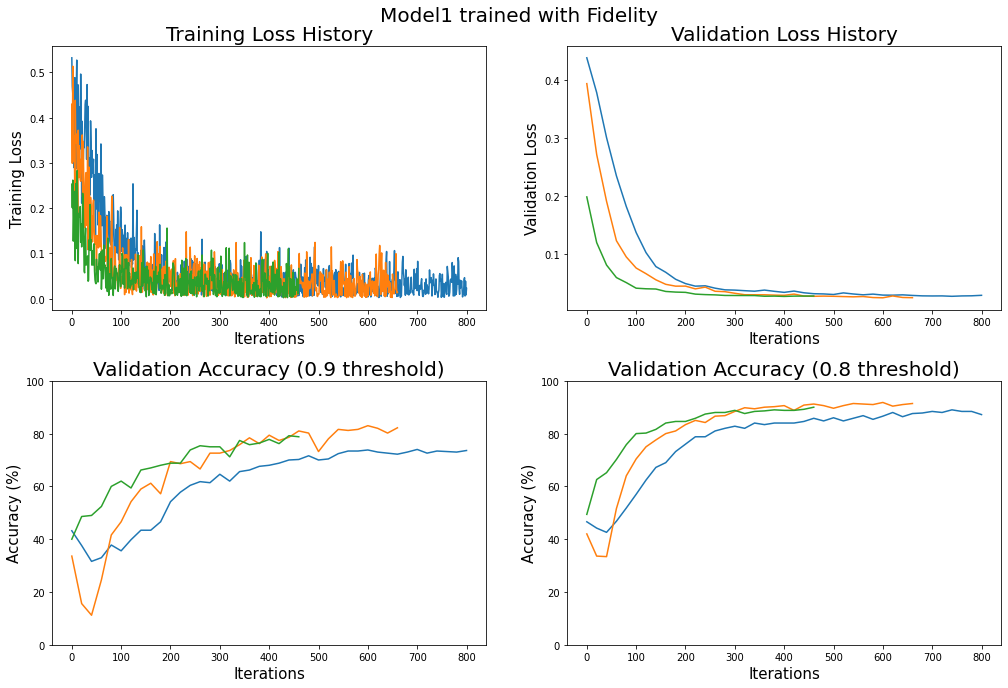

In [5]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.tight_layout(pad=5.0)
fig.suptitle("Model1 trained with Fidelity").set_fontsize(20)
ax1.plot(range(len(loss_history1)), loss_history1, range(len(loss_history2)), loss_history2, range(len(loss_history3)), loss_history3)
ax1.set_title("Training Loss History").set_fontsize(20)
ax1.set_xlabel("Iterations").set_fontsize(15)
ax1.set_ylabel("Training Loss").set_fontsize(15)
ax2.plot(np.array(range(len(validation_loss_history1))) * 20, validation_loss_history1, np.array(range(len(validation_loss_history2))) * 20, validation_loss_history2, np.array(range(len(validation_loss_history3))) * 20, validation_loss_history3)
ax2.set_title("Validation Loss History").set_fontsize(20)
ax2.set_xlabel("Iterations").set_fontsize(15)
ax2.set_ylabel("Validation Loss").set_fontsize(15)
ax3.plot(np.array(range(len(validation_accuracy90_history1))) * 20, validation_accuracy90_history1, np.array(range(len(validation_accuracy90_history2))) * 20, validation_accuracy90_history2, np.array(range(len(validation_accuracy90_history3))) * 20, validation_accuracy90_history3)
ax3.set_title("Validation Accuracy (0.9 threshold)").set_fontsize(20)
ax3.set_xlabel("Iterations").set_fontsize(15)
ax3.set_ylabel("Accuracy (%)").set_fontsize(15)
ax3.set_ylim(0, 100)
ax4.plot(np.array(range(len(validation_accuracy80_history1))) * 20, validation_accuracy80_history1, np.array(range(len(validation_accuracy80_history2))) * 20, validation_accuracy80_history2, np.array(range(len(validation_accuracy80_history3))) * 20, validation_accuracy80_history3)
ax4.set_title("Validation Accuracy (0.8 threshold)").set_fontsize(20)
ax4.set_xlabel("Iterations").set_fontsize(15)
ax4.set_ylabel("Accuracy (%)").set_fontsize(15)
ax4.set_ylim(0, 100)

print("Experiment1\n")
print("---------------")
print(f"Test Loss: {Test_loss1}\n")
print(f"Test Accuracy (0.9): {Test_Accuracy90_1}\n")
print(f"Test Accuracy (0.8): {Test_Accuracy80_1}\n")

print("Experiment2\n")
print("---------------")
print(f"Test Loss: {Test_loss2}\n")
print(f"Test Accuracy (0.9): {Test_Accuracy90_2}\n")
print(f"Test Accuracy (0.8): {Test_Accuracy80_2}\n")

print("Experiment3\n")
print("---------------")
print(f"Test Loss: {Test_loss3}\n")
print(f"Test Accuracy (0.9): {Test_Accuracy90_3}\n")
print(f"Test Accuracy (0.8): {Test_Accuracy80_3}\n")


In [6]:
name1 = "/Users/tak/Github/QEmbedding/Results/Experiment1/Model1_Fidelity.pt"
name2 = "/Users/tak/Github/QEmbedding/Results/Experiment2/Model1_Fidelity.pt"
name3 = "/Users/tak/Github/QEmbedding/Results/Experiment3/Model1_Fidelity.pt"
names = [name1, name2, name3]

for i, name in enumerate(names):
    TraceModel = Hybrid_nn.get_model("DistanceModel1_Trace")
    HSModel = Hybrid_nn.get_model("DistanceModel1_HS")
    TraceModel.load_state_dict(torch.load(name, map_location=torch.device('cpu')))
    HSModel.load_state_dict(torch.load(name, map_location=torch.device('cpu')))
    with torch.no_grad():
        trace_distance = TraceModel(X1_test, X0_test)
        HS_distance = HSModel(X1_test, X0_test)
    print(f"Experiment{i+1}: Trace Distance of test data is {-1 * trace_distance}\n")
    print(f"Experiment{i+1}: Hilbert Schmidt Distance of test data is {-1 * HS_distance}\n")

/usr/local/anaconda3/envs/QC/lib/python3.10/site-packages/pennylane/qnn/torch.py:328: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646991213/work/aten/src/ATen/native/Copy.cpp:250.)
  return self.qnode(**kwargs).type(x.dtype)


Experiment1: Trace Distance of test data is 0.9237213134765625

Experiment1: Hilbert Schmidt Distance of test data is 0.40379250049591064

Experiment2: Trace Distance of test data is 0.9296813607215881

Experiment2: Hilbert Schmidt Distance of test data is 0.4296700954437256

Experiment3: Trace Distance of test data is 0.9411383867263794

Experiment3: Hilbert Schmidt Distance of test data is 0.4152795374393463



# 2.2. Model1 with Hilbert-Schmidt inner product

In [7]:
loss_history1 = np.array([0.3715781271457672, 0.2062610238790512, 0.3643634617328644, 0.11621219664812088, 0.15774711966514587, 0.31358036398887634, 0.20079421997070312, 0.3223300874233246, 0.16241447627544403, 0.2020321637392044, 0.2212211936712265, 0.2872760593891144, 0.14022651314735413, 0.39797133207321167, 0.2507273554801941, 0.21640172600746155, 0.204805389046669, 0.12165626138448715, 0.11113635450601578, 0.10965617746114731, 0.2087373286485672, 0.11028331518173218, 0.1909109205007553, 0.13430547714233398, 0.1973400115966797, 0.10672339797019958, 0.07150883972644806, 0.16824889183044434, 0.136228546500206, 0.12210444360971451, 0.1400090605020523, 0.11153274029493332, 0.10872446745634079, 0.04837874323129654, 0.04450875520706177, 0.08877789974212646, 0.11584430187940598, 0.1324266940355301, 0.06250505149364471, 0.06139848753809929, 0.0895719975233078, 0.08673538267612457, 0.06593991070985794, 0.046791233122348785, 0.08162429928779602, 0.0819733589887619, 0.08800404518842697, 0.0944552794098854, 0.03499245271086693, 0.0660572350025177, 0.06627413630485535, 0.047567181289196014, 0.062337204813957214, 0.051841575652360916, 0.08564659208059311, 0.026877693831920624, 0.09606341272592545, 0.05841875821352005, 0.10771936178207397, 0.10740038752555847, 0.01563064381480217, 0.06654943525791168, 0.09579332172870636, 0.040767788887023926, 0.04812799394130707, 0.025893406942486763, 0.06803172081708908, 0.12160670757293701, 0.076358363032341, 0.06670529395341873, 0.05577603355050087, 0.07141657918691635, 0.06035438925027847, 0.06070009991526604, 0.07310057431459427, 0.07546678185462952, 0.04131301864981651, 0.060857489705085754, 0.046826913952827454, 0.06391564756631851, 0.08206132054328918, 0.08716453611850739, 0.04109115153551102, 0.03773143142461777, 0.08567646890878677, 0.03422897681593895, 0.0782884806394577, 0.04953381046652794, 0.03863207623362541, 0.05257859453558922, 0.033679671585559845, 0.012970112264156342, 0.030912378802895546, 0.034391436725854874, 0.022030118852853775, 0.06035612151026726, 0.035798054188489914, 0.08689156919717789, 0.012146694585680962, 0.01557028479874134, 0.024314450100064278, 0.04219447448849678, 0.06526253372430801, 0.018530908972024918, 0.016852637752890587, 0.11839524656534195, 0.017744967713952065, 0.05994711443781853, 0.059089403599500656, 0.045107919722795486, 0.05543253943324089, 0.027031604200601578, 0.07399892807006836, 0.11134792864322662, 0.0184666495770216, 0.04483509436249733, 0.021687407046556473, 0.05179790034890175, 0.09326823800802231, 0.10646989941596985, 0.02218218706548214, 0.02513073943555355, 0.11690425872802734, 0.04529940336942673, 0.0864611491560936, 0.03455030918121338, 0.05398586764931679, 0.029544707387685776, 0.03636964410543442, 0.03324370086193085, 0.03157523646950722, 0.030918708071112633, 0.03307654336094856, 0.01481204479932785, 0.031249068677425385, 0.039509423077106476, 0.0870281234383583, 0.0055856117978692055, 0.018708735704421997, 0.04142165556550026, 0.015487435273826122, 0.05277266725897789, 0.017079291865229607, 0.04353548586368561, 0.11711455881595612, 0.024704575538635254, 0.01195165142416954, 0.019782377406954765, 0.045134346932172775, 0.009598171338438988, 0.0079092588275671, 0.044517721980810165, 0.013202258385717869, 0.012310557067394257, 0.04001440107822418, 0.06855732202529907, 0.0760577842593193, 0.07588281482458115, 0.05500739812850952, 0.04899170622229576, 0.09429839998483658, 0.11305690556764603, 0.03761392459273338, 0.048312220722436905, 0.010603883303701878, 0.016497373580932617, 0.04981575906276703, 0.05156544968485832, 0.02640640176832676, 0.006722795777022839, 0.07982129603624344, 0.08416782319545746, 0.07919526100158691, 0.05275903269648552, 0.05597811937332153, 0.012783071957528591, 0.04057678207755089, 0.03253338113427162, 0.06901740282773972, 0.013117823749780655, 0.05572158843278885, 0.04354098066687584, 0.04483790323138237, 0.08039955049753189, 0.06330648064613342, 0.011123139411211014, 0.02535519003868103, 0.08026516437530518, 0.025508321821689606, 0.02116486057639122, 0.031431008130311966, 0.06188496947288513, 0.01083443034440279, 0.034537944942712784, 0.01890070177614689, 0.0353131964802742, 0.03177795186638832, 0.017464522272348404, 0.08203023672103882, 0.00853501446545124, 0.02105393074452877, 0.004493951331824064, 0.0458870455622673, 0.011543911881744862, 0.019942915067076683, 0.02433873899281025, 0.0031634883489459753, 0.007372105028480291, 0.02503516897559166, 0.040497105568647385, 0.03413497656583786, 0.011492843739688396, 0.00415852339938283, 0.01363384909927845, 0.07896602898836136, 0.07445818930864334, 0.0401468463242054, 0.003184393048286438, 0.09765401482582092, 0.007365212310105562, 0.04109576717019081, 0.02874596044421196, 0.11179222166538239, 0.01686449907720089, 0.0976051315665245, 0.05705634132027626, 0.015962855890393257, 0.008518942631781101, 0.039922673255205154, 0.01581898331642151, 0.020368320867419243, 0.042538974434137344, 0.05911858379840851, 0.06631015986204147, 0.04369517043232918, 0.05016183853149414, 0.08008423447608948, 0.015274595469236374, 0.04401460662484169, 0.019584055989980698, 0.0483572818338871, 0.004676133394241333, 0.08120346814393997, 0.0014178308192640543, 0.035722766071558, 0.08084964752197266, 0.04258081316947937, 0.02768574096262455, 0.006041133310645819, 0.029592549428343773, 0.03225661814212799, 0.049277618527412415, 0.0059859054163098335, 0.05960801988840103, 0.020153693854808807, 0.07086318731307983, 0.012396447360515594, 0.05046141892671585, 0.05269253998994827, 0.050493378192186356, 0.002311491407454014, 0.009038006886839867, 0.024941420182585716, 0.030917419120669365, 0.012609189376235008, 0.005465216469019651, 0.018910296261310577, 0.019800858572125435, 0.08276016265153885, 0.005378004163503647, 0.07331500202417374, 0.0045387838035821915, 0.004496955778449774, 0.08178085088729858, 0.07678142189979553, 0.00300263287499547, 0.007071887608617544, 0.03506334125995636, 0.08418714255094528, 0.03378475457429886, 0.08182533830404282, 0.06767287105321884, 0.010157519020140171, 0.029677163809537888, 0.06096735969185829, 0.04020116850733757, 0.0026115940418094397, 0.011281781829893589, 0.025493785738945007, 0.04034159705042839, 0.04798828437924385, 0.12570437788963318, 0.13408653438091278, 0.08165354281663895, 0.021663470193743706, 0.005512875039130449, 0.052723053842782974, 0.006914464291185141, 0.042900100350379944, 0.10247813910245895, 0.04270171374082565, 0.024719342589378357, 0.005055328365415335, 0.001623701537027955, 0.046242136508226395, 0.03282318264245987, 0.05832050368189812, 0.004695875570178032, 0.004261757247149944, 0.008425671607255936, 0.055532362312078476, 0.045133545994758606, 0.06131259724497795, 0.05441155657172203, 0.042615193873643875, 0.06326204538345337, 0.07934192568063736, 0.0067350780591368675, 0.058832790702581406, 0.03759703040122986, 0.051555439829826355, 0.01986907422542572, 0.03611708804965019, 0.031245898455381393, 0.01802579127252102, 0.03246360272169113, 0.04624874144792557, 0.0047583007253706455, 0.050176627933979034, 0.012624107301235199, 0.022390246391296387, 0.05234810337424278, 0.04823330417275429, 0.012728316709399223, 0.013488407246768475, 0.023985957726836205, 0.005018028896301985, 0.040032897144556046, 0.020537227392196655, 0.010345637798309326, 0.054549407213926315, 0.04718977212905884, 0.05471175163984299, 0.03612285852432251, 0.011708627454936504, 0.01797962561249733, 0.05365889519453049, 0.006665849592536688, 0.042969878762960434, 0.036484796553850174, 0.10069272667169571, 0.004489816725254059, 0.007465409580618143, 0.017916684970259666, 0.010465259663760662, 0.0029786936938762665, 0.05217815935611725, 0.0369538739323616, 0.0030158862937241793, 0.062304556369781494, 0.0424746535718441, 0.0034849930088967085, 0.004865484777837992, 0.009025867097079754, 0.05406613275408745, 0.046449609100818634, 0.009174562990665436, 0.01749090664088726, 0.021751414984464645, 0.013224790804088116, 0.057256877422332764, 0.0011154919629916549, 0.08582203090190887, 0.0066988347098231316, 0.03438551351428032, 0.028085293248295784, 0.002151415217667818, 0.0016107234405353665, 0.018849585205316544, 0.0626930519938469, 0.035542309284210205])
loss_history2 = np.array([0.3674285411834717, 0.4624830186367035, 0.5062106847763062, 0.5303404927253723, 0.5102329850196838, 0.5265376567840576, 0.4751552939414978, 0.3899219036102295, 0.3693341612815857, 0.5077935457229614, 0.3527187705039978, 0.3595214784145355, 0.49347883462905884, 0.24812538921833038, 0.46635112166404724, 0.2939854860305786, 0.3810219466686249, 0.44231468439102173, 0.42839205265045166, 0.5623637437820435, 0.34712550044059753, 0.2971339821815491, 0.30150219798088074, 0.4580328166484833, 0.4773772358894348, 0.3713611960411072, 0.4087059199810028, 0.47822409868240356, 0.41006216406822205, 0.40138763189315796, 0.261249840259552, 0.3730488419532776, 0.18561924993991852, 0.3494184911251068, 0.30953100323677063, 0.2398628145456314, 0.2887311279773712, 0.38937297463417053, 0.2889147996902466, 0.31928229331970215, 0.35564953088760376, 0.43758705258369446, 0.402652382850647, 0.505519688129425, 0.23290610313415527, 0.307625412940979, 0.29872265458106995, 0.39555516839027405, 0.3220624029636383, 0.3223898708820343, 0.5157404541969299, 0.326495498418808, 0.260561466217041, 0.3278660178184509, 0.2982788383960724, 0.24855300784111023, 0.2639841139316559, 0.28111395239830017, 0.23964129388332367, 0.21592164039611816, 0.15694350004196167, 0.1959373950958252, 0.08312050998210907, 0.26127636432647705, 0.19349928200244904, 0.23829562962055206, 0.08183640986680984, 0.2120462954044342, 0.18172313272953033, 0.13391490280628204, 0.14299239218235016, 0.10518728196620941, 0.08628325164318085, 0.1452595442533493, 0.11774186044931412, 0.08715701103210449, 0.20942668616771698, 0.2022317796945572, 0.09948905557394028, 0.16947627067565918, 0.12189657241106033, 0.09360023587942123, 0.13718406856060028, 0.11332198977470398, 0.1654098480939865, 0.1018189862370491, 0.10023792833089828, 0.11963318288326263, 0.15232805907726288, 0.15153943002223969, 0.19677644968032837, 0.07498085498809814, 0.11348374933004379, 0.07797341793775558, 0.12536773085594177, 0.05125490948557854, 0.08565101772546768, 0.04421954229474068, 0.10162928700447083, 0.0687386766076088, 0.15296629071235657, 0.04037896916270256, 0.0385189987719059, 0.03821992874145508, 0.0861344039440155, 0.05809164047241211, 0.0974690243601799, 0.06607577949762344, 0.1546018421649933, 0.04906068369746208, 0.03870507329702377, 0.055477775633335114, 0.03522804379463196, 0.0815533697605133, 0.14373591542243958, 0.07341548055410385, 0.02042439579963684, 0.05802818760275841, 0.03582514077425003, 0.06562911719083786, 0.04446278512477875, 0.09381311386823654, 0.060186613351106644, 0.03931727632880211, 0.050568342208862305, 0.09926871955394745, 0.049099091440439224, 0.04137621819972992, 0.04141419380903244, 0.04846147447824478, 0.07540319859981537, 0.07474385201931, 0.10338691622018814, 0.05942996218800545, 0.042646996676921844, 0.04589816555380821, 0.07452617585659027, 0.04471035674214363, 0.050222400575876236, 0.10060155391693115, 0.06667818129062653, 0.019685424864292145, 0.0169879961758852, 0.0796784982085228, 0.058771464973688126, 0.03177152946591377, 0.03809928894042969, 0.06519057601690292, 0.031049013137817383, 0.04501137137413025, 0.051012735813856125, 0.12572532892227173, 0.060341138392686844, 0.08135282248258591, 0.13828140497207642, 0.06078590825200081, 0.07886143773794174, 0.03903244808316231, 0.050203587859869, 0.02673151157796383, 0.034536171704530716, 0.045407429337501526, 0.029177015647292137, 0.025848282501101494, 0.10685969144105911, 0.01814895123243332, 0.056908976286649704, 0.014344817958772182, 0.029238015413284302, 0.05168994888663292, 0.05464242771267891, 0.07740604877471924, 0.0615900419652462, 0.02288224920630455, 0.04724963381886482, 0.09289036691188812, 0.030102891847491264, 0.08111779391765594, 0.0408487468957901, 0.06232960522174835, 0.0283900685608387, 0.06717180460691452, 0.04260407015681267, 0.010709844529628754, 0.058520764112472534, 0.030323892831802368, 0.026022037491202354, 0.03551963344216347, 0.02288692630827427, 0.051559995859861374, 0.06318426132202148, 0.017318060621619225, 0.06812123209238052, 0.038794007152318954, 0.05911187455058098, 0.06706275045871735, 0.07440695911645889, 0.0378258153796196, 0.032928768545389175, 0.049351055175065994, 0.031906332820653915, 0.07605235278606415, 0.049459733068943024, 0.06074993312358856, 0.049097709357738495, 0.023097846657037735, 0.07898809015750885, 0.03391934186220169, 0.052106693387031555, 0.027890315279364586, 0.02236364223062992, 0.030341343954205513, 0.051807187497615814, 0.03936591371893883, 0.028110863640904427, 0.039112385362386703, 0.014765431173145771, 0.03518366441130638, 0.07448266446590424, 0.015458976849913597, 0.04305267333984375, 0.049118947237730026, 0.05085873603820801, 0.056822001934051514, 0.12047885358333588, 0.029355604201555252, 0.07903275638818741, 0.01033875159919262, 0.014160186052322388, 0.03931643068790436, 0.05690238997340202, 0.0043375506065785885, 0.031757138669490814, 0.04037711024284363, 0.014226214960217476, 0.04709053412079811, 0.07848934084177017, 0.017491374164819717, 0.009615382179617882, 0.09486457705497742, 0.015260138548910618, 0.032094553112983704, 0.030239814892411232, 0.07413852959871292, 0.05019134283065796, 0.04309676215052605, 0.05243982747197151, 0.08787030726671219, 0.03109678626060486, 0.07060269266366959, 0.10369639098644257, 0.06199904903769493, 0.0472259446978569, 0.012429754249751568, 0.03445271775126457, 0.036061543971300125, 0.02263231761753559, 0.0417662151157856, 0.023236652836203575, 0.014849495142698288, 0.01076546311378479, 0.05116061866283417, 0.0973668098449707, 0.040486931800842285, 0.008044581860303879, 0.045406896620988846, 0.016223372891545296, 0.03231187164783478, 0.03321797400712967, 0.01720697432756424, 0.04848848283290863, 0.011530899442732334, 0.01333064865320921, 0.021393733099102974, 0.023053253069519997, 0.034396033734083176, 0.01824953220784664, 0.02301817573606968, 0.02614227496087551, 0.04183759167790413, 0.07457760721445084, 0.020725350826978683, 0.010208438150584698, 0.027730800211429596, 0.012830862775444984, 0.04225730150938034, 0.033593907952308655, 0.012518825009465218, 0.03435714915394783, 0.01103471964597702, 0.03125540167093277, 0.07934938371181488, 0.011422255076467991, 0.0415034294128418, 0.02575722336769104, 0.08920148015022278, 0.031154416501522064, 0.040143564343452454, 0.04630790650844574, 0.015166590921580791, 0.03707297146320343, 0.010204605758190155, 0.06649735569953918, 0.04116290807723999, 0.030478520318865776, 0.008616533130407333, 0.019440893083810806, 0.06675510108470917, 0.09908846020698547, 0.03710145875811577, 0.022454755380749702, 0.05962355434894562, 0.010646404698491096, 0.026957277208566666, 0.007977118715643883, 0.02915804274380207, 0.03438996151089668, 0.05019837245345116, 0.010712048970162868, 0.050933998078107834, 0.022726261988282204, 0.08930989354848862, 0.022168636322021484, 0.015055201016366482, 0.008706375025212765, 0.03127634525299072, 0.03316352143883705, 0.01580951362848282, 0.015785284340381622, 0.0032792924903333187, 0.016805540770292282, 0.03959064558148384, 0.03795648738741875, 0.05901351943612099, 0.023982809856534004, 0.07739293575286865, 0.02347191981971264, 0.0231354758143425, 0.0527433343231678, 0.04706702008843422, 0.03927835822105408, 0.05281839147210121, 0.046077799052000046, 0.03288958966732025, 0.047076065093278885, 0.03434021398425102, 0.030785497277975082, 0.011545011773705482, 0.03508614003658295, 0.0038306352216750383, 0.12840452790260315, 0.030802957713603973, 0.012109842151403427, 0.006596265360713005, 0.016882257536053658, 0.08660980314016342, 0.022364666685461998, 0.021508390083909035, 0.005798476282507181, 0.01852705515921116, 0.0573684386909008, 0.0363197922706604, 0.009026195853948593, 0.009002630598843098, 0.03934838995337486, 0.03554729372262955, 0.04568998143076897, 0.044461991637945175, 0.010881138034164906, 0.047184962779283524, 0.009935126639902592, 0.020189732313156128, 0.03455033898353577, 0.060146067291498184, 0.02811601012945175, 0.03688738867640495, 0.03962503746151924, 0.0038815513253211975, 0.014611980877816677, 0.025558482855558395, 0.01944022998213768, 0.05968911200761795, 0.042991045862436295, 0.01712089031934738, 0.06048843264579773, 0.022295640781521797, 0.023676952347159386, 0.004234677646309137, 0.04706580564379692, 0.0392952635884285, 0.043661851435899734, 0.10196170210838318, 0.01706446148455143, 0.023310193791985512, 0.05335497111082077, 0.05583459138870239, 0.09378587454557419, 0.0065404740162193775, 0.015713674947619438, 0.011760108172893524, 0.010970006696879864, 0.013515887781977654, 0.06972295790910721, 0.02735302411019802, 0.02004973404109478, 0.04163450747728348, 0.04317620024085045, 0.005338352173566818, 0.030364440754055977, 0.05679267644882202, 0.0206864345818758, 0.03592679649591446, 0.025824064388871193, 0.026231689378619194, 0.052621182054281235, 0.023246994242072105, 0.0067202127538621426, 0.03076282888650894, 0.016474463045597076, 0.024050239473581314, 0.06414227932691574, 0.09801826626062393, 0.07198437303304672, 0.018165141344070435, 0.09992818534374237, 0.009148895740509033, 0.009143841452896595, 0.051787786185741425, 0.04100226238369942, 0.0769791379570961, 0.1071532592177391, 0.04649406671524048, 0.015777498483657837, 0.01836559921503067, 0.045099955052137375, 0.02908805012702942, 0.06287753582000732, 0.04400983825325966, 0.048772912472486496, 0.020740125328302383, 0.03884352371096611, 0.005293204449117184, 0.01948181912302971, 0.020860785618424416, 0.02594757452607155, 0.11286380887031555, 0.06666689366102219, 0.03657681867480278, 0.03321706876158714, 0.010979637503623962, 0.08331044018268585, 0.0035860922653228045, 0.029698103666305542, 0.042518120259046555, 0.038611043244600296, 0.04466351494193077, 0.016592008993029594, 0.004813711624592543, 0.00796897429972887, 0.06586631387472153, 0.058339159935712814, 0.023338155820965767, 0.005848678294569254, 0.022495074197649956, 0.004803939256817102, 0.004778064787387848, 0.06148909404873848, 0.037753600627183914, 0.011282548308372498, 0.016694944351911545, 0.02168123982846737, 0.015466606244444847, 0.05549497529864311, 0.042364344000816345, 0.0040913852863013744, 0.018058868125081062, 0.048086509108543396, 0.035493142902851105, 0.045729540288448334, 0.014143142849206924, 0.009904274716973305, 0.117808036506176, 0.007412502076476812, 0.015860581770539284, 0.0170921441167593, 0.033934567123651505, 0.004125334322452545, 0.026276981458067894, 0.10762830823659897, 0.016246138140559196, 0.016658587381243706, 0.006887361872941256, 0.049584511667490005, 0.003711793338879943, 0.002376943826675415, 0.03911171853542328, 0.037904564291238785, 0.054269060492515564, 0.08703631907701492, 0.047939103096723557, 0.045096490532159805, 0.05458704009652138, 0.00795071478933096, 0.03729245439171791, 0.019612593576312065, 0.01810113713145256, 0.029665643349289894, 0.03091060370206833, 0.023442421108484268, 0.0843438059091568, 0.0049661812372505665, 0.03191598504781723, 0.0057145897299051285, 0.019186103716492653, 0.009317389689385891, 0.058708496391773224, 0.024165643379092216, 0.019848115742206573, 0.07081566751003265, 0.0898699164390564, 0.0059099686332046986, 0.0043093073181807995, 0.04074449837207794, 0.051581934094429016, 0.035062916576862335, 0.04912075027823448, 0.017737122252583504, 0.012964250519871712, 0.032829299569129944, 0.012184777297079563, 0.09025829285383224, 0.011784982867538929, 0.005371504928916693, 0.028878718614578247, 0.044410109519958496, 0.005358053836971521, 0.0431550033390522, 0.006518661975860596, 0.015825560316443443, 0.017457956448197365, 0.004347816109657288, 0.011630849912762642, 0.020300298929214478, 0.015050796791911125, 0.023687878623604774, 0.04741266742348671, 0.006749898660928011, 0.0366864874958992, 0.005723102483898401, 0.025613173842430115, 0.002671335358172655, 0.007219209335744381, 0.03841360658407211, 0.0603298544883728, 0.04462341591715813, 0.014060884714126587, 0.007539994549006224, 0.04730594530701637, 0.05262906476855278, 0.0518709272146225, 0.04246099293231964, 0.020874109119176865, 0.04814814776182175, 0.0073649394325912, 0.039859507232904434, 0.02462383732199669, 0.019896535202860832, 0.036652326583862305, 0.02412238158285618, 0.0412176251411438, 0.020408837124705315, 0.036238618195056915, 0.02449759654700756, 0.014308054000139236, 0.04138275980949402, 0.029636790975928307, 0.007369953207671642, 0.0010083562228828669, 0.012432695366442204, 0.029851263388991356, 0.043989140540361404, 0.00274224323220551, 0.010687301866710186, 0.005016643088310957, 0.034482430666685104, 0.009061921387910843, 0.06432043761014938, 0.0012767658336088061, 0.03025316633284092, 0.00591079518198967, 0.0639367401599884, 0.007354958914220333, 0.022719068452715874, 0.010890892706811428, 0.03912677243351936, 0.042153067886829376, 0.009728437289595604, 0.01212562806904316, 0.0535726398229599, 0.014781825244426727, 0.039643507450819016, 0.02967134676873684, 0.05448373779654503, 0.012144808657467365, 0.03255406394600868, 0.006713771726936102, 0.019998548552393913, 0.033608440309762955, 0.004509599879384041, 0.007668152917176485, 0.012780735269188881, 0.02580658160150051, 0.013563978485763073, 0.0720791146159172, 0.0063297441229224205, 0.09229785948991776, 0.021591467782855034, 0.07344511151313782, 0.01619466207921505, 0.03362810239195824, 0.07720038294792175, 0.0026178257539868355, 0.005023088306188583, 0.018172672018408775, 0.012594611383974552, 0.04789000377058983, 0.0349910669028759, 0.04901387542486191, 0.015193994157016277, 0.02008819207549095, 0.03903457149863243, 0.025322942063212395, 0.0334869921207428, 0.012557420879602432, 0.0046578929759562016, 0.011395161040127277, 0.0019003564957529306, 0.013830702751874924, 0.04347947984933853, 0.013341887854039669, 0.004739078693091869, 0.018543174490332603, 0.0221970584243536, 0.04550502821803093, 0.008213710971176624, 0.05725711211562157, 0.047693219035863876, 0.08760257810354233, 0.01026237104088068, 0.02550382725894451, 0.009434518404304981, 0.04617536440491676, 0.003690323093906045, 0.021936634555459023, 0.0076960488222539425, 0.023137597367167473, 0.016552705317735672, 0.043633222579956055, 0.05870659649372101, 0.011095200665295124, 0.03870394453406334, 0.006833333987742662, 0.028655145317316055, 0.02059721201658249, 0.041847746819257736, 0.05827614665031433, 0.0027425300795584917, 0.010135259479284286, 0.017889561131596565, 0.06877278536558151, 0.005384734831750393, 0.032417379319667816, 0.06548818200826645, 0.03240092098712921, 0.017562586814165115, 0.04119589552283287, 0.04162844642996788, 0.004247069824486971, 0.07695118337869644, 0.008074404671788216, 0.07431858777999878, 0.043689925223588943, 0.06687915325164795, 0.053590476512908936, 0.0500960499048233, 0.006351670250296593, 0.0023974746000021696, 0.018681170418858528, 0.031019428744912148, 0.04081710800528526, 0.0037741600535809994, 0.019678981974720955, 0.035924699157476425, 0.008209067396819592, 0.005906339269131422, 0.035663969814777374, 0.03560439124703407, 0.01092715933918953, 0.026961378753185272, 0.011445119976997375, 0.07577693462371826, 0.04273248091340065, 0.11052224785089493, 0.008010218851268291, 0.008545941673219204, 0.014872919768095016, 0.044172096997499466, 0.0026492460165172815, 0.016359662637114525, 0.030114609748125076, 0.006612044293433428, 0.06152339279651642, 0.03935053572058678, 0.07057340443134308, 0.005374678876250982, 0.013256903737783432, 0.14834782481193542, 0.038009293377399445, 0.022931288927793503, 0.04166330397129059, 0.028307931497693062])
loss_history3 = np.array([0.4314597249031067, 0.2410781979560852, 0.35474416613578796, 0.23390984535217285, 0.23219582438468933, 0.30709826946258545, 0.28275904059410095, 0.22540701925754547, 0.38756194710731506, 0.30658408999443054, 0.11107730865478516, 0.18678885698318481, 0.2564909756183624, 0.24052943289279938, 0.14452660083770752, 0.28655752539634705, 0.17868179082870483, 0.1877278834581375, 0.19705085456371307, 0.2503199279308319, 0.14279857277870178, 0.2522273659706116, 0.1918269246816635, 0.10448548197746277, 0.09860236197710037, 0.14145134389400482, 0.08823014795780182, 0.15671126544475555, 0.10314832627773285, 0.12519386410713196, 0.05301833525300026, 0.0624607652425766, 0.13624736666679382, 0.11488097906112671, 0.08998078107833862, 0.12011491507291794, 0.07185529917478561, 0.18941031396389008, 0.07179581373929977, 0.11978990584611893, 0.1445048749446869, 0.04602839797735214, 0.07998783886432648, 0.04259880632162094, 0.03177869692444801, 0.09533882141113281, 0.09851688146591187, 0.047902967780828476, 0.07386510074138641, 0.0757283866405487, 0.06943390518426895, 0.050997428596019745, 0.0880638137459755, 0.043081894516944885, 0.04195832088589668, 0.09278601408004761, 0.13298293948173523, 0.11717633157968521, 0.097826287150383, 0.05619119107723236, 0.09239654242992401, 0.09341016411781311, 0.03603306785225868, 0.04288734495639801, 0.07298159599304199, 0.044725432991981506, 0.07829602062702179, 0.06634517759084702, 0.07253740727901459, 0.09425846487283707, 0.03871593251824379, 0.06569499522447586, 0.046799782663583755, 0.023687969893217087, 0.05976681038737297, 0.06799764186143875, 0.028768114745616913, 0.03815000504255295, 0.02679007314145565, 0.021355271339416504, 0.11655839532613754, 0.12857961654663086, 0.0661124438047409, 0.09905645251274109, 0.06123331934213638, 0.07965557277202606, 0.03934670239686966, 0.0244983471930027, 0.04150011017918587, 0.06219455972313881, 0.07606544345617294, 0.1016952320933342, 0.016808871179819107, 0.050805192440748215, 0.06200595200061798, 0.0636090487241745, 0.016701428219676018, 0.027289409190416336, 0.05327275022864342, 0.06900865584611893, 0.01623237319290638, 0.025944814085960388, 0.02901279367506504, 0.07054980844259262, 0.022596903145313263, 0.041344061493873596, 0.10552985966205597, 0.04016083478927612, 0.05594877898693085, 0.04559033736586571, 0.02614348754286766, 0.1379484385251999, 0.022917572408914566, 0.026171883568167686, 0.011834722943603992, 0.028990399092435837, 0.03461427614092827, 0.021065041422843933, 0.07168793678283691, 0.01713688299059868, 0.024579772725701332, 0.08015906810760498, 0.05237831175327301, 0.01987871713936329, 0.07140378654003143, 0.044415250420570374, 0.00772412633523345, 0.016094470396637917, 0.06789014488458633, 0.04367004334926605, 0.012625045143067837, 0.0426124669611454, 0.02169567532837391, 0.051080282777547836, 0.027372412383556366, 0.06791353225708008, 0.02281263843178749, 0.04769826680421829, 0.02782953530550003, 0.031849686056375504, 0.018090903759002686, 0.01780618540942669, 0.01713506691157818, 0.05004800111055374, 0.06154869124293327, 0.12091844528913498, 0.04101080819964409, 0.08390767872333527, 0.04182259365916252, 0.05507643520832062, 0.0347096212208271, 0.020351681858301163, 0.03206585720181465, 0.04734669253230095, 0.028656354174017906, 0.03849494457244873, 0.017151806503534317, 0.013159527443349361, 0.06889915466308594, 0.020598750561475754, 0.02421036921441555, 0.03204841911792755, 0.032141249626874924, 0.0381605289876461, 0.08069488406181335, 0.016705164685845375, 0.06544908136129379, 0.02672101929783821, 0.03109893761575222, 0.06485667824745178, 0.018443915992975235, 0.006286990363150835, 0.05303629860281944, 0.030255308374762535, 0.024263981729745865, 0.0852971076965332, 0.01999625191092491, 0.08746112883090973, 0.0058368537575006485, 0.021133311092853546, 0.05057677999138832, 0.05377284809947014, 0.12461718916893005, 0.029046347364783287, 0.04713394492864609, 0.052560728043317795, 0.02016511559486389, 0.041141342371702194, 0.014902293682098389, 0.06957556307315826, 0.03905048593878746, 0.062499530613422394, 0.0025865978095680475, 0.009113353677093983, 0.06485298275947571, 0.04461023211479187, 0.07473526895046234, 0.007358347997069359, 0.05696764215826988, 0.07158298045396805, 0.007485589943826199, 0.053851932287216187, 0.013375267386436462, 0.04870731756091118, 0.0101145775988698, 0.056418921798467636, 0.007645489182323217, 0.013167083263397217, 0.04962454363703728, 0.10376841574907303, 0.021879486739635468, 0.0818963423371315, 0.019976818934082985, 0.05842645466327667, 0.04526346176862717, 0.03739715367555618, 0.03638496622443199, 0.009127527475357056, 0.00598275288939476, 0.007124409079551697, 0.09096867591142654, 0.029176006093621254, 0.055933695286512375, 0.021426839753985405, 0.08544141799211502, 0.07250536233186722, 0.05666828528046608, 0.051673706620931625, 0.03843891620635986, 0.017648912966251373, 0.01699548214673996, 0.05189330875873566, 0.029993226751685143, 0.008668367750942707, 0.038406744599342346, 0.06130850687623024, 0.017862336710095406, 0.008379637263715267, 0.05205392837524414, 0.054007451981306076, 0.005340117495507002, 0.031230179592967033, 0.06489899754524231, 0.03534945100545883, 0.06716349720954895, 0.015523016452789307, 0.008470693603157997, 0.032398875802755356, 0.039273567497730255, 0.01878666691482067, 0.017106663435697556, 0.019754599779844284, 0.04552784934639931, 0.026657819747924805, 0.04002998769283295, 0.004209431819617748, 0.09181100875139236, 0.003251831978559494, 0.04800720885396004, 0.02518712915480137, 0.047838203608989716, 0.021919235587120056, 0.04300220310688019, 0.042219143360853195, 0.030776137486100197, 0.01332151424139738, 0.013528539799153805, 0.014042876660823822, 0.012602628208696842, 0.08643294125795364, 0.009218152612447739, 0.016882961615920067, 0.02897161804139614, 0.009125345386564732, 0.00416346313431859, 0.02083861082792282, 0.06359469145536423, 0.09436038881540298, 0.023512141779065132, 0.043512120842933655, 0.044690851122140884, 0.074545718729496, 0.03567881882190704, 0.05669655650854111, 0.018985042348504066, 0.013105151243507862, 0.037789925932884216, 0.09520314633846283, 0.057952914386987686, 0.015442929230630398, 0.09801717847585678, 0.08278928697109222, 0.013874642550945282, 0.009570753201842308, 0.05148666352033615, 0.03853694349527359, 0.07323264330625534, 0.08175435662269592, 0.035703081637620926, 0.0383966863155365, 0.039059244096279144, 0.035573385655879974, 0.007871381007134914, 0.06332587450742722, 0.029324276372790337, 0.036738321185112, 0.04614081606268883, 0.050229694694280624, 0.0067369770258665085, 0.052002210170030594, 0.018631435930728912, 0.0685558021068573, 0.02269892953336239, 0.01332528330385685, 0.04887358471751213, 0.06528166681528091, 0.03189760074019432, 0.057624828070402145, 0.029952099546790123, 0.03906122222542763, 0.015185498632490635, 0.11193002760410309, 0.06268004328012466, 0.05326000973582268, 0.08343526721000671, 0.043252673000097275, 0.016049636527895927, 0.06281193345785141, 0.01649761013686657, 0.08095850050449371, 0.023401347920298576, 0.06776430457830429, 0.03657759726047516, 0.07657429575920105, 0.009454994462430477, 0.03280727192759514, 0.03344786912202835, 0.05507249757647514, 0.033195074647665024, 0.07661730796098709, 0.05486677959561348, 0.011727209202945232, 0.04690119996666908, 0.018929289653897285, 0.013577861711382866, 0.023361556231975555, 0.0831226035952568, 0.054763421416282654, 0.050211839377880096, 0.029818139970302582, 0.01842668280005455, 0.08065907657146454, 0.01305281650274992, 0.04588615894317627, 0.042984627187252045, 0.05688323453068733, 0.03811579570174217, 0.0055869463831186295, 0.010981187224388123, 0.01496233232319355, 0.09118306636810303, 0.05390717461705208, 0.04457644000649452, 0.03771650046110153, 0.0602959468960762, 0.05156733840703964, 0.005867202300578356, 0.022117137908935547, 0.02706250175833702, 0.03294963389635086, 0.0468146838247776, 0.0307026207447052, 0.08466645330190659, 0.03176846727728844, 0.04108647257089615, 0.03770915046334267, 0.03129662945866585, 0.03502822667360306, 0.11035079509019852, 0.01255885697901249, 0.04823699966073036, 0.07424183189868927, 0.056083425879478455, 0.03256159648299217, 0.04230140894651413, 0.04595613852143288, 0.035464346408843994, 0.060761354863643646, 0.044105567038059235, 0.07384876161813736, 0.021870965138077736, 0.022341934964060783, 0.007780916523188353, 0.04667943716049194, 0.04611285403370857, 0.05477391183376312, 0.024043630808591843, 0.09900699555873871, 0.07345309853553772, 0.005636769346892834, 0.0034003257751464844, 0.02823008969426155, 0.05980610102415085, 0.036072008311748505, 0.003883790923282504, 0.03608405962586403, 0.1078583374619484, 0.03712863847613335, 0.08369443565607071, 0.018555987626314163, 0.016265347599983215, 0.009155884385108948, 0.05283109471201897, 0.02641257271170616, 0.011045615188777447, 0.015842733904719353, 0.04344058781862259, 0.005553402937948704, 0.08243337273597717, 0.011358671821653843, 0.018760664388537407, 0.011131024919450283, 0.03214627131819725, 0.047519221901893616, 0.07943947613239288, 0.006821759976446629, 0.019741185009479523, 0.10711520165205002, 0.005312143824994564, 0.02469620667397976, 0.008710179477930069, 0.05869540944695473, 0.05786371976137161, 0.05035228654742241, 0.011798479594290257, 0.053221195936203, 0.03735820949077606, 0.03967186063528061, 0.05696547031402588, 0.04506988823413849, 0.0074967616237699986, 0.020814144983887672, 0.07457832992076874, 0.03561064228415489, 0.011081628501415253, 0.07223300635814667, 0.015259901992976665, 0.05117668956518173, 0.038777418434619904, 0.04683287441730499, 0.03072020411491394, 0.03732975944876671, 0.056467652320861816, 0.021327253431081772, 0.00785197876393795, 0.0227365680038929, 0.05342479422688484, 0.005892164073884487, 0.012957627885043621, 0.04571579396724701, 0.038347482681274414, 0.07956354320049286, 0.045649781823158264, 0.044288311153650284, 0.07709608227014542, 0.0032116041984409094, 0.03512197360396385, 0.009583122096955776, 0.08163391798734665, 0.006012332160025835, 0.08798664808273315, 0.004632734693586826, 0.08176665753126144, 0.02743135206401348, 0.08713813871145248, 0.011707701720297337, 0.07037213444709778, 0.005266313906759024, 0.049741897732019424, 0.02433718368411064, 0.002405329141765833, 0.07188074290752411, 0.014270265586674213, 0.017241191118955612, 0.024258410558104515, 0.016671305522322655, 0.004883772227913141, 0.04886220023036003, 0.05774328485131264, 0.04568241164088249, 0.017902186140418053, 0.024351198226213455, 0.006240126211196184, 0.006584216374903917, 0.03827789053320885, 0.049492646008729935, 0.011501584202051163, 0.0015986596699804068, 0.009999511763453484, 0.021003765985369682, 0.016310034319758415])

validation_loss_history1 = np.array([0.2402312159538269, 0.1269049048423767, 0.07979240268468857, 0.06869244575500488, 0.057984139770269394, 0.053592562675476074, 0.04614507406949997, 0.047114744782447815, 0.040271904319524765, 0.03889492154121399, 0.03636867552995682, 0.03758656606078148, 0.034534722566604614, 0.034655991941690445, 0.03742241859436035, 0.032126445323228836, 0.031458839774131775, 0.03157887980341911, 0.03273111954331398, 0.032303255051374435])
validation_loss_history2 = np.array([0.44654542207717896, 0.4045998156070709, 0.34813955426216125, 0.2215876579284668, 0.13345257937908173, 0.0912637710571289, 0.0647486075758934, 0.05417909473180771, 0.04793515056371689, 0.042122241109609604, 0.03764243423938751, 0.03345604985952377, 0.033292945474386215, 0.030044132843613625, 0.030184712260961533, 0.03189295530319214, 0.02855461649596691, 0.028589194640517235, 0.026592276990413666, 0.0265792403370142, 0.0279844980686903, 0.025980571284890175, 0.025406936183571815, 0.025401165708899498, 0.025264745578169823, 0.024600068107247353, 0.025593087077140808, 0.024481182917952538, 0.02473490498960018, 0.025013018399477005, 0.02349097654223442, 0.02385253645479679, 0.023052124306559563, 0.022312840446829796, 0.022879796102643013, 0.022924410179257393, 0.02369367517530918])
validation_loss_history3 = np.array([0.2862648367881775, 0.1902349889278412, 0.11418808996677399, 0.07063762098550797, 0.05263592675328255, 0.04486442729830742, 0.04270624741911888, 0.041461288928985596, 0.03801547363400459, 0.037043292075395584, 0.03638559579849243, 0.03915722668170929, 0.039741840213537216, 0.03554419428110123, 0.03647547960281372, 0.033987488597631454, 0.034063227474689484, 0.03297564387321472, 0.03326140716671944, 0.03231697529554367, 0.03281239792704582, 0.03204653784632683, 0.031012199819087982, 0.031087666749954224, 0.03145604953169823, 0.03165578469634056])

validation_accuracy90_history1 = np.array([32.6, 32.800000000000004, 47.199999999999996, 57.599999999999994, 61.4, 63.2, 64.8, 72.8, 69.19999999999999, 74.6, 77.8, 77.8, 76.8, 78.60000000000001, 78.8, 78.4, 76.4, 80.60000000000001, 81.0, 81.6])
validation_accuracy90_history2 = np.array([46.400000000000006, 44.6, 41.6, 35.6, 31.0, 38.0, 42.4, 47.4, 50.6, 52.800000000000004, 58.599999999999994, 62.6, 66.0, 65.60000000000001, 65.0, 69.8, 67.80000000000001, 72.39999999999999, 72.8, 72.6, 73.8, 75.6, 78.60000000000001, 78.4, 76.6, 80.2, 79.0, 80.60000000000001, 80.0, 80.0, 78.8, 77.60000000000001, 82.0, 80.80000000000001, 81.0, 80.80000000000001, 72.2])
validation_accuracy90_history3 = np.array([31.8, 31.6, 40.2, 47.0, 53.800000000000004, 55.2, 60.0, 61.4, 64.4, 62.4, 63.2, 63.4, 63.4, 65.60000000000001, 65.4, 69.19999999999999, 67.2, 67.60000000000001, 72.39999999999999, 71.39999999999999, 72.0, 73.4, 73.4, 74.0, 75.0, 74.6])

validation_accuracy80_history1 = np.array([46.2, 54.6, 68.4, 72.6, 77.4, 80.0, 83.39999999999999, 83.0, 84.2, 86.4, 87.6, 87.4, 89.0, 89.2, 88.0, 89.2, 88.4, 89.8, 89.60000000000001, 90.2])
validation_accuracy80_history2 = np.array([48.0, 48.0, 47.0, 45.2, 49.0, 56.8, 64.60000000000001, 68.4, 72.39999999999999, 76.6, 79.80000000000001, 83.0, 83.0, 85.6, 86.6, 85.39999999999999, 87.6, 87.2, 88.8, 89.8, 88.0, 89.8, 89.8, 90.0, 91.2, 91.0, 90.8, 90.8, 90.8, 91.0, 92.80000000000001, 92.0, 91.4, 91.8, 91.4, 92.60000000000001, 91.8])
validation_accuracy80_history3 = np.array([42.4, 47.599999999999994, 59.8, 67.2, 74.0, 78.2, 80.60000000000001, 81.8, 85.39999999999999, 85.6, 86.0, 83.39999999999999, 83.39999999999999, 86.4, 86.0, 88.6, 88.4, 89.2, 89.2, 89.8, 89.4, 89.4, 89.4, 90.0, 89.8, 89.4])

Test_loss1 = 0.0313844196498394
Test_loss2 = 0.02744395285844803
Test_loss3 = 0.03074890747666359

Test_Accuracy90_1 = 80.5
Test_Accuracy90_2 = 73.69
Test_Accuracy90_3 = 76.21

Test_Accuracy80_1 = 89.81
Test_Accuracy80_2 = 90.4
Test_Accuracy80_3 = 89.29

## Data Plot

Experiment1

---------------
Test Loss: 0.0313844196498394

Test Accuracy (0.9): 80.5

Test Accuracy (0.8): 89.81

Experiment2

---------------
Test Loss: 0.02744395285844803

Test Accuracy (0.9): 73.69

Test Accuracy (0.8): 90.4

Experiment3

---------------
Test Loss: 0.03074890747666359

Test Accuracy (0.9): 76.21

Test Accuracy (0.8): 89.29



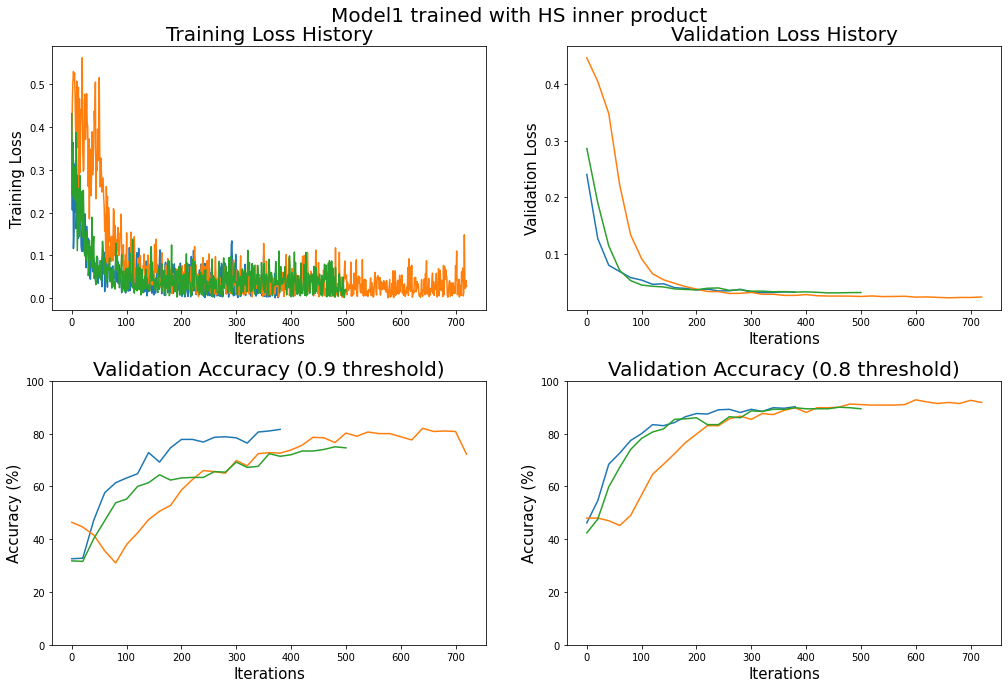

In [8]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.tight_layout(pad=5.0)
fig.suptitle("Model1 trained with HS inner product").set_fontsize(20)
ax1.plot(range(len(loss_history1)), loss_history1, range(len(loss_history2)), loss_history2, range(len(loss_history3)), loss_history3)
ax1.set_title("Training Loss History").set_fontsize(20)
ax1.set_xlabel("Iterations").set_fontsize(15)
ax1.set_ylabel("Training Loss").set_fontsize(15)
ax2.plot(np.array(range(len(validation_loss_history1))) * 20, validation_loss_history1, np.array(range(len(validation_loss_history2))) * 20, validation_loss_history2, np.array(range(len(validation_loss_history3))) * 20, validation_loss_history3)
ax2.set_title("Validation Loss History").set_fontsize(20)
ax2.set_xlabel("Iterations").set_fontsize(15)
ax2.set_ylabel("Validation Loss").set_fontsize(15)
ax3.plot(np.array(range(len(validation_accuracy90_history1))) * 20, validation_accuracy90_history1, np.array(range(len(validation_accuracy90_history2))) * 20, validation_accuracy90_history2, np.array(range(len(validation_accuracy90_history3))) * 20, validation_accuracy90_history3)
ax3.set_title("Validation Accuracy (0.9 threshold)").set_fontsize(20)
ax3.set_xlabel("Iterations").set_fontsize(15)
ax3.set_ylabel("Accuracy (%)").set_fontsize(15)
ax3.set_ylim(0, 100)
ax4.plot(np.array(range(len(validation_accuracy80_history1))) * 20, validation_accuracy80_history1, np.array(range(len(validation_accuracy80_history2))) * 20, validation_accuracy80_history2, np.array(range(len(validation_accuracy80_history3))) * 20, validation_accuracy80_history3)
ax4.set_title("Validation Accuracy (0.8 threshold)").set_fontsize(20)
ax4.set_xlabel("Iterations").set_fontsize(15)
ax4.set_ylabel("Accuracy (%)").set_fontsize(15)
ax4.set_ylim(0, 100)

print("Experiment1\n")
print("---------------")
print(f"Test Loss: {Test_loss1}\n")
print(f"Test Accuracy (0.9): {Test_Accuracy90_1}\n")
print(f"Test Accuracy (0.8): {Test_Accuracy80_1}\n")

print("Experiment2\n")
print("---------------")
print(f"Test Loss: {Test_loss2}\n")
print(f"Test Accuracy (0.9): {Test_Accuracy90_2}\n")
print(f"Test Accuracy (0.8): {Test_Accuracy80_2}\n")

print("Experiment3\n")
print("---------------")
print(f"Test Loss: {Test_loss3}\n")
print(f"Test Accuracy (0.9): {Test_Accuracy90_3}\n")
print(f"Test Accuracy (0.8): {Test_Accuracy80_3}\n")

In [9]:
name1 = "/Users/tak/Github/QEmbedding/Results/Experiment1/Model1_HSinner.pt"
name2 = "/Users/tak/Github/QEmbedding/Results/Experiment2/Model1_HSinner.pt"
name3 = "/Users/tak/Github/QEmbedding/Results/Experiment3/Model1_HSinner.pt"
names = [name1, name2, name3]

for i, name in enumerate(names):
    TraceModel = Hybrid_nn.get_model("DistanceModel1_Trace")
    HSModel = Hybrid_nn.get_model("DistanceModel1_HS")
    TraceModel.load_state_dict(torch.load(name, map_location=torch.device('cpu')))
    HSModel.load_state_dict(torch.load(name, map_location=torch.device('cpu')))
    with torch.no_grad():
        trace_distance = TraceModel(X1_test, X0_test)
        HS_distance = HSModel(X1_test, X0_test)
    print(f"Experiment{i+1}: Trace Distance of test data is {-1 * trace_distance}\n")
    print(f"Experiment{i+1}: Hilbert Schmidt Distance of test data is {-1 * HS_distance}\n")

Experiment1: Trace Distance of test data is 0.9457406997680664

Experiment1: Hilbert Schmidt Distance of test data is 0.3964325785636902

Experiment2: Trace Distance of test data is 0.9506657123565674

Experiment2: Hilbert Schmidt Distance of test data is 0.41211965680122375

Experiment3: Trace Distance of test data is 0.9567494988441467

Experiment3: Hilbert Schmidt Distance of test data is 0.39711713790893555



# 2.3. Model2 with Fidelity

In [14]:
loss_history1 = np.array([0.39270925521850586, 0.3189016580581665, 0.30827024579048157, 0.2186901867389679, 0.2792593836784363, 0.2419569343328476, 0.3168177604675293, 0.3188095688819885, 0.29978880286216736, 0.21052198112010956, 0.21453946828842163, 0.2587476372718811, 0.21477076411247253, 0.23859906196594238, 0.23186972737312317, 0.24100306630134583, 0.2014511376619339, 0.2693672776222229, 0.21439531445503235, 0.3221411108970642, 0.17812807857990265, 0.19926609098911285, 0.1927020400762558, 0.1504417061805725, 0.16270777583122253, 0.1871359795331955, 0.17022664844989777, 0.17758774757385254, 0.14100010693073273, 0.22427906095981598, 0.1479312628507614, 0.15660670399665833, 0.16050919890403748, 0.13308897614479065, 0.16155162453651428, 0.1615930199623108, 0.13718675076961517, 0.0975857749581337, 0.15648595988750458, 0.16662095487117767, 0.1254224181175232, 0.1263146698474884, 0.11261747032403946, 0.1304156482219696, 0.15252484381198883, 0.11977863311767578, 0.11744067072868347, 0.11839411407709122, 0.18521566689014435, 0.08395563066005707, 0.1649523824453354, 0.0992458313703537, 0.1626502126455307, 0.07268913090229034, 0.11546728014945984, 0.16795021295547485, 0.11440124362707138, 0.08627904951572418, 0.11441905796527863, 0.06205253303050995, 0.08541087061166763, 0.15008847415447235, 0.10306583344936371, 0.14247773587703705, 0.16461196541786194, 0.12150003015995026, 0.08853907138109207, 0.08102100342512131, 0.12296807765960693, 0.10634205490350723, 0.1146775409579277, 0.10537605732679367, 0.08452556282281876, 0.14928536117076874, 0.08372814208269119, 0.07239221036434174, 0.08334345370531082, 0.10805705189704895, 0.08839963376522064, 0.11990480124950409, 0.08739472180604935, 0.05831354111433029, 0.10010145604610443, 0.08958344906568527, 0.06528040766716003, 0.07629691064357758, 0.10411344468593597, 0.10435245931148529, 0.07559941709041595, 0.1640976518392563, 0.11574307084083557, 0.13954812288284302, 0.09829440712928772, 0.09108098596334457, 0.08672217279672623, 0.07339727878570557, 0.05474573001265526, 0.10659269988536835, 0.056056007742881775, 0.0702277347445488, 0.11252161115407944, 0.03291544318199158, 0.09662412106990814, 0.09223570674657822, 0.09767471998929977, 0.05230516940355301, 0.040343284606933594, 0.08064399659633636, 0.08636806160211563, 0.055656448006629944, 0.06581424176692963, 0.11082874238491058, 0.04809974879026413, 0.09186918288469315, 0.07591456919908524, 0.049887508153915405, 0.04000207036733627, 0.03919451683759689, 0.07995567470788956, 0.06289776414632797, 0.0471452996134758, 0.05339653044939041, 0.04605311155319214, 0.1105164960026741, 0.024382030591368675, 0.05083978548645973, 0.043298739939928055, 0.07937093824148178, 0.07974126189947128, 0.12651214003562927, 0.04568294435739517, 0.11478548496961594, 0.05046472325921059, 0.04414374381303787, 0.05255569517612457, 0.0667453333735466, 0.054237864911556244, 0.03889070823788643, 0.025908660143613815, 0.16856208443641663, 0.02851451002061367, 0.0325574167072773, 0.09426070749759674, 0.09117519110441208, 0.10442448407411575, 0.04580741003155708, 0.029343485832214355, 0.0525655560195446, 0.08145570755004883, 0.06853653490543365, 0.05514978617429733, 0.03875371441245079, 0.05845336243510246, 0.04153931513428688, 0.059560418128967285, 0.042934954166412354, 0.044591549783945084, 0.07038816064596176, 0.059286341071128845, 0.0531778410077095, 0.08471554517745972, 0.04352407529950142, 0.06388545036315918, 0.03132714331150055, 0.0524105541408062, 0.03242078050971031, 0.061559047549963, 0.029505763202905655, 0.020798830315470695, 0.05334360897541046, 0.04428519308567047, 0.05995707958936691, 0.029390977695584297, 0.06150086596608162, 0.05719586834311485, 0.04976506531238556, 0.05452573299407959, 0.06891133636236191, 0.02914198860526085, 0.04750717058777809, 0.050477322190999985, 0.046588506549596786, 0.06801467388868332, 0.058335330337285995, 0.03951099142432213, 0.04117491468787193, 0.03420405462384224, 0.07691019773483276, 0.04041304439306259, 0.06961149722337723, 0.016973162069916725, 0.052422184497117996, 0.08312379568815231, 0.05284835770726204, 0.06766581535339355, 0.04084904119372368, 0.022051429376006126, 0.06009340286254883, 0.05036938190460205, 0.07608798146247864, 0.0351041816174984, 0.03148818016052246, 0.06591375917196274, 0.03882983699440956, 0.10483981668949127, 0.12123645842075348, 0.02597549371421337, 0.02435055747628212, 0.017526818439364433, 0.03266557678580284, 0.03200852498412132, 0.019477831199765205, 0.030478710308670998, 0.02665296010673046, 0.07342200726270676, 0.02897905744612217, 0.020336445420980453, 0.07570727914571762, 0.04404403269290924, 0.09055697172880173, 0.028234194964170456, 0.12647102773189545, 0.02626180090010166, 0.07059375196695328, 0.05740173161029816, 0.027740906924009323, 0.05212464556097984, 0.017302023246884346, 0.024552738294005394, 0.06439181417226791, 0.040698032826185226, 0.0625305250287056, 0.020340224727988243, 0.12300056219100952, 0.05054446682333946, 0.039976246654987335, 0.042242832481861115, 0.05243174359202385, 0.06174195185303688, 0.05440801382064819, 0.026687581092119217, 0.020458539947867393, 0.026031112298369408, 0.07036913931369781, 0.03255896270275116, 0.03751252964138985, 0.034447506070137024, 0.012776920571923256, 0.0290876142680645, 0.009230425581336021, 0.05330889672040939, 0.02217785455286503, 0.041015639901161194, 0.1025318130850792, 0.06355328857898712, 0.06708180904388428, 0.06482908874750137, 0.046784792095422745, 0.04235709086060524, 0.031966403126716614, 0.027951959520578384, 0.03786016255617142, 0.03588137403130531, 0.014227609150111675, 0.04955959692597389, 0.01973261870443821, 0.04288768023252487, 0.135232612490654, 0.02056879736483097, 0.04389890655875206, 0.06749951094388962, 0.045237407088279724, 0.017536720260977745, 0.02221202291548252, 0.027212733402848244, 0.03190275654196739, 0.009979759342968464, 0.057005804032087326, 0.04806527867913246, 0.05115363001823425, 0.03965609893202782, 0.06913357973098755, 0.02862563729286194, 0.03736935555934906, 0.05834139510989189, 0.06705480068922043, 0.037581730633974075, 0.08110060542821884, 0.06878353655338287, 0.018313514068722725, 0.06890035420656204, 0.0166592039167881, 0.0427788645029068, 0.015673572197556496, 0.028711993247270584, 0.010918354615569115, 0.05128498747944832, 0.026764465495944023, 0.016772184520959854, 0.05070773884654045, 0.06119102984666824, 0.0418451763689518, 0.017373988404870033, 0.09745056182146072, 0.015174971893429756, 0.09606185555458069, 0.03328615427017212, 0.018023233860731125, 0.04878748208284378, 0.01132082100957632, 0.02830994315445423, 0.025022974237799644, 0.08795436471700668, 0.027020113542675972, 0.01924123428761959, 0.03137907385826111, 0.04877087473869324, 0.02716250531375408, 0.14339099824428558, 0.026079444214701653, 0.007828209549188614, 0.014299235306680202, 0.00952734611928463, 0.06880741566419601, 0.05196728557348251, 0.014031913131475449, 0.060430482029914856, 0.016279684379696846, 0.022037915885448456, 0.07803387194871902, 0.018308907747268677, 0.029820360243320465, 0.027794882655143738, 0.04270155727863312, 0.013355640694499016, 0.021441930904984474, 0.01951700821518898, 0.013085490092635155, 0.019825952127575874, 0.1059449166059494, 0.014560897834599018, 0.023447461426258087, 0.027134256437420845, 0.04917746037244797, 0.07395394891500473, 0.013718830421566963, 0.010873572900891304, 0.008800765499472618, 0.05920882895588875, 0.016064397990703583, 0.026938216760754585, 0.10822055488824844, 0.04844299331307411, 0.04386993125081062, 0.06774351745843887, 0.011864970438182354, 0.046621065586805344, 0.010793128050863743, 0.09188377112150192, 0.029928402975201607, 0.02045370452105999, 0.04107994958758354, 0.06035635992884636, 0.012275056913495064, 0.02461612969636917, 0.02447323687374592, 0.017658691853284836, 0.047845158725976944, 0.013774625957012177, 0.07424978911876678, 0.07153508812189102, 0.01100982166826725, 0.008973143994808197, 0.01729702763259411, 0.014817588031291962, 0.13119931519031525, 0.04824458435177803, 0.008203893899917603, 0.07804281264543533, 0.014459521509706974, 0.03128708153963089, 0.02199816331267357, 0.034794967621564865, 0.02577316202223301, 0.019040169194340706, 0.013280852697789669, 0.025844596326351166, 0.015059944242238998, 0.02961224876344204, 0.059612616896629333, 0.013569952920079231, 0.01139159221202135, 0.08898186683654785, 0.017093734815716743, 0.0358528234064579, 0.016994666308164597, 0.026220714673399925, 0.06622971594333649, 0.04778613895177841, 0.029154233634471893, 0.06848844140768051, 0.030436333268880844, 0.04256511479616165, 0.021118078380823135, 0.03506292775273323, 0.0185232013463974, 0.014624363742768764, 0.05817987769842148, 0.05987470597028732, 0.006399878300726414, 0.09030212461948395, 0.033162567764520645, 0.05334809049963951, 0.010613813064992428, 0.026558637619018555, 0.01001743320375681, 0.03677802160382271, 0.03892894834280014, 0.02626889944076538, 0.03699242323637009, 0.02974792569875717, 0.013914416544139385, 0.005805611610412598, 0.020742304623126984, 0.037148915231227875, 0.019466515630483627, 0.03530744090676308, 0.014156671240925789, 0.04251279681921005, 0.06296811252832413, 0.07055657356977463, 0.052748069167137146, 0.03126227855682373, 0.08199725300073624, 0.02776651829481125, 0.057697098702192307, 0.017419053241610527, 0.03029555082321167, 0.047533560544252396, 0.06399405002593994, 0.021296750754117966, 0.012616559863090515, 0.037761762738227844, 0.011975838802754879, 0.014619373716413975, 0.04173805192112923, 0.009868517518043518, 0.0281508956104517, 0.03444219380617142, 0.032455261796712875, 0.04921024665236473, 0.012578580528497696, 0.012533696368336678, 0.029528576880693436, 0.009511793963611126, 0.03938349336385727, 0.060312043875455856, 0.00966584961861372, 0.022463513538241386, 0.007233256008476019, 0.008798548020422459, 0.005670715589076281, 0.010461762547492981, 0.004481995478272438, 0.04752282053232193, 0.06525824218988419, 0.032408833503723145, 0.0154790123924613, 0.010412361472845078, 0.0955173596739769, 0.01422602403908968, 0.015799079090356827, 0.020732250064611435, 0.0549219585955143, 0.03969590738415718, 0.045753877609968185, 0.019182123243808746, 0.03563378006219864, 0.06070888787508011, 0.016117963939905167, 0.02760547399520874, 0.017427675426006317, 0.028828538954257965, 0.02186240628361702, 0.041974619030952454, 0.03909409046173096, 0.02102271467447281, 0.022064784541726112, 0.045983798801898956, 0.026973089203238487, 0.045594554394483566, 0.011146293953061104, 0.03045971877872944, 0.06279008835554123, 0.06468021869659424, 0.015259931795299053, 0.028251489624381065, 0.04873381555080414, 0.012849596329033375, 0.012006708420813084, 0.1585145741701126, 0.11729221045970917, 0.01568269543349743, 0.00692789675667882, 0.04847501590847969, 0.010221628472208977, 0.046187128871679306, 0.04707738384604454, 0.02289489284157753, 0.04048346355557442, 0.025605224072933197, 0.04451420158147812, 0.025028521195054054, 0.03241456300020218, 0.009320375509560108, 0.01669713854789734, 0.04664711281657219, 0.00786109920591116, 0.04278186336159706, 0.05789565294981003, 0.04607000574469566, 0.04846307635307312, 0.05294997990131378, 0.038577184081077576, 0.05036790668964386, 0.021371828392148018, 0.015348783694207668, 0.0444115549325943, 0.05229230225086212, 0.013312427327036858, 0.004636464174836874, 0.011628794483840466, 0.066317118704319, 0.04076329246163368, 0.04558444768190384, 0.0316447876393795, 0.020670736208558083, 0.021760957315564156, 0.0061426106840372086, 0.030875559896230698, 0.03585541993379593, 0.0633227676153183, 0.01523074135184288, 0.02104092948138714, 0.08280037343502045, 0.06559882313013077, 0.029383977875113487, 0.009878940880298615, 0.06310861557722092, 0.055890653282403946, 0.007904969155788422, 0.02006876841187477, 0.051268987357616425, 0.007369474042207003, 0.036341920495033264, 0.04849947243928909, 0.08198165893554688, 0.03897324576973915, 0.04426150396466255, 0.020007070153951645, 0.02744910679757595, 0.02499694935977459, 0.042625878006219864, 0.05888915807008743, 0.004366433713585138, 0.008006391115486622, 0.010186005383729935, 0.040110185742378235, 0.05303047597408295, 0.011829798109829426, 0.06818891316652298, 0.06553544104099274, 0.06217609718441963, 0.028276672586798668, 0.008003009483218193, 0.03581871837377548, 0.10262466967105865, 0.03454772010445595, 0.006717961747199297, 0.02223510853946209, 0.09771634638309479, 0.03393532335758209, 0.006431154441088438, 0.014932496473193169, 0.01787743903696537, 0.01230568252503872, 0.028358211740851402, 0.018252763897180557, 0.014515736140310764, 0.13250353932380676, 0.0204167477786541, 0.00591792818158865, 0.01405295543372631, 0.052145276218652725, 0.02724575251340866, 0.06025756523013115, 0.006885888520628214, 0.04573165625333786, 0.06037874519824982, 0.029430998489260674, 0.0339818149805069, 0.029696868732571602, 0.05856865644454956, 0.01847599260509014, 0.027448620647192, 0.01779058948159218, 0.00865466520190239, 0.030030235648155212, 0.009586912579834461, 0.03524794802069664, 0.040692441165447235, 0.04397522658109665, 0.06805547326803207, 0.030163122341036797, 0.09463008493185043, 0.004494351800531149, 0.00650230934843421, 0.04375797510147095, 0.009894566610455513, 0.10462966561317444, 0.03242556378245354, 0.007854280062019825, 0.034289341419935226, 0.04529532417654991, 0.01931392215192318, 0.009262681007385254, 0.030757611617445946, 0.003218741388991475, 0.06858935952186584, 0.013671896420419216, 0.02242610789835453, 0.05263339355587959, 0.03946153447031975, 0.037562623620033264, 0.02080550603568554, 0.042282044887542725, 0.06030111014842987, 0.030777838081121445, 0.05837962403893471, 0.010092169977724552, 0.015306074172258377, 0.014591029845178127, 0.042530715465545654, 0.01668834686279297, 0.012922040186822414, 0.006158397067338228, 0.03865237534046173, 0.02259110100567341, 0.00782603956758976, 0.09199807047843933, 0.030389875173568726, 0.03332853317260742, 0.018815986812114716, 0.04240024834871292, 0.009288419969379902, 0.010422399267554283, 0.00836346484720707, 0.034436509013175964, 0.020632760599255562, 0.07298994064331055, 0.027321036905050278, 0.021688299253582954, 0.030103305354714394, 0.07885102927684784, 0.02373572066426277, 0.04013470932841301, 0.0927869975566864, 0.03055858239531517, 0.009394429624080658, 0.017060039564967155, 0.013408254832029343, 0.03586019203066826, 0.1007671058177948, 0.005692697130143642, 0.042331863194704056, 0.029529346153140068, 0.03736737743020058, 0.009888162836432457, 0.06319189816713333, 0.008860238827764988, 0.012710673734545708, 0.024876654148101807, 0.02730916254222393, 0.0824502557516098, 0.060065858066082, 0.04275310039520264, 0.03486078232526779, 0.007842176593840122, 0.017163455486297607, 0.007747482042759657, 0.019786478951573372, 0.045327261090278625, 0.006715591996908188, 0.026284903287887573, 0.010619458742439747, 0.014096561819314957, 0.037276990711688995, 0.0355217419564724, 0.017781397327780724, 0.007149598561227322, 0.018245471641421318, 0.015105837024748325, 0.01148658711463213, 0.009864186868071556, 0.014219391159713268, 0.01041905116289854, 0.004711656831204891, 0.022062158212065697, 0.031225409358739853, 0.04167544096708298, 0.012392538599669933, 0.05460100620985031, 0.01654224656522274, 0.003970423713326454, 0.030936790630221367, 0.0410793200135231, 0.05677693337202072, 0.01663384586572647, 0.017288578674197197, 0.01074978057295084, 0.012988402508199215, 0.031929586082696915, 0.03821119666099548, 0.00933312438428402, 0.01350384671241045, 0.04823276400566101, 0.012527619488537312, 0.04381237551569939, 0.043271176517009735, 0.07099717855453491, 0.02800966426730156, 0.06291362643241882, 0.07149762660264969, 0.011139866895973682, 0.03923584148287773, 0.03541775792837143, 0.05246838554739952, 0.01455019786953926, 0.046365030109882355, 0.046381738036870956, 0.04448729008436203, 0.030881427228450775, 0.049225933849811554, 0.021014820784330368, 0.040603965520858765, 0.039225492626428604, 0.010364529676735401, 0.043178901076316833, 0.0447782501578331, 0.019544042646884918, 0.008784043602645397, 0.04562218859791756, 0.02372269332408905, 0.005197563208639622, 0.005833710078150034, 0.007643989287316799, 0.07338348031044006, 0.07598811388015747, 0.11912789195775986, 0.018182512372732162, 0.049478836357593536, 0.05157932639122009, 0.006311704404652119, 0.007833882234990597, 0.028010636568069458, 0.008596033789217472, 0.0074317422695457935, 0.022344913333654404, 0.041372980922460556, 0.04088040813803673, 0.04803866147994995, 0.005188583396375179, 0.04038826748728752, 0.08747003972530365, 0.0422004833817482, 0.01476998534053564, 0.004714475478976965, 0.08589401096105576, 0.00304608466103673, 0.00625583715736866, 0.03902817517518997, 0.05468529090285301, 0.06018589064478874, 0.018226271495223045, 0.03187316656112671, 0.028016475960612297, 0.01638614945113659, 0.03708552196621895, 0.026809073984622955, 0.01915496028959751, 0.013983340002596378, 0.05881565809249878, 0.08926106989383698, 0.06763472408056259, 0.055615976452827454, 0.017998704686760902, 0.010303458198904991, 0.005544253624975681, 0.045191310346126556, 0.04566235467791557, 0.023819562047719955, 0.027391744777560234, 0.018669234588742256, 0.04367011412978172, 0.01236629020422697, 0.038566578179597855, 0.0051851654425263405, 0.03990288823843002, 0.0645439401268959, 0.016092093661427498, 0.0476924404501915, 0.01340451929718256, 0.0681145042181015, 0.01434851810336113, 0.003959893248975277, 0.03295980766415596, 0.058708030730485916, 0.04615768417716026, 0.04578586295247078, 0.04800540208816528, 0.02946336939930916, 0.027035607025027275, 0.03948364779353142, 0.004154848400503397, 0.00694604218006134, 0.05837311968207359, 0.023184074088931084, 0.007561211474239826, 0.008054367266595364, 0.006351907271891832, 0.03764607384800911, 0.055031660944223404, 0.02107645757496357, 0.007946491241455078, 0.014866412617266178, 0.0041466159746050835, 0.009380502626299858, 0.00637437729164958, 0.06809063255786896, 0.00685696117579937, 0.0048861512914299965, 0.02971646748483181, 0.029665863141417503, 0.017490312457084656, 0.08790041506290436, 0.049047425389289856, 0.05485202744603157, 0.03316028043627739, 0.07399673014879227, 0.02753986045718193, 0.011832294054329395, 0.00768896983936429, 0.022891491651535034, 0.04817391186952591, 0.04953794926404953, 0.004536394961178303, 0.006158891599625349, 0.0676911249756813, 0.005441503599286079, 0.028614142909646034, 0.003510525217279792, 0.007001262623816729, 0.02322562411427498, 0.048541706055402756, 0.005972437560558319, 0.04610271006822586, 0.04615427926182747, 0.0537920743227005, 0.02299257181584835, 0.03875597566366196, 0.0794789269566536, 0.016742955893278122, 0.07398024201393127, 0.014083461835980415, 0.03935106843709946, 0.04660161957144737, 0.060206811875104904, 0.03693244978785515, 0.005481499247252941, 0.01641797460615635, 0.0663582906126976, 0.041838619858026505, 0.02659321203827858, 0.01691800355911255, 0.010970507748425007, 0.052353885024785995, 0.03124983236193657, 0.0037714175414294004, 0.04273022711277008, 0.030573396012187004, 0.037306420505046844, 0.03270251676440239, 0.021953005343675613, 0.010860036127269268, 0.01190778985619545, 0.018281277269124985, 0.10240259766578674, 0.009192122146487236, 0.013404483906924725, 0.006382018327713013, 0.00772517267614603, 0.014600193127989769, 0.062204502522945404, 0.01615242473781109, 0.04781072959303856, 0.006863109767436981, 0.014472267590463161, 0.02643611840903759, 0.030706319957971573, 0.018138820305466652, 0.01839728094637394, 0.011137035675346851, 0.005855065304785967, 0.004099059849977493, 0.0035965132992714643, 0.016633247956633568, 0.004558397922664881, 0.06972374022006989, 0.02518649585545063, 0.006413517519831657, 0.021451354026794434, 0.011982962489128113, 0.014014416374266148, 0.003926621284335852, 0.033206045627593994, 0.017945418134331703, 0.007174334488809109, 0.009942127391695976, 0.01182321086525917, 0.05592087283730507, 0.005089684389531612, 0.03909968212246895, 0.008524704724550247, 0.09063977748155594, 0.012840106151998043, 0.050043247640132904, 0.09813980013132095, 0.029453925788402557, 0.004155636299401522, 0.016959330067038536, 0.00555516267195344])
loss_history2 = np.array([0.2296973317861557, 0.18826498091220856, 0.20258289575576782, 0.1534399837255478, 0.12598247826099396, 0.10802081972360611, 0.10528653860092163, 0.12647458910942078, 0.15935468673706055, 0.07062684744596481, 0.07505156099796295, 0.12464950978755951, 0.11929959803819656, 0.09139885753393173, 0.08476213365793228, 0.08741990476846695, 0.09334426373243332, 0.05700788274407387, 0.06760422885417938, 0.0799131691455841, 0.12119964510202408, 0.112247996032238, 0.07713179290294647, 0.07069530338048935, 0.12249709665775299, 0.11838328838348389, 0.03502287715673447, 0.04589439928531647, 0.07762855291366577, 0.10061842948198318, 0.03673708066344261, 0.04919020086526871, 0.08266091346740723, 0.0939643383026123, 0.020920149981975555, 0.07670354098081589, 0.11882024258375168, 0.06635108590126038, 0.11655443161725998, 0.06113076210021973, 0.08179257065057755, 0.05375088006258011, 0.0553169809281826, 0.08452603965997696, 0.05294737592339516, 0.0613742433488369, 0.05792585760354996, 0.022727394476532936, 0.04215913638472557, 0.061855562031269073, 0.035726018249988556, 0.04593906179070473, 0.07713940739631653, 0.022549718618392944, 0.05018281191587448, 0.06213918700814247, 0.026116646826267242, 0.042970042675733566, 0.061789702624082565, 0.03155137971043587, 0.03824640065431595, 0.07323800027370453, 0.02558758668601513, 0.03155259042978287, 0.02428671531379223, 0.06719376146793365, 0.06817062199115753, 0.05150983855128288, 0.08300758898258209, 0.08714873343706131, 0.0939946249127388, 0.05716522037982941, 0.08239083737134933, 0.13274165987968445, 0.07499350607395172, 0.025532443076372147, 0.04069456085562706, 0.05844055488705635, 0.06258656829595566, 0.06258459389209747, 0.09024135023355484, 0.04230189323425293, 0.07274499535560608, 0.023767568171024323, 0.061188410967588425, 0.09343867003917694, 0.019909461960196495, 0.08202549070119858, 0.012454797513782978, 0.09561239182949066, 0.01171078160405159, 0.04743193835020065, 0.05035396292805672, 0.02220146544277668, 0.023130716755986214, 0.06214763969182968, 0.09683122485876083, 0.0328596830368042, 0.018439527601003647, 0.022943973541259766, 0.0710453912615776, 0.029801947996020317, 0.020517216995358467, 0.015620062127709389, 0.07556907832622528, 0.10001078993082047, 0.06498724222183228, 0.05055851861834526, 0.05429777875542641, 0.07673218846321106, 0.007884649559855461, 0.01191262248903513, 0.012394368648529053, 0.040569763630628586, 0.015497617423534393, 0.10646556317806244, 0.01758222095668316, 0.045155804604291916, 0.06554874032735825, 0.04895873740315437, 0.06682315468788147, 0.0867983028292656, 0.04322193190455437, 0.09162476658821106, 0.07928252220153809, 0.027505407109856606, 0.04107102379202843, 0.04700055345892906, 0.062169671058654785, 0.04959990829229355, 0.09228614717721939, 0.04693581536412239, 0.0551687628030777, 0.04262768104672432, 0.03503236547112465, 0.10804033279418945, 0.03248079866170883, 0.015838827937841415, 0.09139814227819443, 0.05556032434105873, 0.05560953915119171, 0.06170806661248207, 0.028816182166337967, 0.11853320896625519, 0.07856056094169617, 0.07327481359243393, 0.041974037885665894, 0.015776803717017174, 0.011044727638363838, 0.02534881979227066, 0.03134836256504059, 0.04000483453273773, 0.00732906861230731, 0.02876945026218891, 0.024396276101469994, 0.0387968048453331, 0.04746803641319275, 0.021977562457323074, 0.053325947374105453, 0.04303840547800064, 0.029445838183164597, 0.010535402223467827, 0.014728641137480736, 0.04636560380458832, 0.03454625606536865, 0.04072505980730057, 0.03292044252157211, 0.044944919645786285, 0.026437096297740936, 0.006598842795938253, 0.04120061919093132, 0.016479743644595146, 0.02711322158575058, 0.02435084991157055, 0.03386934846639633, 0.053174689412117004, 0.042487356811761856, 0.07848188281059265, 0.05126698687672615, 0.009776202961802483, 0.004474853165447712, 0.008310085162520409, 0.07058361917734146, 0.019687484949827194, 0.044271159917116165, 0.03361371532082558, 0.012599336914718151, 0.014912683516740799, 0.04324164614081383, 0.007598926778882742, 0.021689319983124733, 0.012025805190205574, 0.05586903542280197, 0.045468203723430634, 0.017422182485461235, 0.026869812980294228, 0.08864918351173401, 0.01264950167387724, 0.021790964528918266, 0.06568818539381027, 0.041053690016269684, 0.05273757874965668, 0.05381540581583977, 0.023006482049822807, 0.04844840243458748, 0.006594737526029348, 0.050190385431051254, 0.025684760883450508, 0.018691280856728554, 0.03414004296064377, 0.034820932894945145, 0.01093382854014635, 0.05229342356324196, 0.012858370319008827, 0.10584920644760132, 0.04037072882056236, 0.048596981912851334, 0.06302596628665924, 0.06998764723539352, 0.010447235777974129, 0.023950695991516113, 0.03440988436341286, 0.015376619063317776, 0.011539931409060955, 0.0509534627199173, 0.0160133745521307, 0.008461660705506802, 0.04921119660139084, 0.01241155806928873, 0.02046837843954563, 0.02927197702229023, 0.023716162890195847, 0.02310064062476158, 0.018773483112454414, 0.061987027525901794, 0.02839323692023754, 0.11800875514745712, 0.019084477797150612, 0.02340499870479107, 0.037800516933202744, 0.022158656269311905, 0.019311482086777687, 0.05794325843453407, 0.01172440405935049, 0.06641867011785507, 0.030552800744771957, 0.008315732702612877, 0.04728718474507332, 0.01697271503508091, 0.016079625114798546, 0.040655769407749176, 0.021265732124447823, 0.07310967147350311, 0.01785784587264061, 0.0056719593703746796, 0.006211654283106327, 0.0492829866707325, 0.03970718756318092, 0.07466772198677063, 0.007277029100805521, 0.017341256141662598, 0.09815815091133118, 0.046593084931373596, 0.012824397534132004, 0.06692250818014145, 0.023227347061038017, 0.0066132927313447, 0.059847041964530945, 0.04761989787220955, 0.026139244437217712, 0.011095136404037476, 0.029352379962801933, 0.04047345370054245, 0.0223365630954504, 0.012573108077049255, 0.012188538908958435, 0.06607092171907425, 0.047372203320264816, 0.04339971765875816, 0.007035358808934689, 0.05007680878043175, 0.013757663778960705, 0.033455200493335724, 0.0045958757400512695, 0.010522446595132351, 0.035153720527887344, 0.04309173673391342, 0.017322061583399773, 0.018894826993346214, 0.003769452450796962, 0.0789361521601677, 0.028262412175536156, 0.012993409298360348, 0.02154776267707348, 0.06356088072061539, 0.1044587790966034, 0.04814953729510307, 0.0062808264046907425, 0.010123074054718018, 0.0448979027569294, 0.021676132455468178, 0.05516056343913078, 0.022524770349264145, 0.03049280308187008, 0.015329524874687195, 0.030808843672275543, 0.018904106691479683, 0.014805084094405174, 0.061136454343795776, 0.04115774482488632, 0.04400528967380524, 0.03805140033364296, 0.029141535982489586, 0.015854567289352417, 0.030547205358743668, 0.020948735997080803, 0.049272384494543076, 0.007451736833900213, 0.020526256412267685, 0.0729101225733757, 0.009174492210149765, 0.016029542312026024, 0.05173305422067642, 0.038661375641822815, 0.02403450757265091, 0.012861001305282116, 0.010704408399760723, 0.006308502983301878, 0.018800504505634308, 0.0187813900411129, 0.014763538725674152, 0.012759690172970295, 0.02851853333413601, 0.10189785063266754, 0.10858594626188278, 0.07160042971372604, 0.018297690898180008, 0.042714111506938934, 0.0060380916111171246, 0.004733003675937653, 0.12688015401363373, 0.05292864516377449, 0.05962418392300606, 0.07765992730855942, 0.00828804075717926, 0.13490207493305206, 0.018432805314660072, 0.03589019179344177, 0.006710132118314505, 0.06389675289392471, 0.022822082042694092, 0.09951534122228622, 0.04608115181326866, 0.02329801581799984, 0.04815012961626053, 0.042520903050899506, 0.023744607344269753, 0.014775213785469532, 0.03647248074412346, 0.07670160382986069, 0.07104615867137909, 0.028870437294244766, 0.00904199481010437, 0.013902629725635052, 0.007041442207992077, 0.0719582810997963, 0.034562692046165466, 0.035495009273290634, 0.021299287676811218, 0.00719440495595336, 0.024658162146806717, 0.04878503829240799, 0.06261114776134491, 0.0445091538131237, 0.06994091719388962, 0.05886929854750633, 0.06917230784893036, 0.02901577018201351, 0.010659132152795792, 0.00878703873604536, 0.018628660589456558, 0.02583477459847927, 0.041746702045202255, 0.022608408704400063, 0.10891268402338028, 0.014775924384593964, 0.04129883646965027, 0.0236189141869545, 0.017720241099596024, 0.018804799765348434, 0.008031923323869705, 0.008119644597172737, 0.13320544362068176, 0.08163903653621674, 0.004194713197648525, 0.03562621399760246, 0.03008347935974598, 0.025921480730175972, 0.01877712458372116, 0.006741778925061226, 0.019903911277651787, 0.02348778024315834, 0.035473402589559555, 0.03547954186797142, 0.048419974744319916, 0.0908801257610321, 0.03614223003387451, 0.01023875828832388, 0.007402354385703802, 0.07399087399244308, 0.004497161600738764, 0.11416890472173691, 0.07792200893163681, 0.009605569764971733, 0.010811763815581799, 0.04513233155012131, 0.005796434823423624, 0.08393090963363647, 0.03680560737848282, 0.008798380382359028, 0.013373790308833122, 0.023069968447089195, 0.0330502986907959, 0.014811207540333271, 0.0689101368188858, 0.004274431150406599, 0.04384567588567734, 0.0076115932315588, 0.012299718335270882, 0.04011502116918564, 0.010561048984527588, 0.036328647285699844, 0.030085202306509018, 0.039679910987615585, 0.025670422241091728, 0.015266005881130695, 0.0330132432281971, 0.03251418471336365, 0.04859911650419235, 0.007295531686395407, 0.050168827176094055, 0.02983195148408413, 0.03561386838555336, 0.03250035271048546, 0.006632387638092041, 0.05070548877120018, 0.026225050911307335, 0.0051240138709545135, 0.00837166327983141, 0.041524190455675125, 0.013372213579714298, 0.006082024425268173, 0.006887494120746851, 0.014029733836650848, 0.008734327740967274, 0.05986816808581352, 0.010069486685097218, 0.014539957046508789, 0.02846570685505867, 0.03700096905231476, 0.05763404816389084, 0.08586953580379486, 0.0090725002810359, 0.03801138699054718, 0.026132361963391304, 0.0024337545037269592, 0.022865882143378258, 0.008047545328736305, 0.010648651048541069, 0.042997002601623535, 0.00598676735535264, 0.009540540166199207, 0.02619515359401703, 0.01569272391498089, 0.008701865561306477, 0.03952087089419365, 0.0654335469007492, 0.020884063094854355, 0.006155526731163263, 0.058116089552640915, 0.033888161182403564, 0.01386942621320486, 0.021730264648795128, 0.03561318665742874, 0.0031117366161197424, 0.0064473398961126804, 0.011313696391880512, 0.05398985370993614, 0.030317073687911034, 0.01784096471965313, 0.060414835810661316, 0.04007290303707123, 0.06841039657592773, 0.006188367959111929, 0.007830757647752762, 0.014003025367856026, 0.006597413215786219, 0.05028766021132469, 0.012500213459134102, 0.07293751090765, 0.0031032722909003496, 0.023407291620969772, 0.054995086044073105, 0.057033952325582504, 0.009863092564046383, 0.01591162383556366, 0.006653433665633202, 0.0340118370950222, 0.03251190483570099, 0.050998151302337646, 0.011404505930840969, 0.008353399112820625, 0.039108455181121826, 0.0046223923563957214, 0.031148217618465424, 0.007922708988189697, 0.08206325024366379, 0.028263147920370102, 0.035988807678222656, 0.019425520673394203, 0.06665869802236557])
loss_history3 = np.array([0.21199649572372437, 0.19457507133483887, 0.17117781937122345, 0.151919424533844, 0.233687624335289, 0.20062166452407837, 0.19611480832099915, 0.1303005814552307, 0.19944053888320923, 0.17100980877876282, 0.1752997487783432, 0.24658477306365967, 0.17286977171897888, 0.1250676065683365, 0.13268959522247314, 0.1280854046344757, 0.14807291328907013, 0.10116295516490936, 0.1115875393152237, 0.15228171646595, 0.10130110383033752, 0.10426950454711914, 0.15280276536941528, 0.13394616544246674, 0.10327383130788803, 0.06626542657613754, 0.08504843711853027, 0.07248149812221527, 0.07299088686704636, 0.07077095657587051, 0.07763678580522537, 0.11594416946172714, 0.14859823882579803, 0.13412222266197205, 0.14686840772628784, 0.1317255049943924, 0.08953455835580826, 0.11270955950021744, 0.072845458984375, 0.07767555862665176, 0.14800530672073364, 0.07171890139579773, 0.0857367217540741, 0.13368217647075653, 0.0950937420129776, 0.1088578850030899, 0.06995467096567154, 0.08726087212562561, 0.04533182457089424, 0.052468083798885345, 0.10078386217355728, 0.06604182720184326, 0.102887362241745, 0.04680446907877922, 0.07307038456201553, 0.08690721541643143, 0.09653846174478531, 0.06016429886221886, 0.11097295582294464, 0.08545386791229248, 0.05969511717557907, 0.054475486278533936, 0.06893163174390793, 0.11354013532400131, 0.07103049755096436, 0.06682150065898895, 0.053662195801734924, 0.10953813046216965, 0.09292899817228317, 0.12432613223791122, 0.10406676679849625, 0.06742845475673676, 0.0790894404053688, 0.08164318650960922, 0.07373268157243729, 0.06716436892747879, 0.0750923678278923, 0.18776661157608032, 0.11090101301670074, 0.10340160131454468, 0.09054713696241379, 0.03677547723054886, 0.12366659939289093, 0.07651092112064362, 0.05278318375349045, 0.053018443286418915, 0.06641562283039093, 0.10626739263534546, 0.1414254903793335, 0.039571184664964676, 0.09744277596473694, 0.04217083379626274, 0.0652991309762001, 0.06302642822265625, 0.06366150081157684, 0.07252717018127441, 0.06643204391002655, 0.061408691108226776, 0.07537156343460083, 0.07425765693187714, 0.04725099354982376, 0.042250413447618484, 0.07791086286306381, 0.07544045895338058, 0.08037356287240982, 0.02791786380112171, 0.03148144111037254, 0.05656898394227028, 0.04723557457327843, 0.12722153961658478, 0.04365505650639534, 0.08331719040870667, 0.07794003933668137, 0.07172897458076477, 0.04243626445531845, 0.07361896336078644, 0.04919101670384407, 0.061774976551532745, 0.05909501761198044, 0.033461250364780426, 0.025937477126717567, 0.07798363268375397, 0.06430072337388992, 0.030703458935022354, 0.021210206672549248, 0.05278734117746353, 0.02381722815334797, 0.04179822653532028, 0.024595825001597404, 0.07584276795387268, 0.038586825132369995, 0.07473064959049225, 0.06277203559875488, 0.07013525813817978, 0.1154400110244751, 0.012446234002709389, 0.0762767642736435, 0.03690362721681595, 0.019354743883013725, 0.07175585627555847, 0.05306243896484375, 0.05958784744143486, 0.0623793862760067, 0.04177829623222351, 0.03991237282752991, 0.03752248361706734, 0.08181364089250565, 0.027081243693828583, 0.09637401252985, 0.08745058625936508, 0.09362585097551346, 0.05779467895627022, 0.04581424966454506, 0.0768323689699173, 0.017454156652092934, 0.033035799860954285, 0.02872283384203911, 0.015434086322784424, 0.0876455008983612, 0.03469983488321304, 0.01996379904448986, 0.03456792235374451, 0.022603536024689674, 0.05827958881855011, 0.034430131316185, 0.06574483960866928, 0.0664374902844429, 0.0485982783138752, 0.051679059863090515, 0.016221364960074425, 0.11549034714698792, 0.04007758945226669, 0.023449312895536423, 0.07169901579618454, 0.11381437629461288, 0.05505623295903206, 0.04167526215314865, 0.07066177576780319, 0.08637993037700653, 0.11103505641222, 0.030857019126415253, 0.03288697823882103, 0.009035206399857998, 0.018991392105817795, 0.010706293396651745, 0.04638679698109627, 0.03463592007756233, 0.04695221409201622, 0.03245725482702255, 0.08629070222377777, 0.09249964356422424, 0.03542844578623772, 0.05890864133834839, 0.07840709388256073, 0.10412454605102539, 0.12359399348497391, 0.05649825558066368, 0.027516044676303864, 0.03995688259601593, 0.03164171054959297, 0.0945727676153183, 0.08724785596132278, 0.05241382122039795, 0.04353529214859009, 0.05816366896033287, 0.08829531818628311, 0.04840799793601036, 0.03063693270087242, 0.07256631553173065, 0.09187041968107224, 0.05105382949113846, 0.03863883763551712, 0.013409819453954697, 0.12014324218034744, 0.04107087105512619, 0.019626976922154427, 0.06406004726886749, 0.05156579986214638, 0.057041969150304794, 0.04233779013156891, 0.034242842346429825, 0.04653177782893181, 0.06106232851743698, 0.04407433420419693, 0.07104384899139404, 0.0540899820625782, 0.05322699993848801, 0.041134584695100784, 0.04615394398570061, 0.038165654987096786, 0.08489853888750076, 0.0476377010345459, 0.09039821475744247, 0.031511034816503525, 0.058858565986156464, 0.04228338971734047, 0.029420573264360428, 0.03771247714757919, 0.025069160386919975, 0.034390825778245926, 0.046962760388851166, 0.04823039844632149, 0.1010342538356781, 0.02671949379146099, 0.051937952637672424, 0.042042531073093414, 0.02212856151163578, 0.021624073386192322, 0.054847393184900284, 0.0840107873082161, 0.07278096675872803, 0.017915790900588036, 0.029800452291965485, 0.03986203670501709, 0.11582202464342117, 0.06093354523181915, 0.03898908942937851, 0.0356222465634346, 0.034832146018743515, 0.052699122577905655, 0.02529909461736679, 0.02393798530101776, 0.08804689347743988, 0.06483247876167297, 0.01648671180009842, 0.014685530215501785, 0.03059997782111168, 0.05052049085497856, 0.02935786359012127, 0.01350404229015112, 0.061730675399303436, 0.023214856162667274, 0.060563571751117706, 0.06042070686817169, 0.03431887924671173, 0.009111667983233929, 0.03522135317325592, 0.020849652588367462, 0.010206378065049648, 0.04503238946199417, 0.03702572360634804, 0.015373202972114086, 0.017651885747909546, 0.06513311713933945, 0.05106782913208008, 0.10793551802635193, 0.026358693838119507, 0.10650411248207092, 0.04867439717054367, 0.059691864997148514, 0.05526025593280792, 0.021241476759314537, 0.07858303189277649, 0.057653382420539856, 0.05416732281446457, 0.015349362976849079, 0.04861101880669594, 0.07134024798870087, 0.03549804538488388, 0.029304955154657364, 0.020342852920293808, 0.10415187478065491, 0.05937213450670242, 0.08321432024240494, 0.013857043348252773, 0.05376819893717766, 0.09266446530818939, 0.05489971861243248, 0.02282256819307804, 0.03004223108291626, 0.014440715312957764, 0.035058654844760895, 0.037190910428762436, 0.04601515829563141, 0.05562395602464676, 0.11268588900566101, 0.05336139723658562, 0.021747112274169922, 0.054957274347543716, 0.007736556231975555, 0.04899447411298752, 0.047900158911943436, 0.0730038434267044, 0.0677562728524208, 0.03758479654788971, 0.02722928486764431, 0.08554690331220627, 0.009567664936184883, 0.03206430748105049, 0.04030374065041542, 0.01042590755969286, 0.018470413982868195, 0.039872512221336365, 0.05453214421868324, 0.07010546326637268, 0.06892328709363937, 0.0547974556684494, 0.03535764291882515, 0.04704850912094116, 0.01764053851366043, 0.029718264937400818, 0.10236573219299316, 0.015420369803905487, 0.044800154864788055, 0.06447667628526688, 0.019493024796247482, 0.06580942869186401, 0.03713180124759674, 0.02914164774119854, 0.043382465839385986, 0.05981048569083214, 0.036200154572725296, 0.03692897409200668, 0.021940283477306366, 0.0273278895765543, 0.05080725625157356, 0.04800236225128174, 0.011399159207940102, 0.06242842599749565, 0.01141878217458725, 0.07495251297950745, 0.0131961889564991, 0.038254521787166595, 0.020712949335575104, 0.01312717143446207, 0.03966038301587105, 0.06650250405073166, 0.008849669247865677, 0.030148126184940338, 0.015416228212416172, 0.1186172291636467, 0.040755294263362885, 0.06858959794044495, 0.022292664274573326, 0.1081007719039917, 0.04617733508348465, 0.04737405106425285, 0.07392694801092148, 0.05877291038632393, 0.09760724753141403, 0.00914312805980444, 0.0323050282895565, 0.04332660138607025, 0.052740324288606644, 0.03137558698654175, 0.04499654844403267, 0.016590990126132965, 0.04862423613667488, 0.04366220533847809, 0.061249736696481705, 0.06849787384271622, 0.03254711255431175, 0.007822588086128235, 0.07256045937538147, 0.02201036363840103, 0.01315102819353342, 0.007941056042909622, 0.03888503462076187, 0.06331261992454529, 0.05396246910095215, 0.08884403109550476, 0.09443990141153336, 0.03830808028578758, 0.06634437292814255, 0.01456803735345602, 0.06599705666303635, 0.03417239338159561, 0.025027818977832794, 0.012638110667467117, 0.07408319413661957, 0.02469390071928501, 0.013592662289738655, 0.03691212460398674, 0.032216403633356094, 0.022157954052090645, 0.03372844308614731, 0.006857389118522406, 0.07345558702945709, 0.028460735455155373, 0.04059717431664467, 0.037454649806022644, 0.048526830971241, 0.0230538509786129, 0.07325364649295807, 0.04019114747643471, 0.014596302062273026, 0.05909126251935959, 0.03354128450155258, 0.0769711509346962, 0.017573952674865723, 0.025841286405920982, 0.008368038572371006, 0.034560173749923706, 0.058127813041210175, 0.04693980887532234, 0.012091642245650291, 0.05156382918357849, 0.02047566883265972, 0.008962559513747692, 0.007743383292108774, 0.08748127520084381, 0.03181558474898338, 0.02349296770989895, 0.016403520479798317, 0.035369277000427246, 0.047677721828222275, 0.02789253741502762, 0.03580888733267784, 0.00978734903037548, 0.09093469381332397, 0.013468775898218155, 0.04922448843717575, 0.11379272490739822, 0.05755772441625595, 0.03038906492292881, 0.04643668234348297, 0.045562744140625, 0.029944365844130516, 0.04178179055452347, 0.04773395135998726, 0.05074634402990341, 0.05177074298262596, 0.03490519896149635, 0.07915564626455307, 0.0465838797390461, 0.06328960508108139, 0.017666995525360107, 0.010077587328851223, 0.008645683526992798, 0.01603851094841957, 0.009012296795845032, 0.026018919423222542, 0.013687152415513992, 0.04026896879076958, 0.04416515305638313, 0.009177939966320992, 0.010067502036690712, 0.04004128277301788, 0.07062112540006638, 0.04012051597237587, 0.04494718834757805, 0.06259359419345856, 0.052631862461566925, 0.03815252333879471, 0.011620027013123035, 0.0675230547785759, 0.01678447425365448, 0.04297027364373207, 0.017295699566602707, 0.04172154515981674, 0.08718236535787582, 0.009834119118750095, 0.0073406570591032505, 0.011817554011940956, 0.03469878062605858, 0.005451933015137911, 0.0493815615773201, 0.02965196594595909, 0.015412777662277222, 0.016094772145152092, 0.01824810914695263, 0.05877479910850525, 0.024857686832547188, 0.037513118237257004, 0.017730195075273514, 0.03786454349756241, 0.012739773839712143, 0.03596203774213791, 0.050936486572027206, 0.009733013808727264, 0.008535590022802353, 0.030295085161924362, 0.014625800773501396, 0.04758002236485481, 0.013557915575802326, 0.043542470782995224, 0.04943550005555153, 0.029578007757663727, 0.062184713780879974, 0.023025793954730034, 0.03611157462000847, 0.04720238596200943, 0.012167935259640217, 0.06144428998231888, 0.011670531705021858, 0.024389203637838364, 0.02402677573263645, 0.018729086965322495, 0.023579176515340805, 0.054812878370285034, 0.016774848103523254, 0.12268328666687012, 0.03637073561549187, 0.036561269313097, 0.015220656991004944, 0.04289295896887779, 0.08161105960607529, 0.017293529585003853, 0.006917413789778948, 0.01463988982141018, 0.04371268302202225, 0.04713066294789314, 0.03704555705189705, 0.030160417780280113, 0.012305238284170628, 0.013190682046115398, 0.04844376817345619, 0.025836843997240067, 0.040812768042087555, 0.025480028241872787, 0.06589718908071518, 0.04259026423096657, 0.01168606523424387, 0.03448581323027611, 0.020884471014142036, 0.009759306907653809, 0.010040323249995708, 0.020342953503131866, 0.056393105536699295, 0.034746285527944565, 0.03800082579255104, 0.056449636816978455, 0.032542210072278976, 0.012534639798104763, 0.06906019896268845, 0.0875377506017685, 0.012139782309532166, 0.05031547322869301, 0.014530250802636147, 0.003644923446699977, 0.009473878890275955, 0.02979031763970852, 0.012507612816989422, 0.04321308061480522, 0.08169706910848618, 0.10706431418657303, 0.04675819352269173, 0.042054660618305206, 0.007451074663549662, 0.006736044771969318, 0.011822633445262909, 0.04205148294568062, 0.00792938843369484, 0.033288564532995224, 0.04256872087717056, 0.08310987055301666, 0.005699282046407461, 0.029774148017168045, 0.047740597277879715, 0.03897345811128616, 0.05750900134444237, 0.04345032945275307, 0.05447404086589813, 0.03830374777317047, 0.11844541132450104, 0.04667361080646515, 0.04297220706939697, 0.004769728519022465, 0.036711741238832474, 0.011550712399184704, 0.0109783336520195, 0.06367580592632294, 0.0056355115957558155, 0.02180333621799946, 0.04664410650730133, 0.03354516252875328, 0.018679236993193626, 0.05951264128088951, 0.03930569812655449, 0.06524886190891266, 0.020432664081454277, 0.041131794452667236, 0.017494425177574158, 0.009522547945380211, 0.010548682883381844, 0.004518444649875164, 0.05086343735456467, 0.042207859456539154, 0.019275957718491554, 0.15982817113399506, 0.0430620051920414, 0.022546596825122833, 0.009800387546420097, 0.07195009291172028, 0.02436373382806778, 0.04716408997774124, 0.010285751894116402, 0.14187179505825043, 0.036124907433986664, 0.007976308465003967, 0.007007481995970011, 0.016154127195477486, 0.019395364448428154, 0.04576192423701286, 0.016321709379553795, 0.015089347027242184, 0.04812920093536377, 0.018020007759332657, 0.0550016351044178, 0.04129830375313759, 0.011181742884218693, 0.04813264682888985, 0.005017442628741264, 0.03595390170812607, 0.026393435895442963, 0.030649449676275253, 0.12829230725765228, 0.027360912412405014, 0.013460492715239525, 0.05071297660470009, 0.007634276058524847, 0.00792683381587267, 0.04695611074566841, 0.01178367156535387, 0.045021772384643555, 0.026213282719254494, 0.10647439956665039, 0.007140939123928547, 0.005479410290718079, 0.026951665058732033, 0.03233540058135986])

validation_loss_history1 = np.array([0.3107433021068573, 0.20744360983371735, 0.15397274494171143, 0.12798993289470673, 0.10771619528532028, 0.09204568713903427, 0.08036384731531143, 0.07052256911993027, 0.06238999590277672, 0.05903114378452301, 0.05522848293185234, 0.05179635062813759, 0.04846461862325668, 0.045614320784807205, 0.04317532852292061, 0.04168010130524635, 0.03950915113091469, 0.03885450214147568, 0.03761329874396324, 0.03643685206770897, 0.035114504396915436, 0.03446260839700699, 0.033692337572574615, 0.03294115886092186, 0.032713115215301514, 0.032644160091876984, 0.03215156868100166, 0.03186793625354767, 0.031067783012986183, 0.03096325881779194, 0.030761418864130974, 0.03071807511150837, 0.029966557398438454, 0.029466046020388603, 0.029413359239697456, 0.028927283361554146, 0.029033338651061058, 0.029023198410868645, 0.02857983484864235, 0.0286636333912611, 0.028542809188365936, 0.028431113809347153, 0.02893238142132759, 0.028565645217895508, 0.028112702071666718, 0.028180420398712158, 0.02828647382557392, 0.028225885704159737])
validation_loss_history2 = np.array([0.19128623604774475, 0.09576483815908432, 0.07530409842729568, 0.06646803766489029, 0.05950631946325302, 0.054687321186065674, 0.05175185576081276, 0.04917137324810028, 0.047271180897951126, 0.045443516224622726, 0.04376135393977165, 0.043241046369075775, 0.04321907088160515, 0.04250436648726463, 0.041892923414707184, 0.04131598770618439, 0.03988010436296463, 0.03961619734764099, 0.038504667580127716, 0.03806331008672714, 0.037543922662734985, 0.037135180085897446, 0.036121126264333725, 0.035656291991472244, 0.03581395000219345, 0.03586268052458763, 0.03597024455666542])
validation_loss_history3 = np.array([0.19331833720207214, 0.13878917694091797, 0.11012740433216095, 0.09247861057519913, 0.08007069677114487, 0.07217535376548767, 0.06657867878675461, 0.06214138865470886, 0.05767020583152771, 0.05491112917661667, 0.05132712796330452, 0.0494699664413929, 0.0472772978246212, 0.04672403633594513, 0.043947216123342514, 0.04243243858218193, 0.04112865775823593, 0.04045338183641434, 0.03980396315455437, 0.03925277292728424, 0.03846143186092377, 0.0376109816133976, 0.03654107823967934, 0.0360075943171978, 0.03538215905427933, 0.03502563759684563, 0.03456246480345726, 0.03412561118602753, 0.03393344208598137, 0.03314267843961716, 0.03290262818336487, 0.03297746181488037, 0.03310846909880638, 0.03306756168603897])

validation_accuracy90_history1 = np.array([12.6, 9.4, 13.600000000000001, 18.8, 24.2, 28.000000000000004, 32.4, 35.199999999999996, 37.4, 41.6, 44.0, 47.0, 47.4, 48.0, 51.0, 51.800000000000004, 52.6, 54.6, 56.00000000000001, 57.599999999999994, 59.599999999999994, 61.4, 62.6, 63.800000000000004, 63.4, 64.4, 65.2, 65.60000000000001, 67.0, 66.60000000000001, 67.2, 66.8, 68.2, 68.60000000000001, 69.0, 69.0, 69.8, 69.39999999999999, 69.39999999999999, 70.8, 70.8, 71.2, 70.8, 72.0, 72.0, 72.39999999999999, 72.8, 72.2])
validation_accuracy90_history2 = np.array([14.799999999999999, 29.599999999999998, 40.6, 51.800000000000004, 53.0, 55.2, 56.00000000000001, 56.99999999999999, 60.4, 63.6, 64.8, 65.0, 64.8, 65.2, 66.8, 66.60000000000001, 69.39999999999999, 70.8, 69.0, 70.19999999999999, 69.6, 71.39999999999999, 72.6, 73.2, 73.4, 73.4, 72.39999999999999])
validation_accuracy90_history3 = np.array([11.200000000000001, 12.8, 19.2, 28.4, 33.4, 34.2, 38.800000000000004, 40.6, 43.4, 44.800000000000004, 45.2, 46.6, 49.4, 52.400000000000006, 52.800000000000004, 53.800000000000004, 55.400000000000006, 58.4, 59.4, 57.599999999999994, 59.199999999999996, 59.0, 59.599999999999994, 61.0, 60.8, 62.8, 65.2, 65.8, 66.4, 67.0, 67.2, 67.80000000000001, 67.80000000000001, 68.0])

validation_accuracy80_history1 = np.array([25.0, 22.0, 33.0, 41.8, 49.8, 55.60000000000001, 59.0, 61.6, 64.4, 67.80000000000001, 69.19999999999999, 71.39999999999999, 72.6, 73.8, 76.4, 78.2, 79.4, 80.60000000000001, 81.8, 83.2, 84.39999999999999, 85.0, 85.39999999999999, 85.8, 85.6, 86.2, 86.4, 87.2, 87.6, 87.6, 88.0, 87.6, 87.6, 87.8, 88.2, 88.8, 88.8, 89.0, 89.0, 88.6, 89.2, 89.0, 89.2, 89.60000000000001, 89.60000000000001, 89.8, 89.60000000000001, 90.0])
validation_accuracy80_history2 = np.array([28.999999999999996, 55.800000000000004, 67.80000000000001, 72.39999999999999, 74.8, 78.0, 80.0, 81.0, 82.6, 84.2, 84.8, 85.39999999999999, 86.0, 86.2, 86.2, 86.4, 87.0, 87.2, 87.2, 87.6, 87.6, 88.4, 88.6, 88.8, 89.2, 89.2, 89.2])
validation_accuracy80_history3 = np.array([24.2, 35.199999999999996, 44.800000000000004, 52.0, 57.199999999999996, 60.0, 64.8, 65.60000000000001, 68.2, 70.39999999999999, 72.0, 73.4, 75.2, 75.8, 77.8, 79.60000000000001, 80.80000000000001, 82.19999999999999, 82.6, 82.19999999999999, 82.8, 83.2, 84.0, 84.39999999999999, 85.0, 85.6, 86.0, 86.4, 86.0, 86.8, 86.8, 86.6, 86.6, 87.2])

Test_loss1 = 0.027136776596307755
Test_loss2 = 0.03358098864555359
Test_loss3 = 0.03304264321923256

Test_Accuracy90_1 = 74.79
Test_Accuracy90_2 = 74.95
Test_Accuracy90_3 = 70.43

Test_Accuracy80_1 = 90.52
Test_Accuracy80_2 = 88.99000000000001
Test_Accuracy80_3 = 86.57000000000001

## Data Plot

Experiment1

---------------
Test Loss: 0.027136776596307755

Test Accuracy (0.9): 74.79

Test Accuracy (0.8): 90.52

Experiment2

---------------
Test Loss: 0.03358098864555359

Test Accuracy (0.9): 74.95

Test Accuracy (0.8): 88.99000000000001

Experiment3

---------------
Test Loss: 0.03304264321923256

Test Accuracy (0.9): 70.43

Test Accuracy (0.8): 86.57000000000001



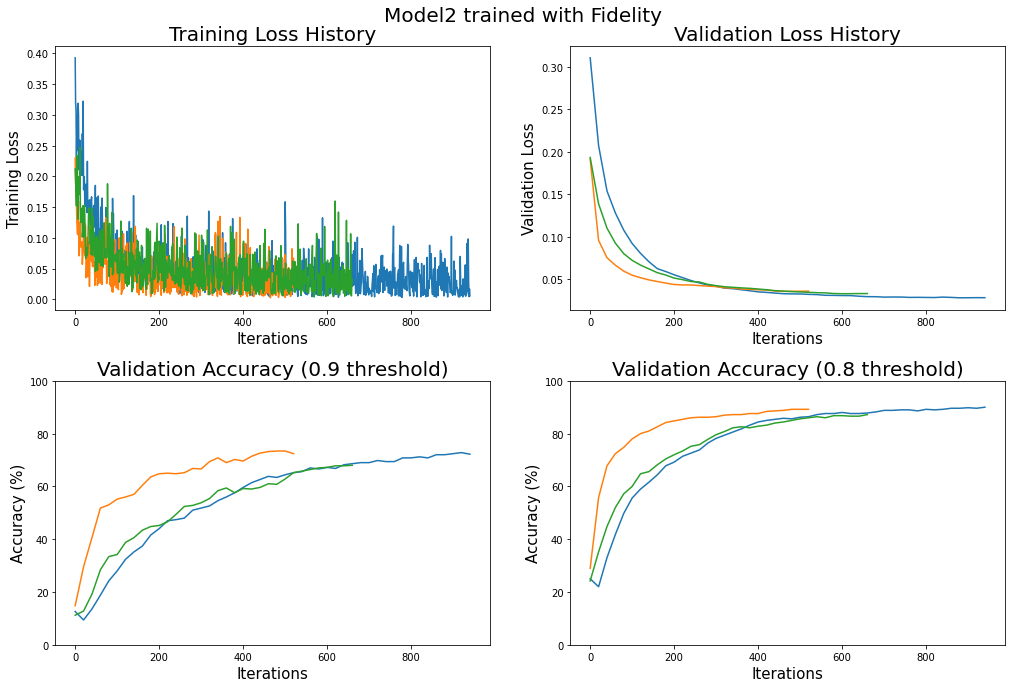

In [15]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.tight_layout(pad=5.0)
fig.suptitle("Model2 trained with Fidelity").set_fontsize(20)
ax1.plot(range(len(loss_history1)), loss_history1, range(len(loss_history2)), loss_history2, range(len(loss_history3)), loss_history3)
ax1.set_title("Training Loss History").set_fontsize(20)
ax1.set_xlabel("Iterations").set_fontsize(15)
ax1.set_ylabel("Training Loss").set_fontsize(15)
ax2.plot(np.array(range(len(validation_loss_history1))) * 20, validation_loss_history1, np.array(range(len(validation_loss_history2))) * 20, validation_loss_history2, np.array(range(len(validation_loss_history3))) * 20, validation_loss_history3)
ax2.set_title("Validation Loss History").set_fontsize(20)
ax2.set_xlabel("Iterations").set_fontsize(15)
ax2.set_ylabel("Validation Loss").set_fontsize(15)
ax3.plot(np.array(range(len(validation_accuracy90_history1))) * 20, validation_accuracy90_history1, np.array(range(len(validation_accuracy90_history2))) * 20, validation_accuracy90_history2, np.array(range(len(validation_accuracy90_history3))) * 20, validation_accuracy90_history3)
ax3.set_title("Validation Accuracy (0.9 threshold)").set_fontsize(20)
ax3.set_xlabel("Iterations").set_fontsize(15)
ax3.set_ylabel("Accuracy (%)").set_fontsize(15)
ax3.set_ylim(0, 100)
ax4.plot(np.array(range(len(validation_accuracy80_history1))) * 20, validation_accuracy80_history1, np.array(range(len(validation_accuracy80_history2))) * 20, validation_accuracy80_history2, np.array(range(len(validation_accuracy80_history3))) * 20, validation_accuracy80_history3)
ax4.set_title("Validation Accuracy (0.8 threshold)").set_fontsize(20)
ax4.set_xlabel("Iterations").set_fontsize(15)
ax4.set_ylabel("Accuracy (%)").set_fontsize(15)
ax4.set_ylim(0, 100)

print("Experiment1\n")
print("---------------")
print(f"Test Loss: {Test_loss1}\n")
print(f"Test Accuracy (0.9): {Test_Accuracy90_1}\n")
print(f"Test Accuracy (0.8): {Test_Accuracy80_1}\n")

print("Experiment2\n")
print("---------------")
print(f"Test Loss: {Test_loss2}\n")
print(f"Test Accuracy (0.9): {Test_Accuracy90_2}\n")
print(f"Test Accuracy (0.8): {Test_Accuracy80_2}\n")

print("Experiment3\n")
print("---------------")
print(f"Test Loss: {Test_loss3}\n")
print(f"Test Accuracy (0.9): {Test_Accuracy90_3}\n")
print(f"Test Accuracy (0.8): {Test_Accuracy80_3}\n")

In [12]:
name1 = "/Users/tak/Github/QEmbedding/Results/Experiment1/Model2_Fidelity.pt"
name2 = "/Users/tak/Github/QEmbedding/Results/Experiment2/Model2_Fidelity.pt"
name3 = "/Users/tak/Github/QEmbedding/Results/Experiment3/Model2_Fidelity.pt"
names = [name1, name2, name3]

for i, name in enumerate(names):
    TraceModel = Hybrid_nn.get_model("DistanceModel2_Trace")
    HSModel = Hybrid_nn.get_model("DistanceModel2_HS")
    TraceModel.load_state_dict(torch.load(name, map_location=torch.device('cpu')))
    HSModel.load_state_dict(torch.load(name, map_location=torch.device('cpu')))
    with torch.no_grad():
        trace_distance = TraceModel(X1_test, X0_test)
        HS_distance = HSModel(X1_test, X0_test)
    print(f"Experiment{i+1}: Trace Distance of test data is {-1 * trace_distance}\n")
    print(f"Experiment{i+1}: Hilbert Schmidt Distance of test data is {-1 * HS_distance}\n")

Experiment1: Trace Distance of test data is 0.9168829321861267

Experiment1: Hilbert Schmidt Distance of test data is 0.3931874930858612

Experiment2: Trace Distance of test data is 0.9288663864135742

Experiment2: Hilbert Schmidt Distance of test data is 0.4022062420845032

Experiment3: Trace Distance of test data is 0.9059054851531982

Experiment3: Hilbert Schmidt Distance of test data is 0.3799024224281311



# 2.4. Model2 with Hilber-Schmidt inner product

In [27]:
loss_history1 = np.array([0.24654002487659454, 0.19100074470043182, 0.2765905261039734, 0.22158530354499817, 0.2371564358472824, 0.24580775201320648, 0.2859034538269043, 0.14449067413806915, 0.25357770919799805, 0.18466384708881378, 0.26457348465919495, 0.17470614612102509, 0.2234892100095749, 0.11971765011548996, 0.20378577709197998, 0.12904000282287598, 0.17916034162044525, 0.15020190179347992, 0.11611060798168182, 0.15326277911663055, 0.09745647013187408, 0.16932189464569092, 0.14605578780174255, 0.1764022558927536, 0.11160936206579208, 0.10238509625196457, 0.13729098439216614, 0.2083527147769928, 0.126811683177948, 0.0960993766784668, 0.09201124310493469, 0.12914758920669556, 0.06168629601597786, 0.1441800743341446, 0.10794038325548172, 0.10956639796495438, 0.09155029058456421, 0.07264290004968643, 0.08272799104452133, 0.113175168633461, 0.05837013199925423, 0.0859493836760521, 0.07252764701843262, 0.11532937735319138, 0.031304195523262024, 0.10713649541139603, 0.08284607529640198, 0.0967286005616188, 0.07489568740129471, 0.09215651452541351, 0.05555193871259689, 0.0745663270354271, 0.10105856508016586, 0.07458998262882233, 0.03311533480882645, 0.04776232689619064, 0.06837096810340881, 0.07040680944919586, 0.058857884258031845, 0.06831500679254532, 0.11079967021942139, 0.03863319754600525, 0.08212997019290924, 0.05559249594807625, 0.0897829607129097, 0.06426320225000381, 0.08042183518409729, 0.04870251566171646, 0.08005360513925552, 0.05624299868941307, 0.056860387325286865, 0.06590096652507782, 0.06756936013698578, 0.12555132806301117, 0.03022584319114685, 0.0803060308098793, 0.12298761308193207, 0.054376792162656784, 0.07217657566070557, 0.057195212692022324, 0.08134578168392181, 0.0414162240922451, 0.09266548603773117, 0.06840668618679047, 0.05991246923804283, 0.07788313925266266, 0.054153479635715485, 0.08437623828649521, 0.03319723531603813, 0.024883734062314034, 0.05790127441287041, 0.058634933084249496, 0.06933914124965668, 0.04583500698208809, 0.08643818646669388, 0.11585862189531326, 0.03535480424761772, 0.06411033123731613, 0.016278449445962906, 0.0353224091231823, 0.041525792330503464, 0.05691063776612282, 0.037316787987947464, 0.040650177747011185, 0.009716425091028214, 0.056441083550453186, 0.04509098082780838, 0.023211296647787094, 0.024092990905046463, 0.019913163036108017, 0.0524839386343956, 0.045126158744096756, 0.07970816642045975, 0.060619939118623734, 0.01566126197576523, 0.10482866317033768, 0.021704521030187607, 0.07838154584169388, 0.05110135301947594, 0.03356189280748367, 0.014982054010033607, 0.06502038985490799, 0.04251116141676903, 0.05904293805360794, 0.04741512984037399, 0.02055523358285427, 0.05535675957798958, 0.0600714385509491, 0.050222449004650116, 0.049613285809755325, 0.030344940721988678, 0.013869330286979675, 0.02505338564515114, 0.03064390830695629, 0.04061581566929817, 0.05295469984412193, 0.03906042128801346, 0.009465287439525127, 0.08038834482431412, 0.020835818722844124, 0.08235479146242142, 0.021904753521084785, 0.012527666054666042, 0.03375530615448952, 0.04915266111493111, 0.022989606484770775, 0.018802259117364883, 0.05362822487950325, 0.07090567797422409, 0.10946391522884369, 0.023610569536685944, 0.011392960324883461, 0.09796072542667389, 0.06274878978729248, 0.04045111685991287, 0.021800078451633453, 0.03624444454908371, 0.026443839073181152, 0.016287893056869507, 0.010562186129391193, 0.0205368809401989, 0.01902131550014019, 0.04488428309559822, 0.032108552753925323, 0.08240574598312378, 0.048592131584882736, 0.07988300174474716, 0.060967881232500076, 0.01208612322807312, 0.06765422970056534, 0.09272099286317825, 0.04028874263167381, 0.049185995012521744, 0.05834018066525459, 0.026075266301631927, 0.07253361493349075, 0.012593009509146214, 0.014373074285686016, 0.03783164918422699, 0.05374404415488243, 0.01318877562880516, 0.08722207695245743, 0.006220224313437939, 0.08999056369066238, 0.029391519725322723, 0.048320140689611435, 0.035929124802351, 0.045892782509326935, 0.07253812253475189, 0.08764567226171494, 0.08421193063259125, 0.044696759432554245, 0.022006582468748093, 0.015381806530058384, 0.03968731686472893, 0.010948197916150093, 0.04097612947225571, 0.07444541901350021, 0.031531237065792084, 0.08168362081050873, 0.11861947923898697, 0.026819488033652306, 0.05402349680662155, 0.008739289827644825, 0.03310247138142586, 0.051623497158288956, 0.029443681240081787, 0.03538595885038376, 0.09154954552650452, 0.05903477966785431, 0.050055645406246185, 0.07693961262702942, 0.04072289541363716, 0.07347770780324936, 0.020923728123307228, 0.020472390577197075, 0.05421498790383339, 0.065717913210392, 0.0845896303653717, 0.018391067162156105, 0.06251625716686249, 0.02516625076532364, 0.05702432617545128, 0.05560338497161865, 0.023588968440890312, 0.03270438686013222, 0.027460670098662376, 0.010777666233479977, 0.01919681951403618, 0.03974409028887749, 0.06225040927529335, 0.028644070029258728, 0.00982004962861538, 0.04270005226135254, 0.02331896685063839, 0.030032942071557045, 0.04390812665224075, 0.01646740920841694, 0.009272032417356968, 0.041439395397901535, 0.00422529736533761, 0.06515806168317795, 0.027051210403442383, 0.031060954555869102, 0.0197503212839365, 0.0501074381172657, 0.06683480739593506, 0.022526370361447334, 0.011435319669544697, 0.01010038796812296, 0.03860756754875183, 0.04151395708322525, 0.05946214497089386, 0.017195293679833412, 0.08212220668792725, 0.061435163021087646, 0.11129050701856613, 0.028257455676794052, 0.0463813878595829, 0.009869219735264778, 0.13421183824539185, 0.04652390256524086, 0.024431904777884483, 0.010409974493086338, 0.024074925109744072, 0.017716407775878906, 0.032578159123659134, 0.028048954904079437, 0.01960090920329094, 0.008389533497393131, 0.06777691096067429, 0.03802216798067093, 0.056175779551267624, 0.011789209209382534, 0.0504729263484478, 0.028149351477622986, 0.05177628993988037, 0.01907980628311634, 0.054482411593198776, 0.01675797626376152, 0.021523628383874893, 0.059091661125421524, 0.00583350146189332, 0.038035277277231216, 0.022909631952643394, 0.04826486110687256, 0.018008699640631676, 0.025171561166644096, 0.017245104536414146, 0.02732294425368309, 0.04886595532298088, 0.07001449912786484, 0.018330181017518044, 0.014615478925406933, 0.007301999721676111, 0.05515335500240326, 0.013680526055395603, 0.0353633314371109, 0.011151628568768501, 0.01647643744945526, 0.021639784798026085, 0.07188348472118378, 0.04630184918642044, 0.059739820659160614, 0.025706080719828606, 0.03747086971998215, 0.02806972526013851, 0.009652758948504925, 0.07972592115402222, 0.026644881814718246, 0.01509373914450407, 0.03537468612194061, 0.043834831565618515, 0.07158213108778, 0.059318941086530685, 0.06835822761058807, 0.016671285033226013, 0.020070714876055717, 0.039427127689123154, 0.06847115606069565, 0.017590610310435295, 0.010618556290864944, 0.02215401828289032, 0.028386663645505905, 0.12265198677778244, 0.028106460347771645, 0.006536358036100864, 0.008493722416460514, 0.00852398294955492, 0.05078224092721939, 0.013050446286797523, 0.019688677042722702, 0.020418167114257812, 0.008978024125099182, 0.03719158470630646, 0.04778582602739334, 0.012932936660945415, 0.013984156772494316, 0.013329834677278996, 0.015918483957648277, 0.057834796607494354, 0.013058730401098728, 0.03899194672703743, 0.058385398238897324, 0.05469683185219765, 0.04590074345469475, 0.0443602092564106, 0.03458379581570625, 0.07046710699796677, 0.01366395689547062, 0.0058755213394761086, 0.04553694650530815, 0.05486674606800079, 0.004091005772352219, 0.031924083828926086, 0.03848430514335632, 0.049532774835824966, 0.005407905671745539, 0.029200544580817223, 0.05957002565264702, 0.006792603991925716, 0.01058016438037157, 0.052017465233802795, 0.017777645960450172, 0.035979341715574265, 0.015935271978378296, 0.02719925530254841, 0.00428185798227787, 0.011557027697563171, 0.02045593224465847, 0.05432230979204178, 0.07383853197097778, 0.0300862118601799, 0.021407250314950943, 0.041000112891197205, 0.005455691833049059, 0.04951726645231247, 0.019909899681806564, 0.07266267389059067, 0.012317227199673653, 0.024008307605981827, 0.004857322666794062, 0.007886926643550396, 0.049863118678331375, 0.013741733506321907, 0.09162436425685883, 0.006268216762691736, 0.06378418952226639, 0.056172583252191544, 0.006452902220189571, 0.03731071949005127, 0.020321473479270935, 0.0397476963698864, 0.04394412785768509, 0.024634238332509995, 0.03641772270202637, 0.008070302195847034, 0.009241165593266487, 0.007881606929004192, 0.01866840571165085, 0.0029265403281897306, 0.021390967071056366, 0.08118240535259247, 0.03595276176929474, 0.04145225137472153, 0.06587426364421844, 0.0876288190484047, 0.15115642547607422, 0.03801649063825607, 0.004582264926284552, 0.026972539722919464, 0.01430305652320385, 0.07347583025693893, 0.05505257472395897, 0.0065268585458397865, 0.011167995631694794, 0.003695719176903367, 0.03980069234967232, 0.053299129009246826, 0.0705292597413063, 0.021792186424136162, 0.008369890041649342, 0.009731080383062363, 0.034422725439071655, 0.0027987780049443245, 0.019968181848526, 0.03205004334449768, 0.012138530611991882, 0.025117987766861916, 0.03936295211315155, 0.05979996547102928, 0.07917080074548721, 0.010947478003799915, 0.01690291054546833, 0.013097723014652729, 0.015212048776447773, 0.045188017189502716, 0.005028483923524618, 0.026879992336034775, 0.006013340782374144, 0.09253682941198349, 0.014167174696922302, 0.012928287498652935, 0.03287288919091225, 0.0677715390920639, 0.01855527050793171, 0.03436332568526268, 0.04598454385995865, 0.04790712147951126, 0.005195434205234051, 0.03339334577322006, 0.03727854788303375, 0.08060989528894424, 0.006445871666073799, 0.03834348917007446, 0.030290018767118454, 0.013019230216741562, 0.018629008904099464, 0.017853429540991783, 0.051011305302381516, 0.014612378552556038, 0.009888147935271263, 0.08829379826784134, 0.03306201472878456, 0.08858731389045715, 0.016982614994049072, 0.027218924835324287, 0.013157225213944912, 0.0027473883237689734, 0.011552003212273121, 0.011059915646910667, 0.041651904582977295, 0.03979289531707764, 0.05085916817188263, 0.04090259596705437, 0.028423788025975227, 0.009570319205522537, 0.07197894155979156, 0.04713581129908562, 0.008708531968295574, 0.045281391590833664, 0.00617810757830739, 0.023684650659561157, 0.027386333793401718, 0.04924638196825981, 0.04356076195836067, 0.06989915668964386, 0.003610176034271717, 0.04193863645195961, 0.042996473610401154, 0.00488233333453536, 0.044771458953619, 0.021917762234807014, 0.006202593445777893, 0.002398551907390356, 0.0316605381667614, 0.08261227607727051, 0.03553790599107742, 0.00903086643666029, 0.02234131097793579, 0.010092098265886307, 0.031477075070142746, 0.00805684644728899, 0.03390507400035858, 0.023534897714853287, 0.040234263986349106, 0.007189736235886812, 0.006693837698549032, 0.03128150850534439, 0.05055956169962883, 0.04442138224840164, 0.03466759994626045, 0.006912877317517996, 0.015254227444529533, 0.048854339867830276, 0.04429600015282631, 0.05146471783518791, 0.0445912629365921, 0.08400920778512955, 0.007153020706027746, 0.00956717412918806])
loss_history2 = np.array([0.4901629388332367, 0.4924178123474121, 0.2653379440307617, 0.34916892647743225, 0.3425305187702179, 0.2952871322631836, 0.27567410469055176, 0.3371867537498474, 0.2580615282058716, 0.27522262930870056, 0.27400749921798706, 0.2026774287223816, 0.30788901448249817, 0.2627187967300415, 0.22880114614963531, 0.230738565325737, 0.24221573770046234, 0.2897462844848633, 0.22911196947097778, 0.1827247589826584, 0.19257579743862152, 0.1595640480518341, 0.20906396210193634, 0.18119049072265625, 0.2087848037481308, 0.11078932881355286, 0.10789076238870621, 0.16626034677028656, 0.13846440613269806, 0.16070276498794556, 0.1140870526432991, 0.14848065376281738, 0.09966777265071869, 0.09236560761928558, 0.1147952452301979, 0.10764577984809875, 0.14927949011325836, 0.07994493842124939, 0.11836298555135727, 0.11091392487287521, 0.0938960611820221, 0.09541057050228119, 0.09457217901945114, 0.09096414595842361, 0.049736928194761276, 0.10195960849523544, 0.053969211876392365, 0.04600008949637413, 0.0371270589530468, 0.07273092865943909, 0.10941579937934875, 0.06028245761990547, 0.11433538049459457, 0.04417981207370758, 0.0806066244840622, 0.029485410079360008, 0.07536664605140686, 0.08894918113946915, 0.08199335634708405, 0.11163786053657532, 0.05542224273085594, 0.063039131462574, 0.058191437274217606, 0.11905471235513687, 0.06171086058020592, 0.0658947229385376, 0.08193443715572357, 0.05001873895525932, 0.07539307326078415, 0.0843934640288353, 0.03005412593483925, 0.02899741195142269, 0.032143380492925644, 0.05490172281861305, 0.07962363213300705, 0.05165425315499306, 0.03371083736419678, 0.03921486809849739, 0.0702146515250206, 0.026449432596564293, 0.05411912500858307, 0.049127258360385895, 0.06594856083393097, 0.07391508668661118, 0.09144210815429688, 0.052336435765028, 0.03434344381093979, 0.050716474652290344, 0.06058373302221298, 0.020369095727801323, 0.045923929661512375, 0.036862459033727646, 0.05611367151141167, 0.030455492436885834, 0.07192336022853851, 0.04841829091310501, 0.09863951802253723, 0.036533989012241364, 0.03198148310184479, 0.061236776411533356, 0.05255961790680885, 0.058366116136312485, 0.04245345667004585, 0.043430395424366, 0.049545273184776306, 0.0410441979765892, 0.01502157561480999, 0.051079537719488144, 0.016637656837701797, 0.01789896748960018, 0.04836210608482361, 0.01276768371462822, 0.030807597562670708, 0.10871268808841705, 0.027689523994922638, 0.039888788014650345, 0.029924146831035614, 0.1026095375418663, 0.04356411471962929, 0.018217716366052628, 0.04744558408856392, 0.009563412517309189, 0.03397668898105621, 0.02645166777074337, 0.03846200928092003, 0.06453241407871246, 0.0320647694170475, 0.04933466762304306, 0.050072625279426575, 0.023043422028422356, 0.05992686748504639, 0.008466671220958233, 0.11516519635915756, 0.0329841785132885, 0.037775568664073944, 0.06495583057403564, 0.014361396431922913, 0.016671277582645416, 0.044179074466228485, 0.12273666262626648, 0.014662493951618671, 0.07397369295358658, 0.035681694746017456, 0.029966896399855614, 0.009969735518097878, 0.06173526495695114, 0.021677691489458084, 0.008609101176261902, 0.031130630522966385, 0.06314035505056381, 0.043442610651254654, 0.04916290566325188, 0.05078890547156334, 0.06434162706136703, 0.06751393526792526, 0.09798131138086319, 0.024609344080090523, 0.057788752019405365, 0.02539154887199402, 0.0737251341342926, 0.07028334587812424, 0.08191017806529999, 0.013213363476097584, 0.04026522487401962, 0.0534563809633255, 0.04286377504467964, 0.03480805456638336, 0.05083926022052765, 0.028759565204381943, 0.0822235643863678, 0.0673067718744278, 0.09957940131425858, 0.03368976712226868, 0.10473126173019409, 0.04036629572510719, 0.01352416630834341, 0.026291122660040855, 0.032737359404563904, 0.07428368926048279, 0.028281735256314278, 0.01020114403218031, 0.018593979999423027, 0.03569530323147774, 0.048454027622938156, 0.03362799063324928, 0.046129267662763596, 0.01634516939520836, 0.018611958250403404, 0.05366171896457672, 0.011840672232210636, 0.07505052536725998, 0.032822273671627045, 0.015269238501787186, 0.018295882269740105, 0.040852759033441544, 0.0077749560587108135, 0.04483095183968544, 0.021055251359939575, 0.08095929771661758, 0.04553718492388725, 0.09339990466833115, 0.09732148051261902, 0.013422583229839802, 0.05229995772242546, 0.025703897699713707, 0.03507377207279205, 0.025773707777261734, 0.09170253574848175, 0.028407055884599686, 0.017583398148417473, 0.019317694008350372, 0.06627604365348816, 0.013291765004396439, 0.0471421554684639, 0.007571905851364136, 0.11483803391456604, 0.056177642196416855, 0.013064543716609478, 0.04422067105770111, 0.06305396556854248, 0.048360805958509445, 0.009080026298761368, 0.02071286365389824, 0.010724472813308239, 0.1062917411327362, 0.020208129659295082, 0.037009935826063156, 0.023118972778320312, 0.02224482037127018, 0.055816650390625, 0.05657365173101425, 0.042950838804244995, 0.0376824215054512, 0.0052099693566560745, 0.05467849224805832, 0.008387094363570213, 0.015893766656517982, 0.02170223370194435, 0.07746279239654541, 0.08127358555793762, 0.011850481852889061, 0.049733977764844894, 0.07248493283987045, 0.14627671241760254, 0.011105191893875599, 0.04705111309885979, 0.01664920710027218, 0.0629449263215065, 0.08099985122680664, 0.06178607419133186, 0.034922465682029724, 0.07524821907281876, 0.006205314304679632, 0.013271450996398926, 0.0286930650472641, 0.010377619415521622, 0.052247948944568634, 0.010248951613903046, 0.013810085132718086, 0.0692678838968277, 0.0445440299808979, 0.03815706819295883, 0.018707269802689552, 0.0181634072214365, 0.03060716576874256, 0.049492157995700836, 0.011576924473047256, 0.021084332838654518, 0.025043239817023277, 0.1237993985414505, 0.0457206666469574, 0.03425798937678337, 0.029203854501247406, 0.05735393241047859, 0.05174112319946289, 0.01551790814846754, 0.055954914540052414, 0.12982571125030518, 0.01855410821735859, 0.007836805656552315, 0.0842120423913002, 0.06961970776319504, 0.036647897213697433, 0.056308720260858536, 0.08160846680402756, 0.052899740636348724, 0.022363588213920593, 0.04674817994236946, 0.00601396057754755, 0.005737319588661194, 0.008261377923190594, 0.09152542054653168, 0.004116175230592489, 0.09957528114318848, 0.07521574199199677, 0.02677159570157528, 0.010983838699758053, 0.058652810752391815, 0.08596229553222656, 0.023411639034748077, 0.03710448369383812, 0.02146722562611103, 0.038039498031139374, 0.08751172572374344, 0.013300864025950432, 0.11652233451604843, 0.015665367245674133, 0.048590581864118576, 0.06805914640426636, 0.03204061836004257, 0.04074275866150856, 0.02904837764799595, 0.011620908975601196, 0.14087653160095215, 0.05633921921253204, 0.15368522703647614, 0.047405906021595, 0.062392089515924454, 0.026906611397862434, 0.08040767163038254, 0.039528943598270416, 0.07529041916131973, 0.054811716079711914, 0.04316771402955055, 0.025585301220417023, 0.012513279914855957, 0.01418875902891159, 0.08018018305301666, 0.01537497341632843, 0.01771184429526329, 0.00506853312253952, 0.06924334168434143, 0.07803718745708466, 0.03738619014620781, 0.007187537383288145, 0.061209648847579956, 0.09686136990785599, 0.00457768002524972, 0.009648340754210949, 0.04837409779429436, 0.04117024317383766, 0.03322301432490349, 0.06886529922485352, 0.036382559686899185, 0.036504533141851425, 0.046218812465667725, 0.032028451561927795, 0.035901281982660294, 0.018499068915843964, 0.0049053821712732315, 0.00979535561054945, 0.018692927435040474, 0.028785012662410736, 0.06649231910705566, 0.06546726822853088, 0.005206432193517685, 0.0263185016810894, 0.028479384258389473, 0.02350720763206482, 0.03426284343004227, 0.011917678639292717, 0.08351512998342514, 0.022534260526299477, 0.10776176303625107, 0.00778563367202878, 0.04255172610282898, 0.03901547193527222, 0.04871136695146561, 0.06095200031995773, 0.015858575701713562, 0.10023286938667297, 0.047480881214141846, 0.0033463984727859497, 0.04040060564875603, 0.018780328333377838, 0.048949453979730606, 0.05923159793019295, 0.10139163583517075, 0.014874963089823723, 0.06884834170341492, 0.013001627288758755, 0.005589871201664209, 0.03234665468335152, 0.00511888787150383, 0.003908888436853886, 0.022969534620642662, 0.08126252889633179, 0.056529462337493896, 0.020324647426605225, 0.05165063589811325, 0.05232354626059532, 0.015901438891887665, 0.002221520058810711, 0.006968253292143345, 0.00745433708652854, 0.010376901365816593, 0.020312637090682983, 0.06847157329320908, 0.05751148611307144, 0.0339842364192009, 0.005748286843299866, 0.012354712001979351, 0.016356024891138077, 0.029393769800662994, 0.012337024323642254, 0.017700884491205215, 0.06314916163682938, 0.010348877869546413, 0.03815719112753868, 0.005629465449601412, 0.02305305190384388, 0.0599479041993618, 0.07610028237104416, 0.06818930804729462, 0.04186375066637993, 0.058797165751457214, 0.008924107067286968, 0.00842801108956337, 0.005955392029136419, 0.006214997731149197, 0.01606982760131359, 0.00691145658493042, 0.012495944276452065, 0.0724666640162468, 0.025680851191282272, 0.08267238736152649, 0.005581521894782782, 0.03180086985230446, 0.10554531216621399, 0.01655963435769081, 0.0042074499651789665, 0.005811780691146851, 0.0073894914239645, 0.020383162423968315, 0.0875924676656723, 0.03417641296982765, 0.01067501399666071, 0.06082673743367195, 0.0051764510571956635, 0.028755417093634605, 0.03536670655012131, 0.051332633942365646, 0.0496365949511528, 0.01476244442164898, 0.06811278313398361, 0.0405171662569046, 0.058261021971702576, 0.02245270647108555, 0.011392241343855858, 0.034408945590257645, 0.007876861840486526, 0.06585464626550674, 0.014459112659096718, 0.03594711050391197, 0.013880884274840355, 0.0050151050090789795, 0.08741361647844315, 0.019418826326727867, 0.020732957869768143, 0.05598227307200432, 0.029909927397966385, 0.024613453075289726, 0.012862233445048332, 0.05394941568374634, 0.09131941944360733, 0.010279571637511253, 0.014969848096370697, 0.02699337713420391, 0.004042271990329027, 0.04476352408528328, 0.0367901511490345, 0.12693127989768982, 0.04207482188940048, 0.016312280669808388, 0.036325324326753616, 0.01900615356862545, 0.00699989078566432, 0.023786045610904694, 0.010395228862762451, 0.013585720211267471, 0.011328596621751785, 0.005195742938667536, 0.06314869970083237, 0.014467844739556313, 0.04538118839263916, 0.03767797350883484, 0.011782803572714329, 0.06218414753675461, 0.0536222867667675, 0.06521394848823547, 0.051216237246990204, 0.038719356060028076, 0.08254972100257874, 0.012323341332376003, 0.04989181458950043, 0.00827212817966938, 0.015141325071454048, 0.033210061490535736, 0.047270968556404114, 0.007713512517511845, 0.005983186420053244, 0.03343543782830238, 0.03192383050918579, 0.05001567676663399, 0.05165485292673111, 0.019786028191447258, 0.09074825048446655, 0.004242915194481611, 0.005860849283635616, 0.0018159307073801756, 0.0023949758615344763, 0.0027681998908519745, 0.020504288375377655, 0.010685121640563011, 0.0639231726527214, 0.01085684634745121, 0.015295583754777908, 0.010107440873980522, 0.018810290843248367, 0.008196758106350899, 0.08116013556718826, 0.03382766991853714, 0.012655489146709442, 0.03226679563522339, 0.055471982806921005, 0.01818202994763851, 0.006813273299485445, 0.05431126058101654, 0.0059607988223433495, 0.07642624527215958, 0.01761474646627903, 0.0336536169052124, 0.03858201950788498, 0.040558405220508575, 0.04160565882921219, 0.010114435106515884, 0.03527658060193062, 0.01443710271269083, 0.05849066749215126, 0.025219758972525597, 0.03593089058995247, 0.006527497433125973, 0.04137860983610153, 0.017932163551449776, 0.053351543843746185, 0.052237823605537415, 0.009956875815987587, 0.02275824174284935, 0.07042490690946579, 0.01585531048476696, 0.013717052526772022, 0.013783957809209824, 0.006964230444282293, 0.008595400489866734, 0.007757887709885836, 0.0117462994530797, 0.034987546503543854, 0.07533827424049377, 0.03294067457318306, 0.03010050766170025, 0.020742300897836685, 0.04666692018508911, 0.06109055504202843, 0.012422800995409489, 0.024852558970451355, 0.05379946529865265, 0.012282231822609901, 0.03254983574151993, 0.014422893524169922, 0.030352482572197914, 0.027081212028861046, 0.022443389520049095, 0.030807802453637123, 0.007395934779196978, 0.06433117389678955, 0.07728670537471771, 0.005097983870655298, 0.010546769015491009, 0.039509117603302, 0.060834627598524094, 0.04552213475108147, 0.025633417069911957, 0.06046602502465248, 0.016049610450863838, 0.02137744054198265, 0.00646245339885354, 0.028279908001422882, 0.026982707902789116, 0.06308475136756897, 0.03782009705901146, 0.012645312584936619, 0.003669560421258211, 0.05281148478388786, 0.04695965722203255, 0.010054883547127247, 0.01125252339988947, 0.028216183185577393, 0.020802104845643044, 0.0378851555287838, 0.04250575974583626, 0.007454194128513336, 0.027942359447479248, 0.01741240918636322, 0.015137466602027416, 0.028257451951503754, 0.07339148223400116, 0.007681517396122217, 0.04149550944566727, 0.04070140793919563, 0.0353841669857502, 0.013870497234165668, 0.022763080894947052, 0.023750556632876396, 0.0447312667965889, 0.03503311425447464, 0.03702901676297188, 0.01586044766008854, 0.003947395831346512, 0.08029574155807495, 0.004832414444535971, 0.029235849156975746, 0.006863165181130171, 0.06734968721866608, 0.021846536546945572, 0.003892317647114396, 0.01302893366664648, 0.09273437410593033, 0.04129137098789215, 0.03217100352048874, 0.049488529562950134, 0.017640532925724983, 0.024474598467350006, 0.01290630828589201, 0.01111447624862194, 0.05806228518486023, 0.05195648595690727, 0.010362460277974606, 0.09965386986732483, 0.07158228754997253, 0.029666000977158546, 0.02592826634645462, 0.028552789241075516, 0.05864746496081352, 0.043605025857686996, 0.033159781247377396, 0.06455033272504807, 0.06715364754199982, 0.012603560462594032, 0.008619803003966808, 0.03092160075902939, 0.007326862774789333, 0.12348031997680664, 0.05803552642464638, 0.12873229384422302, 0.007176221814006567, 0.02939043939113617, 0.04597395658493042, 0.008308948017656803, 0.007329004816710949, 0.023879515007138252, 0.012639079242944717, 0.011770416982471943, 0.06591178476810455, 0.05193827673792839, 0.016942083835601807, 0.040423039346933365, 0.01092491578310728, 0.056645240634679794, 0.03334122523665428, 0.0017872613389045, 0.031147876754403114, 0.04116204008460045, 0.021379483863711357, 0.023963971063494682, 0.03509204834699631, 0.048655882477760315, 0.0386749729514122, 0.042380817234516144, 0.034935787320137024, 0.04282218962907791, 0.024329153820872307, 0.008092467673122883, 0.002106216736137867, 0.022242039442062378, 0.04042414203286171, 0.08131082355976105, 0.025517592206597328, 0.05757859721779823, 0.042932070791721344, 0.044823434203863144, 0.011888415552675724, 0.0945385992527008, 0.01588175818324089, 0.038214653730392456, 0.005407532211393118, 0.0475233793258667, 0.009021918289363384, 0.05267512798309326, 0.007504778448492289, 0.05276273936033249, 0.04945315420627594, 0.044896721839904785, 0.04108815640211105, 0.03785340487957001, 0.023326288908720016, 0.06500720977783203, 0.013843516819179058, 0.013739991001784801, 0.0895330086350441, 0.016454113647341728, 0.00561654195189476, 0.02424163743853569, 0.003923745825886726, 0.03827955946326256, 0.060754988342523575, 0.023422565311193466, 0.05769940838217735, 0.021639470010995865, 0.020518608391284943, 0.044992584735155106, 0.02458249032497406, 0.014552488923072815, 0.0110325263813138, 0.0049077426083385944, 0.11426661908626556, 0.025943338871002197, 0.03801516816020012, 0.04701243340969086, 0.04868173971772194, 0.002815414685755968, 0.07895791530609131, 0.04754156619310379, 0.009245071560144424, 0.06318536400794983, 0.05529124289751053, 0.022088266909122467, 0.014134498313069344, 0.05043383315205574, 0.007584334816783667, 0.004259875975549221, 0.1045762225985527, 0.0036159807350486517, 0.005851794499903917, 0.026079291477799416, 0.04809071496129036, 0.007183367852121592, 0.06509582698345184, 0.0203950684517622, 0.017729301005601883, 0.01634332165122032, 0.020829899236559868, 0.006543299183249474, 0.0027032792568206787, 0.029253050684928894, 0.07381919771432877, 0.027289733290672302, 0.006482737138867378, 0.04203997179865837, 0.05704311281442642, 0.08575157076120377, 0.049349263310432434, 0.036877505481243134, 0.009901748970150948, 0.010306654497981071, 0.004656252451241016, 0.03561382368206978, 0.029975568875670433, 0.035774681717157364, 0.0069257281720638275, 0.005876597017049789, 0.07400674372911453, 0.032681189477443695, 0.0872274786233902, 0.0065841167233884335, 0.01830790564417839, 0.03304470330476761, 0.008966020308434963, 0.06280048191547394, 0.04525197297334671, 0.01589266210794449, 0.041897352784872055, 0.0020499825477600098, 0.00260691880248487, 0.007112063001841307, 0.010302088223397732, 0.023377912119030952, 0.053192414343357086, 0.03731139749288559, 0.08289480954408646, 0.11096569150686264, 0.003072307677939534, 0.025935867801308632, 0.010463341139256954, 0.024902956560254097, 0.06245226413011551, 0.02742254175245762, 0.009609820321202278, 0.07405878603458405, 0.01110778283327818, 0.014342118054628372, 0.020317258313298225, 0.02993682585656643, 0.00571660278365016, 0.08263049274682999, 0.012772321701049805, 0.010211682878434658, 0.027232451364398003, 0.05395560711622238, 0.024524923413991928, 0.005059169605374336, 0.026593241840600967, 0.004470104351639748, 0.023830506950616837, 0.006027065217494965, 0.04311538487672806, 0.029413439333438873, 0.12257502973079681, 0.02590665966272354, 0.01227305643260479, 0.06093974411487579, 0.03309524804353714, 0.009870380163192749, 0.003403482958674431, 0.04690571501851082, 0.014309725724160671, 0.002870042808353901, 0.021105093881487846, 0.03887718915939331, 0.008243536576628685, 0.05100042372941971, 0.010891957208514214, 0.03091331198811531, 0.004630608018487692, 0.011952046304941177, 0.05720505490899086, 0.0444500595331192, 0.050162628293037415, 0.012152168899774551, 0.0313013456761837, 0.003724462352693081, 0.019790558144450188, 0.04944600164890289, 0.016222156584262848, 0.022970756515860558, 0.011886355467140675, 0.042751092463731766, 0.0020751147530972958, 0.015177952125668526, 0.0033699534833431244, 0.022598380222916603, 0.029318176209926605, 0.06423985213041306, 0.01433600950986147, 0.012123147025704384, 0.03967048227787018, 0.026123153045773506, 0.040083739906549454, 0.05444517359137535, 0.023408755660057068, 0.008047210052609444, 0.00581711158156395, 0.0903296247124672, 0.014876562170684338, 0.042443495243787766, 0.03784016892313957, 0.011768960393965244, 0.028859583660960197, 0.004023857414722443, 0.0022918102331459522, 0.01864796131849289, 0.040158532559871674, 0.04304417967796326, 0.005779380444437265, 0.04446998983621597, 0.045830924063920975, 0.0047251274809241295, 0.006211346480995417, 0.06443159282207489, 0.07011014223098755, 0.0038661055732518435, 0.018131984397768974, 0.0021933403331786394, 0.012489626184105873, 0.017890997231006622, 0.016915524378418922, 0.08294351398944855, 0.0033408121671527624, 0.037399739027023315, 0.011991788633167744, 0.013486983254551888, 0.02173878625035286, 0.05398876219987869, 0.06367233395576477, 0.03822670131921768, 0.00958604458719492, 0.033476218581199646, 0.0007580059464089572, 0.047282397747039795, 0.06974231451749802, 0.05966033786535263, 0.02308044396340847, 0.03177246078848839, 0.02224469557404518, 0.05177728086709976, 0.006073816679418087, 0.0025585773400962353, 0.0169536080211401, 0.0042528728954494, 0.1409013867378235, 0.026495717465877533, 0.04755229502916336, 0.005636017303913832, 0.003593799192458391, 0.04710357263684273, 0.013441796414554119, 0.016629189252853394, 0.01684696227312088, 0.021955404430627823, 0.06333082914352417, 0.050984229892492294, 0.004452524706721306, 0.00732425507158041, 0.025258682668209076, 0.005305715836584568, 0.055018264800310135, 0.06324590742588043, 0.03898635506629944, 0.035667188465595245, 0.004862822592258453, 0.0024328725412487984, 0.08740633726119995, 0.07919126749038696, 0.045028090476989746, 0.01719297096133232, 0.01823287270963192, 0.016704555600881577, 0.04691909998655319, 0.018974119797348976, 0.0035681389272212982, 0.027108779177069664, 0.04292018711566925, 0.013543885201215744, 0.021096091717481613, 0.04141838848590851, 0.01152566447854042, 0.050652556121349335, 0.04889169707894325, 0.07374493777751923, 0.04128256067633629, 0.010162937454879284, 0.007285074796527624, 0.04124872758984566, 0.02873114123940468, 0.04739244282245636, 0.05049029365181923, 0.029202327132225037, 0.04938029125332832, 0.0025769134517759085, 0.03901766613125801, 0.012523825280368328, 0.06754308193922043, 0.060563020408153534, 0.040155861526727676, 0.06431394815444946, 0.029952092096209526, 0.03893429785966873, 0.056211765855550766, 0.010149948298931122, 0.10486733168363571, 0.0440385527908802, 0.0269809328019619, 0.034576550126075745, 0.036917708814144135, 0.01641777902841568, 0.016370723024010658, 0.0018758773803710938, 0.003931310493499041, 0.008863150142133236, 0.011949356645345688, 0.019232871010899544, 0.012760071083903313, 0.043412625789642334, 0.03314962610602379, 0.0024851381313055754, 0.05559137091040611, 0.00673417653888464, 0.03945426270365715, 0.06179653853178024, 0.09881056845188141, 0.015880601480603218, 0.04853672906756401, 0.012596242129802704, 0.011989360675215721, 0.02835441194474697, 0.027232885360717773, 0.03183487057685852, 0.049760717898607254, 0.026862982660531998, 0.0033925275783985853, 0.0325368233025074])
loss_history3 = np.array([0.18882419168949127, 0.19408009946346283, 0.2542986571788788, 0.1891123354434967, 0.17843112349510193, 0.18440482020378113, 0.16351737082004547, 0.17319774627685547, 0.16616380214691162, 0.09183837473392487, 0.17129988968372345, 0.11614533513784409, 0.15407250821590424, 0.07527574151754379, 0.12217889726161957, 0.17455154657363892, 0.13362333178520203, 0.13347607851028442, 0.14536349475383759, 0.10811758041381836, 0.09177763015031815, 0.13681438565254211, 0.10439148545265198, 0.1402186155319214, 0.09860135614871979, 0.0888531282544136, 0.06676412373781204, 0.07906799018383026, 0.09230361878871918, 0.061410874128341675, 0.08891129493713379, 0.07550016045570374, 0.06711794435977936, 0.04692445322871208, 0.09159866720438004, 0.09640603512525558, 0.07077662646770477, 0.06590148061513901, 0.04298999533057213, 0.025225957855582237, 0.03676661103963852, 0.09141568094491959, 0.03610001876950264, 0.04031111299991608, 0.06206085532903671, 0.09896336495876312, 0.05225887522101402, 0.1008666455745697, 0.08545023947954178, 0.05165192112326622, 0.10568299144506454, 0.026561997830867767, 0.046025075018405914, 0.06130094826221466, 0.11821039021015167, 0.10747212916612625, 0.05051758512854576, 0.10150160640478134, 0.05225541070103645, 0.03733956068754196, 0.05393489822745323, 0.06482744216918945, 0.0539449043571949, 0.09410539269447327, 0.05820552632212639, 0.023671066388487816, 0.06514967978000641, 0.091183602809906, 0.024453362450003624, 0.04031824320554733, 0.08310262858867645, 0.020845144987106323, 0.026333102956414223, 0.11203757673501968, 0.032435908913612366, 0.06795835494995117, 0.037494972348213196, 0.02316976897418499, 0.034313831478357315, 0.07429847866296768, 0.050252266228199005, 0.014574006199836731, 0.07400355488061905, 0.030533455312252045, 0.14669696986675262, 0.029115065932273865, 0.013784757815301418, 0.027613868936896324, 0.03961684927344322, 0.058339349925518036, 0.026201345026493073, 0.040836967527866364, 0.050986867398023605, 0.06763332337141037, 0.03987416997551918, 0.09338390827178955, 0.07089416682720184, 0.010025802999734879, 0.020671477541327477, 0.08203241229057312, 0.007827757857739925, 0.0614558570086956, 0.031403783708810806, 0.018541598692536354, 0.020701110363006592, 0.07851056754589081, 0.02301531285047531, 0.03818754851818085, 0.04275073856115341, 0.05767471715807915, 0.008465876802802086, 0.03228188306093216, 0.05351933836936951, 0.025181390345096588, 0.045398104935884476, 0.042207349091768265, 0.015123145654797554, 0.05402618646621704, 0.03719611465930939, 0.06464949250221252, 0.019198279827833176, 0.0442458912730217, 0.06183730810880661, 0.07889430224895477, 0.015920059755444527, 0.1522659808397293, 0.030232498422265053, 0.09578850865364075, 0.023408403620123863, 0.05866403877735138, 0.05320827290415764, 0.07419043034315109, 0.007114062085747719, 0.09485197067260742, 0.035842396318912506, 0.07926276326179504, 0.03990674391388893, 0.03847554326057434, 0.07944810390472412, 0.13200172781944275, 0.014050092548131943, 0.0325477309525013, 0.06345174461603165, 0.02250078320503235, 0.1039477288722992, 0.037738099694252014, 0.06698824465274811, 0.04249831289052963, 0.0165068618953228, 0.04885011166334152, 0.05481582134962082, 0.05096842348575592, 0.025204245001077652, 0.03917959704995155, 0.006039045751094818, 0.0500662736594677, 0.034100618213415146, 0.006114172749221325, 0.06407985836267471, 0.014281007461249828, 0.04528826102614403, 0.03359796106815338, 0.009113069623708725, 0.02826647460460663, 0.04575444757938385, 0.07593227177858353, 0.01649552769958973, 0.011912377551198006, 0.11367171257734299, 0.027018632739782333, 0.03973907604813576, 0.04372725263237953, 0.01173369586467743, 0.07191799581050873, 0.01602819375693798, 0.029364721849560738, 0.04118965193629265, 0.04849877581000328, 0.014529344625771046, 0.02711149863898754, 0.06094501540064812, 0.005238096695393324, 0.016905885189771652, 0.01184361893683672, 0.027832774445414543, 0.042496226727962494, 0.017912134528160095, 0.010102865286171436, 0.02693759836256504, 0.05824662372469902, 0.008043406531214714, 0.06733539700508118, 0.010490651242434978, 0.011673417873680592, 0.031596384942531586, 0.02416456863284111, 0.027876529842615128, 0.07502885162830353, 0.011912130750715733, 0.07709463685750961, 0.11033928394317627, 0.06788188219070435, 0.022994553670287132, 0.04550960287451744, 0.06646213680505753, 0.10351965576410294, 0.06006212905049324, 0.011188163422048092, 0.01967334747314453, 0.03343398869037628, 0.08369573205709457, 0.07389429956674576, 0.010116508230566978, 0.0273321233689785, 0.003938285633921623, 0.026847416535019875, 0.0569167360663414, 0.0421619787812233, 0.049525048583745956, 0.04243231564760208, 0.04912327975034714, 0.05244557559490204, 0.06869017332792282, 0.014654943719506264, 0.00891054980456829, 0.07704775035381317, 0.07468968629837036, 0.033101242035627365, 0.061348896473646164, 0.05821483954787254, 0.04264242947101593, 0.010567761026322842, 0.017277201637625694, 0.07456687837839127, 0.012884763069450855, 0.057995088398456573, 0.06784002482891083, 0.016779284924268723, 0.021276026964187622, 0.029854049906134605, 0.012737669982016087, 0.05596194043755531, 0.01597384363412857, 0.0453304760158062, 0.0852007195353508, 0.04293983057141304, 0.014630643650889397, 0.042230717837810516, 0.0928422212600708, 0.028279857710003853, 0.019701851531863213, 0.060904767364263535, 0.02650429867208004, 0.011249644681811333, 0.008255168795585632, 0.048452991992235184, 0.035605158656835556, 0.05619621276855469, 0.012799558229744434, 0.06700081378221512, 0.03473598137497902, 0.09666573256254196, 0.0497230626642704, 0.027282271534204483, 0.025938404724001884, 0.05236971750855446, 0.035224366933107376, 0.06638410687446594, 0.08062545955181122, 0.08774703741073608, 0.007345393765717745, 0.04976896196603775, 0.09961912035942078, 0.0875796303153038, 0.018601778894662857, 0.09566886723041534, 0.030179666355252266, 0.042380936443805695, 0.06250181794166565, 0.018726253882050514, 0.03846282884478569, 0.01602695696055889, 0.025592459365725517, 0.014274242334067822, 0.028237661346793175, 0.009496557526290417, 0.04467897489666939, 0.016177164390683174, 0.056944262236356735, 0.016785919666290283, 0.023555027320981026, 0.01514946948736906, 0.013064633123576641, 0.00900878757238388, 0.022514708340168, 0.0643385574221611, 0.04368352144956589, 0.061980556696653366, 0.013199610635638237, 0.06330910325050354, 0.06622502207756042, 0.04150770232081413, 0.012653944082558155, 0.03471171855926514, 0.010279609821736813, 0.008844899944961071, 0.0352763757109642, 0.0043984632939100266, 0.05750256031751633, 0.00999540090560913, 0.01214506383985281, 0.042584095150232315, 0.015284467488527298, 0.08286742866039276, 0.053115129470825195, 0.08439537137746811, 0.04123362526297569, 0.037428878247737885, 0.013357031159102917, 0.04522383585572243, 0.0499730110168457, 0.018243560567498207, 0.03605411574244499, 0.04528694972395897, 0.015571565367281437, 0.042232345789670944, 0.006880061700940132, 0.045054271817207336, 0.10014074295759201, 0.005606852006167173, 0.010142961516976357, 0.034926243126392365, 0.07764071226119995, 0.011955899186432362, 0.04721729829907417, 0.026386748999357224, 0.026614734902977943, 0.012386373244225979, 0.041307978332042694, 0.01798468455672264, 0.009395556524395943, 0.021186918020248413, 0.01692907325923443, 0.05390656366944313, 0.018508709967136383, 0.06554651260375977, 0.06795577704906464, 0.004615799058228731, 0.03487936034798622, 0.02387869544327259, 0.011724527925252914, 0.048517901450395584, 0.0438321977853775, 0.009891455061733723, 0.012289383448660374, 0.010602576658129692, 0.007598647847771645, 0.01758348010480404, 0.028995566070079803, 0.027722034603357315, 0.02984456531703472, 0.006699357647448778, 0.0684850737452507, 0.05034148693084717, 0.009347498416900635, 0.07222677022218704, 0.02301075868308544, 0.022253310307860374, 0.02654249593615532, 0.05792759358882904, 0.02106218785047531, 0.016134779900312424, 0.013263482600450516, 0.0200534388422966, 0.02768666483461857, 0.057537298649549484, 0.0360141322016716, 0.03615778684616089, 0.03302517905831337, 0.04293359816074371, 0.09573876857757568, 0.05585216358304024, 0.041994690895080566, 0.004654153250157833, 0.024355003610253334, 0.0712532252073288, 0.003785800188779831, 0.01665247231721878, 0.006652789190411568, 0.015223728492856026, 0.008381117135286331, 0.09298032522201538, 0.020677298307418823, 0.025517433881759644, 0.06602056324481964, 0.004958868958055973, 0.011309480294585228, 0.01199308130890131, 0.036013782024383545, 0.07730822265148163, 0.02503497712314129, 0.011070545762777328, 0.034326694905757904, 0.0621163435280323, 0.01635211519896984, 0.07457561045885086, 0.033580634742975235, 0.051215749233961105, 0.024622010067105293, 0.006244149524718523, 0.02601994201540947, 0.03199257701635361, 0.004690174479037523, 0.004119233228266239, 0.0054427278228104115, 0.004638116341084242, 0.024551700800657272, 0.03845817968249321, 0.008419493213295937, 0.02763763815164566, 0.04472160339355469, 0.08655599504709244, 0.06074846535921097, 0.041518859565258026, 0.007961119525134563, 0.021871475502848625, 0.062357015907764435, 0.048455409705638885, 0.03232520446181297, 0.042379505932331085, 0.032821785658597946, 0.025228001177310944, 0.06786259263753891, 0.0841115191578865, 0.05066170170903206, 0.008762326091527939, 0.06325376033782959, 0.046531300991773605, 0.04935656487941742, 0.02097625844180584, 0.06862816959619522, 0.07614404708147049, 0.13759809732437134, 0.034122124314308167, 0.019430795684456825, 0.042134854942560196, 0.05314736068248749, 0.006153937429189682, 0.012311813421547413, 0.1040380448102951, 0.005747608374804258, 0.009223501197993755, 0.011048798449337482, 0.07880859822034836, 0.05862213298678398, 0.0032057911157608032, 0.04606691747903824, 0.030053161084651947, 0.044394273310899734, 0.06319587677717209, 0.023239316418766975, 0.035349275916814804, 0.05692334100604057, 0.032339274883270264, 0.033095117658376694, 0.048888664692640305, 0.036274850368499756, 0.06075774133205414, 0.026406239718198776, 0.026336951181292534, 0.06274668872356415, 0.01837944984436035, 0.049614809453487396, 0.0753006860613823, 0.019095582887530327, 0.013299460522830486, 0.03163424879312515, 0.03272492066025734, 0.041978925466537476, 0.025279873982071877, 0.05667930096387863, 0.003429245902225375, 0.07629778981208801, 0.005087610334157944, 0.011183763854205608, 0.06883174926042557, 0.05517641454935074, 0.09745404869318008, 0.04729114845395088, 0.03900701552629471, 0.04394030570983887, 0.048687417060136795, 0.06302668154239655, 0.07188604027032852, 0.04656036198139191, 0.00998762808740139, 0.040465813130140305, 0.07090498507022858, 0.009452130645513535, 0.024857785552740097, 0.05488335341215134, 0.028414206579327583, 0.010414349846541882, 0.026589449495077133, 0.10680706799030304, 0.03936126083135605, 0.021648883819580078, 0.00468822754919529, 0.014343864284455776, 0.04380437359213829, 0.03782135248184204, 0.04348085820674896, 0.1374654322862625, 0.035750288516283035, 0.008579356595873833, 0.05765610188245773, 0.042340829968452454, 0.07554875314235687, 0.037254009395837784, 0.013581052422523499, 0.04523538425564766, 0.07235664874315262, 0.011970690451562405, 0.009637411683797836, 0.04444148764014244, 0.02198026329278946, 0.007891966961324215, 0.005263912491500378, 0.052379310131073, 0.06663499027490616, 0.02028120867908001, 0.0302193071693182, 0.04264442250132561, 0.04237229377031326, 0.006622334010899067, 0.04072399437427521, 0.05878089740872383, 0.04169212654232979, 0.010561160743236542, 0.03485467657446861, 0.0038862070068717003, 0.03372948244214058, 0.00809431727975607, 0.047156255692243576, 0.03976966440677643, 0.002730846405029297, 0.039843037724494934, 0.04205923154950142, 0.01093453262001276, 0.04405364766716957, 0.01675409823656082, 0.046805333346128464, 0.024875296279788017, 0.05382704734802246, 0.010529854334890842, 0.002527156611904502, 0.008083085529506207, 0.04849224165081978, 0.007268509827554226, 0.06106288358569145, 0.0067034498788416386, 0.007912947796285152, 0.06581856310367584, 0.005885815713554621, 0.06894709169864655, 0.025094585493206978, 0.05431627109646797, 0.021740466356277466, 0.02722995914518833, 0.005703819915652275, 0.019199643284082413, 0.04104648530483246, 0.006140575744211674, 0.005949138198047876, 0.013209143653512001, 0.008432957343757153, 0.03958796709775925, 0.05367870256304741, 0.06087357923388481, 0.038459256291389465, 0.07869584113359451, 0.010676219128072262, 0.007102040108293295, 0.07785281538963318, 0.01165909506380558, 0.04393239691853523, 0.056274786591529846, 0.04197986423969269, 0.02474147081375122, 0.00913987122476101, 0.057496387511491776, 0.04082665219902992, 0.024405624717473984, 0.013293156400322914, 0.038207150995731354, 0.04710650444030762, 0.008623533882200718, 0.008698616176843643, 0.031065378338098526, 0.01874413900077343, 0.012240704149007797, 0.039389271289110184, 0.026530060917139053, 0.016104476526379585, 0.10729634761810303, 0.003980685491114855, 0.044567838311195374, 0.005798593163490295, 0.007332681678235531, 0.030981188639998436, 0.08701958507299423, 0.003807262284681201, 0.050362568348646164, 0.04350888729095459, 0.04032298922538757, 0.007813766598701477, 0.03257886692881584, 0.02164110168814659, 0.015818873420357704, 0.004356825724244118, 0.014519644901156425, 0.010513429529964924, 0.06583080440759659, 0.05081243813037872, 0.022238099947571754, 0.04637255147099495, 0.00981371384114027, 0.0548577643930912, 0.003469348419457674, 0.0608275830745697, 0.00714515894651413, 0.03727348893880844, 0.06462351977825165, 0.06399736553430557, 0.016652651131153107, 0.08426503837108612, 0.013823121786117554, 0.09230729937553406, 0.02118932269513607, 0.033690229058265686, 0.019991306588053703, 0.039009325206279755, 0.04688890278339386, 0.02069929800927639, 0.023361213505268097, 0.05069614201784134, 0.016274157911539078, 0.013172218576073647, 0.015337933786213398, 0.026706047356128693, 0.00419195368885994, 0.01755090430378914, 0.03044726699590683, 0.06547016650438309, 0.008335763588547707, 0.0024194568395614624, 0.004741591867059469, 0.009226832538843155, 0.03248496726155281, 0.00588545436039567, 0.006831836421042681, 0.033588480204343796, 0.029832061380147934, 0.037999227643013, 0.007322732824832201, 0.09069815278053284, 0.011584007181227207, 0.09110824018716812, 0.010213560424745083, 0.04414062574505806, 0.03363553434610367, 0.04207668825984001, 0.026435788720846176, 0.01965448074042797, 0.007110843900591135, 0.013677355833351612, 0.0032395499292761087, 0.06480952352285385, 0.0821029543876648, 0.007577459793537855, 0.058518871665000916, 0.051466815173625946, 0.011902524158358574, 0.04377811402082443, 0.021589672192931175, 0.002485268749296665, 0.06003562733530998, 0.014735271222889423, 0.06658054888248444, 0.015738219022750854, 0.05941523239016533, 0.03737206384539604, 0.03601861000061035, 0.0034220211673527956, 0.02869202382862568, 0.09729662537574768, 0.010183117352426052, 0.030508369207382202, 0.03232303634285927, 0.023762378841638565, 0.051750823855400085, 0.004005200229585171, 0.0029446701519191265, 0.010398443788290024, 0.05805370584130287, 0.06252550333738327, 0.07041939347982407, 0.011512372642755508, 0.020389745011925697, 0.035416971892118454, 0.04158589243888855, 0.05897939205169678, 0.03764171525835991, 0.013747896999120712, 0.0016758587444201112, 0.007267394103109837, 0.006516306195408106, 0.054202575236558914, 0.01695784367620945, 0.012623004615306854, 0.07943648844957352, 0.044823057949543, 0.018069861456751823, 0.015976108610630035, 0.004625910893082619, 0.03001374565064907, 0.028020041063427925, 0.004399527329951525, 0.03265661746263504, 0.015095189213752747, 0.05577535554766655, 0.013270098716020584, 0.05137256905436516, 0.005443463567644358, 0.003414697013795376, 0.00561521528288722, 0.049266185611486435, 0.05974560230970383, 0.020226290449500084, 0.005052118096500635, 0.022992366924881935, 0.013253860175609589, 0.014816257171332836, 0.003122070338577032, 0.0064649018459022045, 0.06736224889755249, 0.08217765390872955, 0.047715723514556885, 0.010047581046819687, 0.021924788132309914, 0.009788519702851772, 0.026466522365808487, 0.01822040230035782, 0.01995130442082882, 0.013658965937793255, 0.0025676654186099768, 0.00531449168920517, 0.002775298897176981, 0.01198496576398611, 0.019627859815955162, 0.05466410890221596, 0.001641392125748098, 0.013813403435051441, 0.04691212996840477, 0.01542751956731081, 0.04676714912056923, 0.10704346746206284, 0.03197060152888298, 0.009750938042998314, 0.043001506477594376, 0.028081588447093964, 0.0736246109008789, 0.07256200909614563, 0.04405437409877777, 0.01953139156103134, 0.027001596987247467, 0.0467192716896534, 0.012206313200294971, 0.007061846554279327, 0.10776576399803162, 0.0044485232792794704, 0.02874925546348095, 0.04066583141684532, 0.014784018509089947, 0.007467917166650295, 0.006355609744787216, 0.032121364027261734, 0.0325264073908329, 0.025330424308776855, 0.006094311363995075, 0.03880864381790161, 0.04565811529755592, 0.05091117322444916, 0.06930521130561829, 0.082984559237957, 0.00378771242685616, 0.056339964270591736, 0.017730344086885452, 0.05825699493288994, 0.021113283932209015, 0.04823794588446617, 0.003360309638082981, 0.01642950065433979, 0.04895887151360512, 0.004476735834032297, 0.03871527686715126, 0.1015373021364212, 0.07836461812257767, 0.015926212072372437, 0.030567875131964684, 0.01891656033694744, 0.004231065511703491, 0.08238796144723892, 0.026390427723526955, 0.06237425655126572, 0.010402563959360123, 0.06918516010046005, 0.011635486036539078, 0.009615829214453697, 0.0044236755929887295, 0.06548600643873215, 0.05032206326723099, 0.007714127190411091, 0.04788166284561157, 0.03448657691478729, 0.006032306235283613, 0.017515551298856735, 0.05002710595726967, 0.003398497588932514, 0.08515685796737671, 0.04182176664471626, 0.007504305802285671, 0.04513730853796005, 0.048703260719776154, 0.025946924462914467, 0.00567419920116663, 0.046521615236997604, 0.023301346227526665, 0.04363725706934929, 0.04536683112382889, 0.02324550971388817, 0.03449069336056709, 0.015982015058398247, 0.031404487788677216, 0.002499055117368698, 0.020573381334543228, 0.05524154007434845, 0.03312855213880539, 0.007192743476480246, 0.0033010405022650957, 0.006151465233415365, 0.002796835731714964, 0.02044069394469261, 0.03327442705631256, 0.03688429668545723, 0.1123107522726059, 0.009045897983014584, 0.016245419159531593, 0.02126815728843212, 0.011648302897810936, 0.009253429248929024, 0.008660380728542805, 0.08587465435266495, 0.01952630653977394, 0.011880652979016304, 0.0070964074693620205, 0.008633171208202839, 0.058978136628866196, 0.029106585308909416, 0.08149771392345428, 0.04646950587630272, 0.0077767386101186275, 0.013066866435110569, 0.06217547878623009, 0.0034846316557377577, 0.03836251050233841, 0.0033421539701521397, 0.015456533059477806, 0.03911575302481651, 0.006397807039320469, 0.015054063871502876, 0.003816263983026147, 0.007895789109170437, 0.04131179675459862, 0.05825703963637352, 0.007605559658259153, 0.04412521794438362, 0.010635314509272575, 0.0047105420380830765, 0.03835516795516014, 0.009161482565104961, 0.0058847032487392426, 0.003193990560248494, 0.014868559315800667, 0.011023721657693386, 0.06411733478307724, 0.01786477118730545, 0.06922061741352081, 0.013113726861774921, 0.1125900074839592, 0.050066929310560226, 0.016399631276726723, 0.0029612218495458364, 0.054662108421325684, 0.011740971356630325, 0.02791779488325119, 0.045320313423871994, 0.012879605405032635, 0.028411315754055977, 0.04462462663650513, 0.03071529045701027, 0.002911665476858616, 0.05711866170167923, 0.007408443372696638, 0.012233663350343704, 0.0394076444208622, 0.00763399712741375, 0.0063768420368433, 0.05496355518698692, 0.0164293572306633, 0.04427143931388855, 0.020245224237442017, 0.002888613846153021, 0.007288074120879173, 0.006160297431051731, 0.022691113874316216, 0.027956131845712662, 0.0036873596254736185, 0.01934502087533474, 0.08136085420846939, 0.017337223514914513, 0.04010668769478798, 0.035767629742622375, 0.008303195238113403, 0.0026460099034011364, 0.014975483529269695, 0.003966801334172487, 0.01315353810787201, 0.0682513490319252, 0.018779730424284935, 0.011888555251061916, 0.09977519512176514, 0.0025039201136678457, 0.042279377579689026, 0.0069627282209694386, 0.056903064250946045, 0.039323195815086365, 0.04626957327127457, 0.004696081858128309, 0.0350276455283165, 0.0414273776113987, 0.012259420938789845, 0.008317923173308372, 0.01617160253226757, 0.007244186010211706, 0.002750254236161709, 0.04591720178723335, 0.005250988528132439, 0.03114560805261135, 0.007921491749584675, 0.007640532683581114, 0.014190935529768467, 0.019090911373496056, 0.030788421630859375, 0.05284610763192177, 0.03824886307120323, 0.06754089891910553, 0.0831357091665268, 0.03761357069015503, 0.020079512149095535, 0.00627291901037097, 0.04624992236495018, 0.01366609800606966, 0.04821988567709923, 0.004218237474560738, 0.013626149855554104, 0.01662551984190941, 0.09931989759206772, 0.0700276792049408, 0.07998872548341751, 0.012887789867818356, 0.014031261205673218, 0.02703985944390297, 0.0071066198870539665, 0.005755163729190826, 0.09655461460351944, 0.03134482726454735, 0.01328227762132883, 0.03913271427154541, 0.014273600652813911, 0.03213915601372719, 0.045981988310813904, 0.001980861183255911, 0.06586497277021408, 0.005735416896641254, 0.0058359671384096146, 0.009699838235974312, 0.013991426676511765, 0.055280640721321106, 0.031004194170236588])

validation_loss_history1 = np.array([0.2793276607990265, 0.13130277395248413, 0.07496527582406998, 0.05800078064203262, 0.050202805548906326, 0.045969825237989426, 0.041858818382024765, 0.03954707458615303, 0.03805573284626007, 0.03648326173424721, 0.03541513904929161, 0.034440234303474426, 0.03432818874716759, 0.03369472920894623, 0.031960587948560715, 0.030857987701892853, 0.031072579324245453, 0.030387066304683685, 0.03005492128431797, 0.029530974105000496, 0.02860073558986187, 0.028296157717704773, 0.02793768048286438, 0.02740817703306675, 0.02771245688199997, 0.027411745861172676, 0.027490628883242607])
validation_loss_history2 = np.array([0.3212375342845917, 0.18141739070415497, 0.08694668859243393, 0.06337449699640274, 0.054986316710710526, 0.04977072402834892, 0.04633297026157379, 0.04425249248743057, 0.042918987572193146, 0.041822899132966995, 0.04066607728600502, 0.0397920161485672, 0.03903097286820412, 0.03809577599167824, 0.03802186995744705, 0.03681643679738045, 0.03629843145608902, 0.035546381026506424, 0.03496352583169937, 0.0351221039891243, 0.03445129096508026, 0.03448133543133736, 0.034052424132823944, 0.03387296572327614, 0.03379641845822334, 0.0333176925778389, 0.03328480198979378, 0.03290778398513794, 0.03243989869952202, 0.03275178000330925, 0.03234633430838585, 0.03177899867296219, 0.03165343031287193, 0.03138892352581024, 0.030655642971396446, 0.030409829691052437, 0.030066929757595062, 0.029987232759594917, 0.029967375099658966, 0.03013112209737301, 0.029972782358527184, 0.029819069430232048, 0.030031435191631317, 0.02998143807053566, 0.029650578275322914, 0.028996827080845833, 0.029129235073924065, 0.02905602939426899, 0.028921479359269142, 0.0287384781986475])
validation_loss_history3 = np.array([0.19285741448402405, 0.07788605242967606, 0.05054831877350807, 0.04360160604119301, 0.04070477560162544, 0.04001459851861, 0.03945106640458107, 0.03925548866391182, 0.0390479676425457, 0.038802094757556915, 0.03865566849708557, 0.0385328084230423, 0.0383714959025383, 0.038050372153520584, 0.037790339440107346, 0.037582624703645706, 0.03747234866023064, 0.03729544207453728, 0.03723463416099548, 0.03704562410712242, 0.036962974816560745, 0.0369991771876812, 0.03679793328046799, 0.03638974577188492, 0.036089953035116196, 0.03569113463163376, 0.03575431555509567, 0.03551921993494034, 0.03530675917863846, 0.034934692084789276, 0.034781381487846375, 0.03447938710451126, 0.03436530381441116, 0.03423836827278137, 0.03393843397498131, 0.03350888565182686, 0.03331931307911873, 0.03310111165046692, 0.03299470618367195, 0.0329255610704422, 0.03298911452293396, 0.032885659486055374, 0.03268150985240936, 0.0324290506541729, 0.032300762832164764, 0.03223476931452751, 0.03206222131848335, 0.03198343515396118, 0.03185791149735451, 0.031692761927843094])

validation_accuracy90_history1 = np.array([14.6, 13.0, 25.2, 34.2, 40.0, 46.2, 50.4, 53.0, 56.2, 59.0, 58.8, 60.6, 61.4, 62.4, 63.6, 65.0, 64.2, 67.60000000000001, 67.80000000000001, 69.6, 70.0, 68.2, 70.39999999999999, 71.6, 71.6, 72.39999999999999, 73.0])
validation_accuracy90_history2 = np.array([20.8, 14.399999999999999, 22.6, 36.6, 43.4, 54.800000000000004, 57.99999999999999, 61.0, 63.2, 64.8, 65.60000000000001, 67.0, 69.0, 70.0, 70.8, 70.8, 73.0, 73.0, 73.8, 74.4, 74.8, 74.6, 75.6, 76.2, 78.0, 79.0, 78.0, 77.4, 78.8, 79.0, 79.4, 79.4, 80.2, 80.4, 80.4, 80.60000000000001, 81.39999999999999, 81.2, 80.60000000000001, 81.0, 80.0, 80.80000000000001, 80.4, 81.0, 81.8, 81.6, 81.39999999999999, 80.2, 80.2, 80.60000000000001])
validation_accuracy90_history3 = np.array([24.0, 26.8, 38.2, 52.2, 62.4, 64.8, 69.39999999999999, 69.19999999999999, 69.6, 70.6, 72.2, 73.0, 73.0, 73.8, 74.4, 75.6, 76.0, 77.0, 76.8, 76.2, 75.6, 74.4, 74.0, 75.6, 74.6, 75.8, 76.0, 77.2, 77.2, 77.60000000000001, 77.60000000000001, 78.4, 78.2, 77.8, 77.8, 77.4, 78.4, 78.0, 78.4, 78.60000000000001, 78.8, 78.8, 78.4, 78.4, 78.60000000000001, 79.2, 79.0, 79.60000000000001, 79.4, 78.8])

validation_accuracy80_history1 = np.array([28.4, 33.0, 51.0, 63.2, 68.60000000000001, 71.6, 75.8, 77.0, 78.60000000000001, 80.4, 80.4, 82.39999999999999, 83.0, 83.2, 84.0, 84.39999999999999, 84.6, 85.2, 85.39999999999999, 85.8, 86.6, 86.0, 87.0, 87.0, 86.8, 86.8, 87.0])
validation_accuracy80_history2 = np.array([36.6, 29.2, 45.0, 66.8, 74.6, 79.60000000000001, 81.8, 82.39999999999999, 83.8, 84.39999999999999, 85.39999999999999, 86.0, 86.6, 87.0, 87.2, 87.6, 87.8, 88.0, 88.6, 88.2, 88.6, 88.6, 88.8, 89.2, 89.4, 89.2, 89.2, 89.2, 89.60000000000001, 89.4, 89.60000000000001, 89.8, 89.60000000000001, 89.8, 90.0, 90.0, 90.2, 90.2, 89.8, 90.0, 89.8, 89.8, 89.60000000000001, 89.8, 89.8, 90.0, 90.0, 90.0, 90.2, 90.2])
validation_accuracy80_history3 = np.array([42.8, 55.00000000000001, 75.0, 83.2, 85.8, 86.8, 87.6, 86.6, 87.2, 87.6, 88.4, 88.6, 88.4, 88.8, 88.6, 88.8, 88.6, 88.8, 89.0, 89.2, 88.0, 88.2, 88.2, 88.6, 88.0, 88.8, 88.8, 89.2, 89.4, 89.2, 89.60000000000001, 89.60000000000001, 89.60000000000001, 90.0, 89.60000000000001, 90.0, 90.0, 90.4, 90.4, 90.2, 90.2, 90.2, 90.4, 90.2, 90.8, 90.8, 90.8, 90.8, 90.60000000000001, 90.8])


Test_loss1 = 0.028007518500089645
Test_loss2 = 0.029106613248586655
Test_loss3 = 0.028010820969939232

Test_Accuracy90_1 = 73.59
Test_Accuracy90_2 = 81.03
Test_Accuracy90_3 = 81.78999999999999

Test_Accuracy80_1 = 89.57000000000001
Test_Accuracy80_2 = 91.08000000000001
Test_Accuracy80_3 = 91.01

## Data Plot

Experiment1

---------------
Test Loss: 0.028007518500089645

Test Accuracy (0.9): 73.59

Test Accuracy (0.8): 89.57000000000001

Experiment2

---------------
Test Loss: 0.029106613248586655

Test Accuracy (0.9): 81.03

Test Accuracy (0.8): 91.08000000000001

Experiment3

---------------
Test Loss: 0.028010820969939232

Test Accuracy (0.9): 81.78999999999999

Test Accuracy (0.8): 91.01



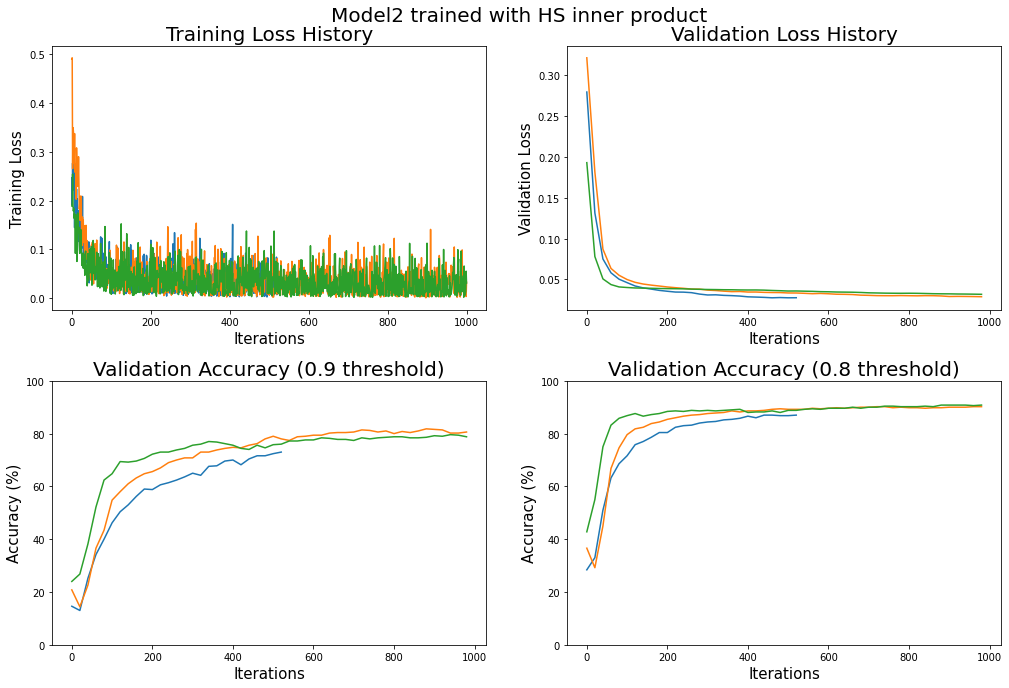

In [28]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.tight_layout(pad=5.0)
fig.suptitle("Model2 trained with HS inner product").set_fontsize(20)
ax1.plot(range(len(loss_history1)), loss_history1, range(len(loss_history2)), loss_history2, range(len(loss_history3)), loss_history3)
ax1.set_title("Training Loss History").set_fontsize(20)
ax1.set_xlabel("Iterations").set_fontsize(15)
ax1.set_ylabel("Training Loss").set_fontsize(15)
ax2.plot(np.array(range(len(validation_loss_history1))) * 20, validation_loss_history1, np.array(range(len(validation_loss_history2))) * 20, validation_loss_history2, np.array(range(len(validation_loss_history3))) * 20, validation_loss_history3)
ax2.set_title("Validation Loss History").set_fontsize(20)
ax2.set_xlabel("Iterations").set_fontsize(15)
ax2.set_ylabel("Validation Loss").set_fontsize(15)
ax3.plot(np.array(range(len(validation_accuracy90_history1))) * 20, validation_accuracy90_history1, np.array(range(len(validation_accuracy90_history2))) * 20, validation_accuracy90_history2, np.array(range(len(validation_accuracy90_history3))) * 20, validation_accuracy90_history3)
ax3.set_title("Validation Accuracy (0.9 threshold)").set_fontsize(20)
ax3.set_xlabel("Iterations").set_fontsize(15)
ax3.set_ylabel("Accuracy (%)").set_fontsize(15)
ax3.set_ylim(0, 100)
ax4.plot(np.array(range(len(validation_accuracy80_history1))) * 20, validation_accuracy80_history1, np.array(range(len(validation_accuracy80_history2))) * 20, validation_accuracy80_history2, np.array(range(len(validation_accuracy80_history3))) * 20, validation_accuracy80_history3)
ax4.set_title("Validation Accuracy (0.8 threshold)").set_fontsize(20)
ax4.set_xlabel("Iterations").set_fontsize(15)
ax4.set_ylabel("Accuracy (%)").set_fontsize(15)
ax4.set_ylim(0, 100)

print("Experiment1\n")
print("---------------")
print(f"Test Loss: {Test_loss1}\n")
print(f"Test Accuracy (0.9): {Test_Accuracy90_1}\n")
print(f"Test Accuracy (0.8): {Test_Accuracy80_1}\n")

print("Experiment2\n")
print("---------------")
print(f"Test Loss: {Test_loss2}\n")
print(f"Test Accuracy (0.9): {Test_Accuracy90_2}\n")
print(f"Test Accuracy (0.8): {Test_Accuracy80_2}\n")

print("Experiment3\n")
print("---------------")
print(f"Test Loss: {Test_loss3}\n")
print(f"Test Accuracy (0.9): {Test_Accuracy90_3}\n")
print(f"Test Accuracy (0.8): {Test_Accuracy80_3}\n")

In [26]:
name1 = "/Users/tak/Github/QEmbedding/Results/Experiment1/Model2_HSinner.pt"
name2 = "/Users/tak/Github/QEmbedding/Results/Experiment2/Model2_HSinner.pt"
name3 = "/Users/tak/Github/QEmbedding/Results/Experiment3/Model2_HSinner.pt"
names = [name1, name2]

for i, name in enumerate(names):
    TraceModel = Hybrid_nn.get_model("DistanceModel2_Trace")
    HSModel = Hybrid_nn.get_model("DistanceModel2_HS")
    TraceModel.load_state_dict(torch.load(name, map_location=torch.device('cpu')))
    HSModel.load_state_dict(torch.load(name, map_location=torch.device('cpu')))
    with torch.no_grad():
        trace_distance = TraceModel(X1_test, X0_test)
        HS_distance = HSModel(X1_test, X0_test)
    print(f"Experiment{i+1}: Trace Distance of test data is {-1 * trace_distance}\n")
    print(f"Experiment{i+1}: Hilbert Schmidt Distance of test data is {-1 * HS_distance}\n")

Experiment1: Trace Distance of test data is 0.9448103308677673

Experiment1: Hilbert Schmidt Distance of test data is 0.3996768891811371

Experiment2: Trace Distance of test data is 0.9290638566017151

Experiment2: Hilbert Schmidt Distance of test data is 0.39940550923347473



# 2.5. Distance Model1 with Trace Distance

In [16]:
loss_history1 = np.array([-0.8443087935447693, -0.8544632196426392, -0.9466342329978943, -0.9371887445449829, -0.9714770317077637, -0.8614130020141602, -0.9189842343330383, -0.9438840746879578, -0.9279921650886536, -0.9399793148040771, -0.9758756160736084, -0.9628161191940308, -0.9777673482894897, -0.9782738089561462, -0.9552295207977295, -0.9766321778297424, -0.9604595899581909, -0.979511559009552, -0.9242594838142395, -0.9803383946418762, -0.9667143821716309, -0.9331452250480652, -0.9428113698959351, -0.9859651923179626, -0.9737173914909363, -0.9019480347633362, -0.9856461882591248, -0.9383466243743896, -0.8812466263771057, -0.9391565322875977, -0.9719839096069336, -0.9876686930656433, -0.983201801776886, -0.9497057795524597, -0.9800757169723511, -0.9909379482269287, -0.9714778065681458, -0.9664731025695801, -0.989166259765625, -0.9657958745956421, -0.9882246851921082, -0.9865155220031738, -0.9934579133987427, -0.9567978978157043, -0.9857633113861084, -0.9900357723236084, -0.9862500429153442, -0.9860578775405884, -0.980186402797699, -0.9781529903411865, -0.963516354560852, -0.9862538576126099, -0.984074592590332, -0.9530214071273804, -0.963007926940918, -0.9950567483901978, -0.9755491614341736, -0.9875924587249756, -0.9924513101577759, -0.9931434988975525, -0.9951173663139343, -0.9822033047676086, -0.9825050234794617, -0.9949694275856018, -0.9969058036804199, -0.9866892695426941, -0.9926295876502991, -0.9948979020118713, -0.9956644773483276, -0.9823329448699951, -0.9607422947883606, -0.9791841506958008, -0.9930144548416138, -0.9747119545936584, -0.9978123903274536, -0.9972772598266602, -0.9503076672554016, -0.9881750345230103, -0.9957072138786316, -0.9978271126747131, -0.8569519519805908, -0.9964851140975952, -0.9944877624511719, -0.9841246008872986, -0.9956353902816772, -0.9507021903991699, -0.9308714866638184, -0.97596675157547, -0.980658233165741, -0.9910988211631775, -0.9372994303703308, -0.9754512310028076, -0.9889599084854126, -0.9944055676460266, -0.9937756657600403, -0.9945588707923889, -0.9599505662918091, -0.9909799098968506, -0.9942498207092285, -0.9542205333709717, -0.9591068625450134, -0.995453953742981, -0.9911394715309143, -0.9765126705169678, -0.9557641744613647, -0.9973313808441162, -0.9949284195899963, -0.9970582127571106, -0.9756746292114258, -0.9950025677680969, -0.996658205986023, -0.9953349232673645, -0.9627109169960022, -0.9887955188751221, -0.9955182671546936, -0.9932554364204407, -0.9069083333015442, -0.9952446222305298, -0.9935933351516724, -0.9968324899673462, -0.9948197603225708, -0.9495385885238647, -0.9936997890472412, -0.9607245922088623, -0.9959701895713806, -0.9784480333328247, -0.997038722038269, -0.9951888918876648, -0.9939635992050171, -0.9899568557739258, -0.9957770109176636, -0.9939674139022827, -0.9935530424118042, -0.9558271169662476, -0.95802903175354, -0.996844470500946, -0.9673888683319092, -0.987546980381012, -0.9980598092079163, -0.9582327008247375, -0.9703460931777954, -0.9970897436141968, -0.9728714227676392, -0.9469767808914185, -0.9976100921630859, -0.9923747777938843, -0.9779080152511597, -0.9967373609542847, -0.9596901535987854, -0.9959154725074768, -0.9982752203941345, -0.9981957674026489, -0.9979187250137329, -0.9538215398788452, -0.984573483467102, -0.9951404929161072, -0.9906413555145264, -0.9887637495994568, -0.9553994536399841, -0.9671359062194824, -0.9844589829444885, -0.9937041997909546, -0.998267412185669, -0.9663421511650085, -0.9967933893203735, -0.9941789507865906, -0.995412290096283, -0.9960115551948547, -0.9842900633811951, -0.9922050833702087, -0.9572251439094543, -0.9601176381111145, -0.960548996925354, -0.9267842173576355, -0.9735488295555115, -0.994490921497345, -0.9574323892593384, -0.9953233599662781, -0.9935048818588257, -0.9929472804069519, -0.9964785575866699, -0.961001455783844, -0.9949578046798706, -0.9957980513572693, -0.992510199546814, -0.986686646938324, -0.9975681304931641, -0.9845655560493469, -0.9563621282577515, -0.9913835525512695, -0.9761307835578918, -0.9760243892669678, -0.9564332962036133, -0.9672114849090576, -0.9970654249191284, -0.9902307987213135, -0.9957820773124695, -0.9946036338806152, -0.9980897903442383, -0.9736590385437012, -0.9941954612731934, -0.9517276287078857, -0.9477427005767822, -0.9958544373512268, -0.9978286027908325, -0.9931003451347351, -0.961418092250824, -0.9961743354797363, -0.9864624738693237, -0.9658695459365845, -0.9972562789916992, -0.9930711984634399, -0.995478630065918, -0.9966810941696167, -0.9493743181228638, -0.9191970825195312, -0.9884185194969177, -0.960388720035553, -0.9968679547309875, -0.8900794386863708, -0.9800886511802673, -0.9972241520881653, -0.9979639649391174, -0.9087275862693787, -0.9950637817382812, -0.9944472908973694, -0.9445564150810242, -0.9907048344612122, -0.9979562163352966, -0.9587855935096741, -0.9987760782241821, -0.9776885509490967, -0.9583008885383606, -0.9545707106590271, -0.9960712790489197, -0.9908286929130554, -0.9956690669059753, -0.9480067491531372, -0.9552282691001892, -0.9968318939208984, -0.9976338148117065, -0.9932079911231995, -0.9574713110923767, -0.957612156867981, -0.9973412752151489, -0.9980006814002991, -0.990253746509552, -0.9979327321052551, -0.9972621202468872, -0.9984816908836365, -0.9914479851722717, -0.9961012601852417, -0.9952298402786255, -0.9975018501281738, -0.9185925126075745, -0.9346863031387329, -0.9874488711357117, -0.9953912496566772, -0.9983145594596863, -0.9392564296722412, -0.997959554195404, -0.9976430535316467, -0.9978750348091125, -0.9911319017410278, -0.9810706973075867, -0.9942671060562134, -0.9973829388618469, -0.9946539998054504, -0.9919148087501526, -0.9982135891914368, -0.9971306324005127, -0.9966251254081726, -0.9973063468933105, -0.9956130385398865, -0.9958663582801819, -0.997904360294342, -0.9986976981163025, -0.9973798394203186, -0.9945438504219055, -0.9569949507713318, -0.9987653493881226, -0.9935556054115295, -0.9905713200569153, -0.9942710399627686, -0.996743381023407, -0.9875171780586243, -0.9978894591331482, -0.9551557898521423, -0.8918699026107788, -0.9970102310180664, -0.9971023797988892, -0.9973185658454895, -0.9976483583450317, -0.9924812912940979, -0.9575690031051636, -0.9946756362915039, -0.9961714744567871, -0.9280739426612854, -0.8928142786026001, -0.9979633092880249, -0.9354057908058167, -0.9588754773139954, -0.9536678791046143, -0.9986352920532227, -0.99752277135849, -0.97096186876297, -0.9984996914863586, -0.9858179688453674, -0.9892164468765259, -0.9964584708213806, -0.9977712631225586, -0.9913144111633301, -0.9985367655754089, -0.9607346653938293, -0.9566826820373535, -0.9973371624946594, -0.9727457761764526, -0.9969353675842285, -0.9952309131622314, -0.9550825357437134, -0.946597158908844, -0.9811511039733887, -0.975459098815918, -0.9636854529380798, -0.9580894708633423, -0.9771015048027039, -0.9927576184272766, -0.9572433233261108, -0.9579607248306274, -0.9621476531028748, -0.994520366191864, -0.9912123680114746, -0.9556075930595398, -0.991801917552948, -0.9903839826583862, -0.9971065521240234, -0.9760335683822632, -0.996099054813385, -0.9591270685195923, -0.9312430620193481, -0.998159646987915])
loss_history2 = np.array([-0.8742941617965698, -0.8412343859672546, -0.9127142429351807, -0.9424813389778137, -0.9093934893608093, -0.937100350856781, -0.9398214221000671, -0.9496243000030518, -0.9007759094238281, -0.9387363195419312, -0.9335705041885376, -0.9734266400337219, -0.9603363871574402, -0.9768618941307068, -0.9712346196174622, -0.9702733755111694, -0.9757789969444275, -0.954534113407135, -0.9791932106018066, -0.9451941847801208, -0.9858320951461792, -0.9769185781478882, -0.9825111627578735, -0.908095121383667, -0.96294105052948, -0.9670869708061218, -0.9357827305793762, -0.9822624921798706, -0.9812378287315369, -0.9837269186973572, -0.9746320843696594, -0.9602586627006531, -0.9822959303855896, -0.9704523086547852, -0.9892654418945312, -0.9632001519203186, -0.9881059527397156, -0.9569382667541504, -0.9852380156517029, -0.9787391424179077, -0.9765241146087646, -0.9420992136001587, -0.9791382551193237, -0.9806627035140991, -0.9881380200386047, -0.9064253568649292, -0.9847951531410217, -0.940324604511261, -0.948769748210907, -0.949571430683136, -0.9783473610877991, -0.9682645797729492, -0.9846963286399841, -0.9478678703308105, -0.9870641827583313, -0.9871925711631775, -0.949539303779602, -0.9431375861167908, -0.956796407699585, -0.9838210344314575, -0.9335169196128845, -0.989863932132721, -0.9860426783561707, -0.9399662017822266, -0.9846342206001282, -0.9749961495399475, -0.9834867119789124, -0.9731265902519226, -0.9503448009490967, -0.9643252491950989, -0.9606236815452576, -0.957273542881012, -0.9884682297706604, -0.974826991558075, -0.9512494802474976, -0.9641973972320557, -0.9646364450454712, -0.9542407989501953, -0.9926166534423828, -0.9528773427009583, -0.9744797945022583, -0.9931102991104126, -0.9900141358375549, -0.9892022013664246, -0.9487083554267883, -0.9952693581581116, -0.9724060893058777, -0.9909632205963135, -0.9749840497970581, -0.9933669567108154, -0.9890623092651367, -0.9626571536064148, -0.9869074821472168, -0.9870292544364929, -0.9882330894470215, -0.963485598564148, -0.9875645637512207, -0.9574682712554932, -0.9778811931610107, -0.9729946851730347, -0.9769251346588135, -0.9954364895820618, -0.9536865949630737, -0.9628903269767761, -0.9883595108985901, -0.968315064907074, -0.9792380332946777, -0.9835217595100403, -0.9889917969703674, -0.9915260672569275, -0.9772363901138306, -0.9871294498443604, -0.9947031140327454, -0.9915685057640076, -0.95896977186203, -0.9920059442520142, -0.9519652724266052, -0.9580656886100769, -0.9944792985916138, -0.9908434748649597, -0.9735420942306519, -0.9939650893211365, -0.9960510730743408, -0.9539071321487427, -0.9962804317474365, -0.9614264369010925, -0.9926688075065613, -0.9891791939735413, -0.9615162014961243, -0.9626556634902954, -0.9948805570602417, -0.9795719385147095, -0.9880313873291016, -0.9492583870887756, -0.9937871694564819, -0.9848433136940002, -0.9950974583625793, -0.9918302893638611, -0.9952463507652283, -0.9940609931945801, -0.9294343590736389, -0.8788312077522278, -0.9331334829330444, -0.9558959603309631, -0.9933040142059326, -0.9318929314613342, -0.9931691884994507, -0.9942872524261475, -0.9761389493942261, -0.9567469954490662, -0.9867412447929382, -0.9784637689590454, -0.9952354431152344, -0.9897358417510986, -0.9955421090126038, -0.9655832648277283, -0.9541345834732056, -0.9437395930290222, -0.9779767394065857, -0.985617995262146, -0.9566001892089844, -0.97002112865448, -0.9694610238075256, -0.9638395309448242, -0.9934486150741577, -0.9846882224082947, -0.9920348525047302, -0.9937663078308105, -0.9966794848442078, -0.9420604109764099, -0.9294424653053284, -0.9720733761787415, -0.9574808478355408, -0.9538470506668091, -0.9537210464477539, -0.9850214719772339, -0.9732011556625366, -0.994288980960846, -0.9674569964408875, -0.9949593544006348, -0.9663262963294983, -0.9273309111595154, -0.9872574210166931, -0.9918766617774963, -0.9723359942436218, -0.9819751381874084, -0.9741946458816528, -0.9790633320808411, -0.9501429200172424, -0.9937996864318848, -0.9437707662582397, -0.9931649565696716, -0.9784756898880005, -0.9773267507553101, -0.9930951595306396, -0.9938251376152039, -0.9945382475852966, -0.9630526304244995, -0.9818761348724365, -0.9621370434761047, -0.9745452404022217, -0.9928753972053528, -0.9944298267364502, -0.9599936008453369, -0.9923045635223389, -0.9889121055603027, -0.9948957562446594, -0.9450473785400391, -0.9720436930656433, -0.9950187802314758, -0.9479036331176758, -0.9899502396583557, -0.9967452883720398, -0.9926462173461914, -0.9708206653594971, -0.9888685941696167, -0.9728241562843323, -0.9955674409866333, -0.9962908029556274, -0.9768486022949219, -0.990878701210022])
loss_history3 = np.array([-0.5644593238830566, -0.8662133812904358, -0.8963873386383057, -0.9403555393218994, -0.8926414251327515, -0.9289922118186951, -0.983020007610321, -0.9468814134597778, -0.9401161074638367, -0.9867439866065979, -0.9830834269523621, -0.9871582388877869, -0.9084362983703613, -0.9238196611404419, -0.9650522470474243, -0.9638412594795227, -0.9345672726631165, -0.9494073390960693, -0.9730185270309448, -0.9328147172927856, -0.9915539622306824, -0.9815265536308289, -0.9444279670715332, -0.9478799104690552, -0.984379231929779, -0.9842290878295898, -0.9887038469314575, -0.9937906861305237, -0.943942129611969, -0.9741058349609375, -0.9092304110527039, -0.9807329177856445, -0.9926082491874695, -0.9885428547859192, -0.9907119274139404, -0.9854210019111633, -0.9646549820899963, -0.9539877772331238, -0.9528257250785828, -0.9902514815330505, -0.9942702054977417, -0.9708930850028992, -0.9886829853057861, -0.9611455798149109, -0.9882603287696838, -0.9923893213272095, -0.985276460647583, -0.9928880929946899, -0.9189097881317139, -0.9948219060897827, -0.9162189364433289, -0.9950068593025208, -0.9930940270423889, -0.9556618332862854, -0.9903768301010132, -0.9584517478942871, -0.9815091490745544, -0.9906898140907288, -0.9883506894111633, -0.9964128136634827, -0.9435049891471863, -0.9921476244926453, -0.9944764971733093, -0.9556066393852234, -0.9556339383125305, -0.9945960640907288, -0.9936114549636841, -0.9557669758796692, -0.9936273097991943, -0.9959825873374939, -0.9748387932777405, -0.9644599556922913, -0.9941262006759644, -0.9969010353088379, -0.959149956703186, -0.9552582502365112, -0.985223650932312, -0.9799365997314453, -0.9934856295585632, -0.9945988059043884, -0.9570560455322266, -0.964335024356842, -0.9777817130088806, -0.9383184909820557, -0.9581910967826843, -0.9549725651741028, -0.9960308074951172, -0.9961850643157959, -0.9842085838317871, -0.9816318154335022, -0.9895716905593872, -0.9912106990814209, -0.9969040155410767, -0.9960161447525024, -0.9971634745597839, -0.9563050866127014, -0.9728642702102661, -0.9756749272346497, -0.9855515956878662, -0.9909395575523376, -0.9537746906280518, -0.9975028038024902, -0.8888424634933472, -0.9953799843788147, -0.9565833210945129, -0.9896271228790283, -0.9905247092247009, -0.9949458837509155, -0.9217974543571472, -0.9614112377166748, -0.9931245446205139, -0.9929152131080627, -0.9916638135910034, -0.9927739500999451, -0.9790850281715393, -0.9929107427597046, -0.9954375624656677, -0.9615922570228577, -0.9937284588813782, -0.99446702003479, -0.9573859572410583, -0.9578151702880859, -0.9957067370414734, -0.9947947263717651, -0.9167581796646118, -0.995303213596344, -0.926933228969574, -0.9952312707901001, -0.9117846488952637, -0.9898134469985962, -0.9969636797904968, -0.9551687836647034, -0.9962977766990662, -0.9762733578681946, -0.9961354732513428, -0.9612617492675781, -0.9977294206619263, -0.9729945063591003, -0.9959703087806702, -0.9951988458633423, -0.9687143564224243, -0.9498171210289001, -0.9903973340988159, -0.9967636466026306, -0.9579535126686096, -0.9567147493362427, -0.9972505569458008, -0.9620030522346497, -0.9954801201820374, -0.9587436318397522, -0.9844695329666138, -0.941939115524292, -0.9570397138595581, -0.9954250454902649, -0.9963251948356628, -0.9967634081840515, -0.9695065021514893, -0.9558855295181274, -0.9979507923126221, -0.9473703503608704, -0.9923723340034485, -0.918387234210968, -0.9596425890922546, -0.966316819190979, -0.9873859286308289, -0.9138477444648743, -0.9971156716346741, -0.997153103351593, -0.9689264893531799, -0.9937382340431213, -0.961647629737854, -0.9921333193778992, -0.9981131553649902, -0.9273703098297119, -0.9174625277519226, -0.9942666888237, -0.9971824288368225, -0.9883261322975159, -0.9575279951095581, -0.9192521572113037, -0.95428866147995, -0.9571672081947327, -0.9980950951576233, -0.9831445813179016, -0.9982485771179199, -0.9957767724990845, -0.9971505999565125, -0.958712637424469, -0.9983352422714233, -0.9798275232315063, -0.9824665784835815, -0.9823482036590576, -0.9957190155982971, -0.9983817934989929, -0.9956470131874084, -0.9975185394287109, -0.958152711391449, -0.9559219479560852, -0.995876669883728, -0.9913892149925232, -0.9956925511360168, -0.9580988883972168, -0.9038890600204468, -0.9546366930007935, -0.9186493754386902, -0.9971347451210022, -0.9959123134613037, -0.9945457577705383, -0.9962227940559387, -0.9866411685943604, -0.9951131343841553, -0.949749767780304, -0.9685854315757751, -0.9506009817123413, -0.9535459876060486, -0.997219979763031, -0.9974091053009033, -0.9576714634895325, -0.996971070766449, -0.9976789355278015, -0.9482473134994507, -0.9727901816368103, -0.9565941691398621, -0.9920495748519897, -0.9976837635040283, -0.9793927073478699, -0.9940515160560608, -0.9955483675003052, -0.9950395822525024, -0.9575580358505249, -0.9676828980445862, -0.986051082611084, -0.9971944689750671, -0.9975542426109314, -0.9570529460906982, -0.9488486051559448, -0.9885784983634949, -0.9894982576370239, -0.9966574907302856, -0.9709336161613464, -0.9974309802055359, -0.9948726892471313, -0.9479715824127197, -0.9954403638839722, -0.9966605305671692, -0.9585248231887817, -0.9306580424308777, -0.997330367565155, -0.9031296372413635, -0.9940187335014343, -0.9952064752578735, -0.9950253367424011, -0.94464510679245, -0.9969664812088013, -0.9759272336959839, -0.9865126609802246, -0.9916394352912903, -0.960286557674408, -0.9766448140144348, -0.9569435715675354, -0.9931980967521667])

validation_loss_history1 = np.array([-0.8545377850532532, -0.9452551007270813, -0.9670224785804749, -0.9728720188140869, -0.9795526266098022, -0.9768427610397339, -0.9799911975860596, -0.9818421602249146, -0.9758250117301941, -0.9818901419639587, -0.9816269874572754, -0.9804139137268066, -0.9822980761528015, -0.9808571338653564, -0.9839279651641846, -0.9824032187461853, -0.9820297956466675, -0.9835355877876282])
validation_loss_history2 = np.array([-0.8107219338417053, -0.9262729287147522, -0.9429981708526611, -0.9440640807151794, -0.9563838839530945, -0.9628695249557495, -0.9672181010246277, -0.9623392224311829, -0.9688123464584351, -0.9673050045967102, -0.9615706205368042, -0.9655086994171143])
validation_loss_history3 = np.array([-0.9212023019790649, -0.9580379724502563, -0.9672277569770813, -0.97016841173172, -0.9746392369270325, -0.9746410846710205, -0.9755052328109741, -0.9740716218948364, -0.9749276041984558, -0.9768033027648926, -0.9773019552230835, -0.9748190641403198, -0.9768537878990173, -0.9770979285240173])

Test_loss1 = -0.9734438061714172
Test_loss2 = -0.9617754220962524
Test_loss3 = -0.9661867022514343

## Data Plot

Trace Distance of Test dataset (Experiment1): 0.9734438061714172

Trace Distance of Test dataset (Experiment2): 0.9617754220962524

Trace Distance of Test dataset (Experiment3): 0.9661867022514343



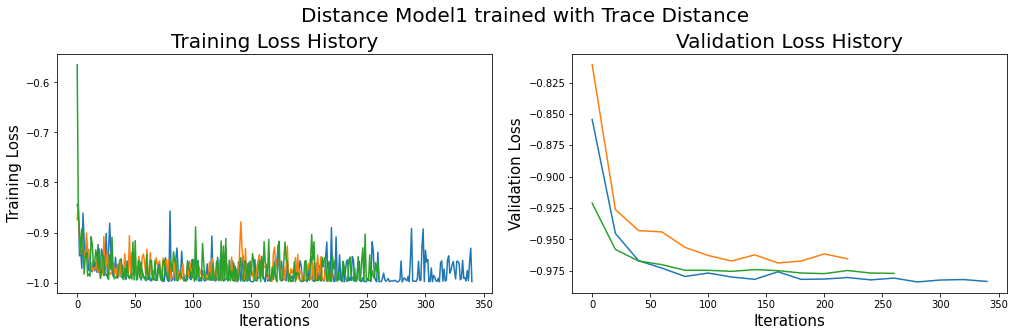

In [17]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, (ax1, ax2) = plt.subplots(1,2)
fig.tight_layout(pad=5.0)
fig.suptitle("Distance Model1 trained with Trace Distance").set_fontsize(20)
ax1.plot(range(len(loss_history1)), loss_history1, range(len(loss_history2)), loss_history2, range(len(loss_history3)), loss_history3)
ax1.set_title("Training Loss History").set_fontsize(20)
ax1.set_xlabel("Iterations").set_fontsize(15)
ax1.set_ylabel("Training Loss").set_fontsize(15)
ax2.plot(np.array(range(len(validation_loss_history1))) * 20, validation_loss_history1, np.array(range(len(validation_loss_history2))) * 20, validation_loss_history2, np.array(range(len(validation_loss_history3))) * 20, validation_loss_history3)
ax2.set_title("Validation Loss History").set_fontsize(20)
ax2.set_xlabel("Iterations").set_fontsize(15)
ax2.set_ylabel("Validation Loss").set_fontsize(15)

print(f"Trace Distance of Test dataset (Experiment1): {Test_loss1 * -1}\n")
print(f"Trace Distance of Test dataset (Experiment2): {Test_loss2 * -1}\n")
print(f"Trace Distance of Test dataset (Experiment3): {Test_loss3 * -1}\n")

# 2.6. Distance Model1 with Hilber-Schmidt Distance

In [18]:
loss_history1 = np.array([-0.12293875217437744, -0.147116556763649, -0.22016915678977966, -0.20924526453018188, -0.2253173291683197, -0.28305619955062866, -0.2510353624820709, -0.30936866998672485, -0.3345131278038025, -0.4044624865055084, -0.30357658863067627, -0.3701630234718323, -0.41539835929870605, -0.4000113606452942, -0.40243861079216003, -0.3970217704772949, -0.43909791111946106, -0.4251713752746582, -0.4548041522502899, -0.43116533756256104, -0.42923685908317566, -0.435668408870697, -0.47979235649108887, -0.45340561866760254, -0.4549289345741272, -0.5163794755935669, -0.44320106506347656, -0.47065162658691406, -0.4661863446235657, -0.3938237428665161, -0.39716511964797974, -0.447651207447052, -0.4833439588546753, -0.45176824927330017, -0.5043798685073853, -0.46921172738075256, -0.43459761142730713, -0.4320959150791168, -0.4727230370044708, -0.510162889957428, -0.428739070892334, -0.4779101610183716, -0.4459525942802429, -0.44206273555755615, -0.4405505657196045, -0.47983330488204956, -0.46030569076538086, -0.43512970209121704, -0.4898223876953125, -0.5127341747283936, -0.4825119376182556, -0.4999207854270935, -0.46847397089004517, -0.44274359941482544, -0.502334713935852, -0.5128328204154968, -0.5043106079101562, -0.47887885570526123, -0.4856523275375366, -0.45048782229423523, -0.5462100505828857, -0.4927459955215454, -0.46304672956466675, -0.4579507112503052, -0.4651489853858948, -0.45983272790908813, -0.5104540586471558, -0.5255835056304932, -0.4978466331958771, -0.4126640558242798, -0.43638676404953003, -0.46184682846069336, -0.46398547291755676, -0.46172699332237244, -0.5119248628616333, -0.4419006407260895, -0.41693708300590515, -0.438105046749115, -0.4845563769340515, -0.46979907155036926, -0.4846862256526947, -0.49557721614837646, -0.389401376247406, -0.3949826955795288, -0.4988318085670471, -0.4378387928009033, -0.49813899397850037, -0.5039262175559998, -0.49478042125701904, -0.4783605933189392, -0.4655870795249939, -0.5289275050163269, -0.4853554964065552, -0.4950953722000122, -0.4289996325969696, -0.4287058115005493, -0.5196990966796875, -0.4497704803943634, -0.5176759362220764, -0.5354729890823364, -0.5046886205673218, -0.48126548528671265, -0.49300694465637207, -0.4854065179824829, -0.5558388233184814, -0.48949122428894043, -0.40019115805625916, -0.4837161898612976, -0.46931183338165283, -0.5398777723312378, -0.49464473128318787, -0.4235914945602417, -0.5302222967147827, -0.47921645641326904, -0.45018261671066284, -0.44721150398254395, -0.5077930092811584, -0.5019224286079407, -0.4344731271266937, -0.5351840853691101, -0.5102124214172363, -0.49188655614852905, -0.482665479183197, -0.4728183150291443, -0.4970667362213135, -0.5024582147598267, -0.524700939655304, -0.5025780200958252, -0.47244590520858765, -0.4468497931957245, -0.542343020439148, -0.5118827223777771, -0.483544260263443, -0.5180709362030029, -0.4635102152824402, -0.48471546173095703, -0.573638379573822, -0.39125004410743713, -0.4355306625366211, -0.5017629265785217, -0.5433157682418823, -0.5508092641830444, -0.4915119409561157, -0.49428871273994446, -0.47323402762413025, -0.5233995914459229, -0.5057460069656372, -0.48435717821121216, -0.5169209837913513, -0.47460275888442993, -0.5036711692810059, -0.5320380926132202, -0.501091480255127, -0.3997684121131897, -0.5252852439880371, -0.48094263672828674, -0.4279376268386841, -0.49024125933647156, -0.5202013850212097, -0.4737943708896637, -0.46481430530548096, -0.506406307220459, -0.5597035884857178, -0.41472846269607544, -0.4284479022026062, -0.5049808621406555, -0.5142680406570435, -0.47361624240875244, -0.5054014921188354, -0.5247656106948853, -0.4430162012577057, -0.5003007054328918, -0.4824953079223633, -0.39719200134277344, -0.4738417863845825, -0.5100272297859192, -0.506023108959198, -0.5245497822761536, -0.4951624870300293, -0.4777698218822479, -0.4232301712036133, -0.5016255378723145, -0.6001747250556946, -0.45594167709350586, -0.48031580448150635, -0.48298949003219604, -0.5734090805053711, -0.5000389814376831, -0.46763843297958374, -0.4394862651824951, -0.5277407169342041, -0.515083909034729, -0.4606854319572449, -0.4662567973136902, -0.5348972678184509, -0.5121988654136658, -0.4934888780117035, -0.5530118346214294, -0.48828786611557007, -0.4525805115699768, -0.5190754532814026])
loss_history2 = np.array([-0.12669944763183594, -0.12687665224075317, -0.22141368687152863, -0.234858900308609, -0.21896791458129883, -0.28720778226852417, -0.2722169756889343, -0.27918410301208496, -0.3888283967971802, -0.4296068251132965, -0.4270024299621582, -0.3845546841621399, -0.3940909504890442, -0.4112568497657776, -0.3900410532951355, -0.3683125972747803, -0.44083476066589355, -0.4400235116481781, -0.3997694253921509, -0.501268744468689, -0.43072056770324707, -0.4048541784286499, -0.43519288301467896, -0.4287436008453369, -0.4736068844795227, -0.44634097814559937, -0.41166919469833374, -0.4364427924156189, -0.47321295738220215, -0.44312262535095215, -0.48812368512153625, -0.41362375020980835, -0.4290210008621216, -0.46804672479629517, -0.48646339774131775, -0.5183861255645752, -0.4663921296596527, -0.44613486528396606, -0.4194530248641968, -0.4682907462120056, -0.5286556482315063, -0.4016685485839844, -0.5103006362915039, -0.47625213861465454, -0.4802526533603668, -0.38386455178260803, -0.4311915934085846, -0.503020167350769, -0.46935513615608215, -0.40948575735092163, -0.48650750517845154, -0.4843423366546631, -0.47612762451171875, -0.5226717591285706, -0.5074756145477295, -0.5489751696586609, -0.4660716652870178, -0.4884163737297058, -0.4298971891403198, -0.44704335927963257, -0.5418708920478821, -0.47661080956459045, -0.5036463737487793, -0.45593833923339844, -0.4784560203552246, -0.4633479416370392, -0.4472034275531769, -0.4847137928009033, -0.4737902879714966, -0.46674931049346924, -0.4523622393608093, -0.4258967339992523, -0.4018979072570801, -0.4878673255443573, -0.4588634967803955, -0.4367082118988037, -0.40809720754623413, -0.5345619916915894, -0.4635564386844635, -0.5142223834991455, -0.5546690225601196, -0.4762643873691559, -0.5023699998855591, -0.4577246904373169, -0.46351635456085205, -0.4677562117576599, -0.4851340651512146, -0.5465536713600159, -0.4516008496284485, -0.48375314474105835, -0.4278578758239746, -0.38616707921028137, -0.4932699501514435, -0.4720155596733093, -0.48800861835479736, -0.49128758907318115, -0.4669114351272583, -0.4937877953052521, -0.4241783022880554, -0.4552881121635437, -0.46378129720687866, -0.4670914113521576, -0.4906773865222931, -0.49183008074760437, -0.4408217668533325, -0.512466549873352, -0.5164297819137573, -0.4674402177333832, -0.5543711185455322, -0.5013917684555054, -0.4090685248374939, -0.4893544316291809, -0.5105713605880737, -0.4479851722717285, -0.42530331015586853, -0.49838054180145264, -0.46363431215286255, -0.5169428586959839, -0.5267868041992188, -0.45901650190353394, -0.49627822637557983, -0.4880179464817047, -0.5809840559959412, -0.39074867963790894, -0.4571038484573364, -0.5363187193870544, -0.49159935116767883, -0.4413630962371826, -0.49198752641677856, -0.4466158151626587, -0.5061757564544678, -0.4737511873245239, -0.5139168500900269, -0.5486944913864136, -0.48781460523605347, -0.4489201307296753, -0.460260808467865, -0.49245786666870117, -0.4887095093727112, -0.5419570803642273, -0.43984511494636536, -0.48468977212905884, -0.4247439503669739, -0.5003700256347656, -0.4161708354949951, -0.5538102984428406, -0.49086856842041016, -0.5132153034210205, -0.5294843912124634, -0.4455718696117401, -0.4481649696826935, -0.5481510758399963, -0.5019237995147705, -0.5606091022491455, -0.45828837156295776, -0.4849156141281128, -0.5408989787101746, -0.4978616237640381, -0.571010410785675, -0.45489877462387085, -0.4984951615333557, -0.5774905681610107, -0.4802130460739136, -0.5212871432304382, -0.5043712854385376, -0.4515107572078705, -0.5317325592041016, -0.4652268886566162, -0.5391350388526917, -0.5049934387207031, -0.5575879216194153, -0.5000916123390198, -0.5496494770050049, -0.5992494821548462, -0.4731941521167755, -0.43105438351631165, -0.48874181509017944, -0.4548523426055908, -0.4620763659477234, -0.49702906608581543, -0.4454386830329895, -0.5149660110473633, -0.5261968374252319, -0.4932482838630676, -0.4864135980606079, -0.513574481010437, -0.5261720418930054, -0.49305471777915955, -0.5467725992202759, -0.5388773679733276, -0.44972410798072815, -0.4496667981147766, -0.4303503930568695, -0.49687713384628296, -0.5365411043167114, -0.4571118950843811, -0.5014162063598633, -0.47032278776168823, -0.549481987953186, -0.45326775312423706, -0.45262160897254944])
loss_history3 = np.array([-0.10463179647922516, -0.10970194637775421, -0.1331598162651062, -0.12761932611465454, -0.15956668555736542, -0.2191307246685028, -0.1613732874393463, -0.251542866230011, -0.1757204532623291, -0.20709440112113953, -0.30608195066452026, -0.303058922290802, -0.23967257142066956, -0.310859739780426, -0.340250700712204, -0.39820629358291626, -0.40486055612564087, -0.399283230304718, -0.4514174461364746, -0.3823460638523102, -0.3666912913322449, -0.470817506313324, -0.4408952593803406, -0.44255250692367554, -0.4907218813896179, -0.4119449853897095, -0.4582709074020386, -0.4462682902812958, -0.392424076795578, -0.3801332116127014, -0.43476158380508423, -0.4954928159713745, -0.441720575094223, -0.44457709789276123, -0.47008776664733887, -0.46739137172698975, -0.3471625745296478, -0.47019124031066895, -0.5333594679832458, -0.3850366473197937, -0.4483761489391327, -0.46422526240348816, -0.4764135181903839, -0.42100977897644043, -0.5017582178115845, -0.4745182991027832, -0.4680688977241516, -0.5124574899673462, -0.4685268700122833, -0.43149152398109436, -0.3898185193538666, -0.45931175351142883, -0.4476143419742584, -0.4405094385147095, -0.38006851077079773, -0.47663187980651855, -0.5003916621208191, -0.46831876039505005, -0.48975253105163574, -0.47889965772628784, -0.5511364340782166, -0.4216243624687195, -0.5178013443946838, -0.4867352247238159, -0.4438847303390503, -0.4564940333366394, -0.49490126967430115, -0.41629254817962646, -0.4121536612510681, -0.4893936216831207, -0.44110220670700073, -0.4287554621696472, -0.4483470916748047, -0.4599754214286804, -0.5014215707778931, -0.40259677171707153, -0.49920040369033813, -0.44960349798202515, -0.42845016717910767, -0.5051206350326538, -0.4670630395412445, -0.4739195704460144, -0.4712461233139038, -0.4547919034957886, -0.47290876507759094, -0.49007463455200195, -0.4094941020011902, -0.5054820775985718, -0.45230531692504883, -0.5200351476669312, -0.4504382014274597, -0.5395485162734985, -0.5517492890357971, -0.4204409420490265, -0.536425769329071, -0.4765664339065552, -0.48680272698402405, -0.5143617391586304, -0.47043725848197937, -0.4848484396934509, -0.4768730401992798, -0.4471696615219116, -0.5631755590438843, -0.503531813621521, -0.5608421564102173, -0.5532972812652588, -0.4395034611225128, -0.5423981547355652, -0.5058927536010742, -0.5556495785713196, -0.5345789194107056, -0.4567408561706543, -0.541439414024353, -0.5390456914901733, -0.5229300260543823, -0.5141485929489136, -0.5458575487136841, -0.4704294502735138, -0.5337843298912048, -0.52060866355896, -0.46624577045440674, -0.5336030721664429, -0.5123142004013062, -0.5846188068389893, -0.5889146327972412, -0.501561164855957, -0.5362294912338257, -0.5367257595062256, -0.581780731678009, -0.5170509219169617, -0.4672199487686157, -0.570746898651123, -0.5955555438995361, -0.5324163436889648, -0.536392092704773, -0.5481009483337402, -0.557671070098877, -0.5546509623527527, -0.529354453086853, -0.42621445655822754, -0.445841521024704, -0.3996836543083191, -0.47105273604393005, -0.5341101884841919, -0.48595136404037476, -0.4921884536743164, -0.4650130569934845, -0.49250560998916626, -0.5266767740249634, -0.49724212288856506, -0.40417158603668213, -0.5445257425308228, -0.4841008484363556, -0.46932655572891235, -0.5232749581336975, -0.49268513917922974, -0.38979440927505493, -0.5004223585128784, -0.5070035457611084, -0.40074944496154785, -0.49408814311027527, -0.5105401873588562, -0.4689437747001648, -0.5316613912582397, -0.4635661244392395, -0.4671896696090698, -0.4821363091468811, -0.5139312148094177, -0.44656985998153687, -0.5201993584632874, -0.5080313682556152, -0.4684552550315857, -0.4851260781288147, -0.5011979937553406, -0.5391665697097778, -0.49701178073883057, -0.5065735578536987, -0.45849889516830444, -0.5712844133377075, -0.48916110396385193, -0.5159392356872559])

validation_loss_history1 = np.array([-0.17777898907661438, -0.4088054895401001, -0.4529710114002228, -0.48595350980758667, -0.4643535614013672, -0.49194613099098206, -0.4649607539176941, -0.5156323909759521, -0.5052880048751831, -0.49711108207702637, -0.4705495238304138])
validation_loss_history2 = np.array([-0.12544597685337067, -0.4246499836444855, -0.452861487865448, -0.46620237827301025, -0.45952820777893066, -0.4834776520729065, -0.4926413893699646, -0.5552228689193726, -0.548113226890564, -0.47752004861831665, -0.4822354316711426])
validation_loss_history3 = np.array([-0.0903862863779068, -0.4085996747016907, -0.45704415440559387, -0.48819875717163086, -0.48925715684890747, -0.4818821847438812, -0.5217117071151733, -0.4422251284122467, -0.5079394578933716, -0.4798920154571533])

Test_loss1 = -0.4648645222187042
Test_loss2 = -0.4718230962753296
Test_loss3 = -0.47188740968704224

## Data Plot

HS Distance of Test dataset (Experiment1): 0.4648645222187042

HS Distance of Test dataset (Experiment2): 0.4718230962753296

HS Distance of Test dataset (Experiment3): 0.47188740968704224



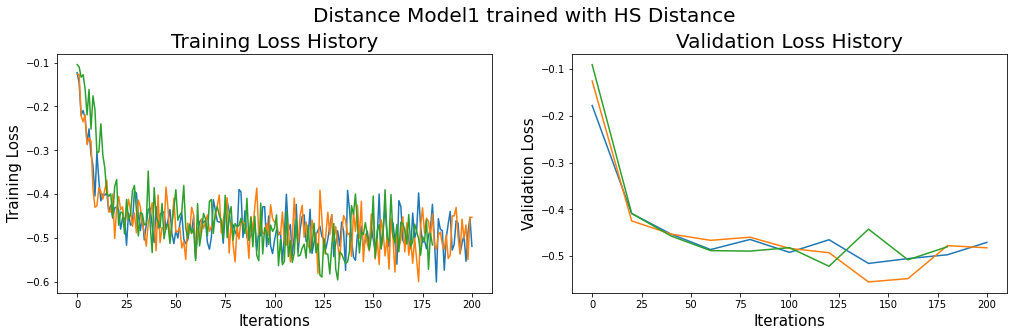

In [19]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, (ax1, ax2) = plt.subplots(1,2)
fig.tight_layout(pad=5.0)
fig.suptitle("Distance Model1 trained with HS Distance").set_fontsize(20)
ax1.plot(range(len(loss_history1)), loss_history1, range(len(loss_history2)), loss_history2, range(len(loss_history3)), loss_history3)
ax1.set_title("Training Loss History").set_fontsize(20)
ax1.set_xlabel("Iterations").set_fontsize(15)
ax1.set_ylabel("Training Loss").set_fontsize(15)
ax2.plot(np.array(range(len(validation_loss_history1))) * 20, validation_loss_history1, np.array(range(len(validation_loss_history2))) * 20, validation_loss_history2, np.array(range(len(validation_loss_history3))) * 20, validation_loss_history3)
ax2.set_title("Validation Loss History").set_fontsize(20)
ax2.set_xlabel("Iterations").set_fontsize(15)
ax2.set_ylabel("Validation Loss").set_fontsize(15)

print(f"HS Distance of Test dataset (Experiment1): {Test_loss1 * -1}\n")
print(f"HS Distance of Test dataset (Experiment2): {Test_loss2 * -1}\n")
print(f"HS Distance of Test dataset (Experiment3): {Test_loss3 * -1}\n")

# 2.7. Distance Model2 with Trace Distance

In [20]:
loss_history1 = np.array([-0.6830390095710754, -0.763124942779541, -0.9356997609138489, -0.8639363646507263, -0.9213999509811401, -0.9617672562599182, -0.9412659406661987, -0.9128382205963135, -0.9312789440155029, -0.9594191908836365, -0.9741908311843872, -0.9282243251800537, -0.9577968716621399, -0.9710982441902161, -0.9787413477897644, -0.9047742486000061, -0.9145621061325073, -0.9160572290420532, -0.9634791016578674, -0.9429952502250671, -0.9448580145835876, -0.9033738970756531, -0.9017056822776794, -0.9487199187278748, -0.9731485843658447, -0.9823824763298035, -0.9752768278121948, -0.93338942527771, -0.9466739892959595, -0.9005551934242249, -0.9554665088653564, -0.9884198307991028, -0.9422831535339355, -0.9940036535263062, -0.9685429930686951, -0.9570868611335754, -0.9914373159408569, -0.9524209499359131, -0.9204670786857605, -0.9915212988853455, -0.980560839176178, -0.9937444925308228, -0.9948743581771851, -0.9965830445289612, -0.886549174785614, -0.9646055698394775, -0.9166203737258911, -0.9952998757362366, -0.9294201731681824, -0.9954907298088074, -0.9301539659500122, -0.9284026026725769, -0.9964219331741333, -0.9673775434494019, -0.9560701251029968, -0.9934491515159607, -0.9901118874549866, -0.9197955131530762, -0.9949995875358582, -0.9962918162345886, -0.9962195158004761, -0.9938112497329712, -0.9955806136131287, -0.9944705963134766, -0.980849027633667, -0.9941385388374329, -0.9370502829551697, -0.9626079797744751, -0.994975209236145, -0.9347761273384094, -0.992572546005249, -0.9934808015823364, -0.9964165091514587, -0.9958597421646118, -0.9965782165527344, -0.9836223721504211, -0.9736204743385315, -0.972673773765564, -0.9684857130050659, -0.9869742393493652, -0.9971817135810852, -0.9957204461097717, -0.9619893431663513, -0.9883677959442139, -0.948673665523529, -0.9636633396148682, -0.9562074542045593, -0.9595789313316345, -0.9661867022514343, -0.9567868113517761, -0.938971757888794, -0.9926033616065979, -0.9948393702507019, -0.9366232752799988, -0.9821081757545471, -0.9949333667755127, -0.9570472836494446, -0.9654364585876465, -0.9870153069496155, -0.9857165813446045, -0.997403621673584, -0.9306769967079163, -0.9902529716491699, -0.9968529343605042, -0.9862728714942932, -0.9777243733406067, -0.9962620139122009, -0.9673267006874084, -0.996240496635437, -0.9904617071151733, -0.9160603284835815, -0.9932893514633179, -0.9735807776451111, -0.9898307919502258, -0.9838114976882935, -0.9859632849693298, -0.9773465991020203, -0.9900355935096741, -0.9948431849479675, -0.9965909719467163, -0.9944028854370117, -0.9523632526397705, -0.9416412711143494, -0.9839274883270264, -0.99311363697052, -0.961943507194519, -0.9782505631446838, -0.9756724238395691, -0.9912301301956177, -0.9565655589103699, -0.9717503786087036, -0.9901517629623413, -0.9969022870063782, -0.955411434173584, -0.966651439666748, -0.9185118675231934, -0.9924152493476868, -0.9272541999816895, -0.9326966404914856, -0.991596519947052, -0.9922349452972412, -0.997217059135437, -0.9707258939743042, -0.9348325133323669, -0.9972822070121765, -0.970204770565033, -0.9744588136672974, -0.9856516718864441, -0.9637112617492676, -0.9791898727416992, -0.9579833745956421, -0.9932645559310913, -0.915382981300354, -0.9929373264312744, -0.9765143990516663, -0.9599367380142212, -0.976337730884552, -0.9326164722442627, -0.9701111316680908, -0.9761934876441956, -0.9650672674179077, -0.997514009475708, -0.9332010746002197, -0.9975547790527344, -0.9918807148933411, -0.9728999137878418, -0.9961642026901245, -0.9974575638771057, -0.9711747765541077, -0.9979954361915588, -0.9316001534461975, -0.987302303314209, -0.9690201282501221, -0.9950417280197144, -0.9935753345489502, -0.9966254830360413, -0.9960541725158691, -0.9979774951934814, -0.9968307018280029, -0.9918955564498901, -0.9976968765258789, -0.9977600574493408, -0.9980372190475464, -0.9831317663192749, -0.958811342716217, -0.9604265689849854, -0.9936051368713379, -0.9091877937316895, -0.9977936744689941, -0.9968860149383545, -0.9978965520858765, -0.9645381569862366, -0.9966238737106323, -0.9974007606506348, -0.9974181652069092, -0.9677204489707947, -0.9979624152183533, -0.9929234385490417, -0.995090126991272, -0.9734997153282166, -0.9893016219139099, -0.9975540637969971, -0.9737627506256104, -0.9966468811035156, -0.9953266382217407, -0.9937974810600281, -0.997632622718811, -0.931177020072937, -0.9975422620773315, -0.9980672597885132, -0.9799048900604248, -0.9960120320320129, -0.9901604652404785, -0.9973899722099304, -0.9961541891098022, -0.9960670471191406, -0.9679423570632935, -0.9970129132270813, -0.9333593249320984, -0.9970516562461853, -0.9097304344177246, -0.9974979162216187, -0.9977861046791077, -0.9656209349632263, -0.9205917716026306, -0.9967101216316223, -0.9583683013916016, -0.9737852215766907, -0.9879862070083618, -0.9912371039390564, -0.9968773722648621, -0.9588986039161682, -0.997534990310669, -0.9968256950378418, -0.9929772615432739, -0.996641993522644, -0.9980965256690979, -0.9576874375343323, -0.9974532723426819, -0.9968225955963135, -0.9441568851470947, -0.9816018342971802, -0.9972051382064819, -0.9651035666465759, -0.9828084707260132, -0.969040036201477, -0.9723113179206848, -0.9933391213417053, -0.9979191422462463, -0.9637382626533508, -0.9970044493675232, -0.9646829962730408, -0.9971482157707214, -0.9905194044113159, -0.9980061054229736, -0.9969080686569214, -0.9981387853622437, -0.997301459312439, -0.9976662397384644, -0.9624675512313843, -0.9980942010879517, -0.9641857147216797, -0.9702190160751343, -0.964971661567688, -0.9125825762748718, -0.9563793540000916, -0.9875277280807495, -0.9738547801971436, -0.9850355982780457, -0.9962146878242493, -0.9596164226531982, -0.965778112411499, -0.9962009787559509, -0.9977656602859497, -0.9795828461647034, -0.9621950387954712, -0.9854065775871277, -0.9675433039665222, -0.9603551626205444, -0.9975489377975464, -0.9932467937469482, -0.9312734603881836, -0.9940852522850037, -0.9963404536247253, -0.9374633431434631, -0.9587304592132568, -0.9904215931892395, -0.9707158207893372, -0.9569283127784729, -0.9969034194946289, -0.9974945187568665, -0.9520244002342224, -0.9973050951957703, -0.9974734783172607, -0.9883285164833069, -0.957278311252594, -0.9385049939155579, -0.9863727688789368, -0.9978629350662231, -0.9906116724014282, -0.9612671732902527, -0.9798861145973206, -0.9978360533714294, -0.9879667162895203, -0.9915759563446045, -0.9410975575447083, -0.9970017075538635, -0.9961733222007751, -0.9977399110794067, -0.9945233464241028, -0.9971972107887268, -0.9722707867622375, -0.9977870583534241, -0.9535015225410461, -0.9812260866165161, -0.9575936198234558, -0.9978694319725037, -0.9956634640693665, -0.9832237362861633, -0.997543215751648, -0.996472954750061, -0.9748703837394714, -0.9560036063194275, -0.9986689686775208, -0.997812807559967, -0.9908505082130432, -0.9407283067703247, -0.9583740830421448, -0.9981391429901123, -0.9961539506912231, -0.9936034679412842, -0.9982448816299438, -0.938124418258667, -0.9931076169013977, -0.9578016400337219, -0.9210667610168457, -0.994205117225647, -0.9723768830299377, -0.9228550791740417, -0.9975022673606873, -0.998461902141571, -0.9983804225921631, -0.998114824295044, -0.9975281953811646, -0.9966481328010559, -0.9960638880729675, -0.9880228638648987, -0.9601023197174072, -0.9646211266517639, -0.9789196252822876, -0.9804147481918335, -0.972396969795227, -0.9976690411567688, -0.9590826630592346, -0.9938625693321228, -0.9592118263244629, -0.9664254188537598, -0.9986864924430847, -0.959456741809845, -0.916934072971344, -0.9759721755981445, -0.9983406066894531, -0.9462414383888245, -0.9976333975791931, -0.9895901083946228, -0.959353506565094, -0.9874750971794128, -0.9597708582878113, -0.9617212414741516, -0.9925655722618103, -0.9982395172119141, -0.9979653358459473, -0.9761219024658203, -0.9987238645553589, -0.9977884292602539, -0.9974113702774048, -0.998478353023529, -0.9458245635032654, -0.9980392456054688, -0.9594996571540833, -0.997846782207489, -0.9962730407714844, -0.9917903542518616, -0.9600324034690857, -0.9837188124656677, -0.9700599312782288, -0.9606988430023193, -0.9983237981796265, -0.9984995126724243, -0.9895392060279846, -0.9918994903564453, -0.9508814215660095, -0.9228097796440125, -0.9788371324539185, -0.9974745512008667, -0.9576279520988464, -0.9984210133552551, -0.9966627955436707, -0.9613639712333679, -0.9542043209075928, -0.9533452987670898, -0.939998209476471, -0.9774616956710815, -0.9974425435066223, -0.9593827128410339, -0.9546666741371155, -0.9969363212585449, -0.9910315871238708, -0.9897556900978088, -0.9598898887634277, -0.9962514638900757, -0.9975826740264893, -0.998199462890625, -0.968066930770874, -0.9645524621009827, -0.9928291440010071, -0.9438768625259399, -0.9965484738349915, -0.9930112957954407, -0.9976500868797302, -0.9537389874458313])
loss_history2 = np.array([-0.3516385853290558, -0.5939040184020996, -0.827197253704071, -0.9297676682472229, -0.929455041885376, -0.9492260217666626, -0.991426408290863, -0.9796253442764282, -0.9750992059707642, -0.9914731383323669, -0.9841436147689819, -0.9602810740470886, -0.974511981010437, -0.9228562712669373, -0.9545732140541077, -0.9913095235824585, -0.9692197442054749, -0.9171610474586487, -0.981489360332489, -0.994702935218811, -0.9824123978614807, -0.973289430141449, -0.9351146221160889, -0.9635714888572693, -0.9707526564598083, -0.917872428894043, -0.9794232249259949, -0.9796597361564636, -0.9323344230651855, -0.9621168375015259, -0.9967314600944519, -0.9131243824958801, -0.9634168744087219, -0.8902673721313477, -0.9957711696624756, -0.9593629837036133, -0.9976090788841248, -0.951406717300415, -0.9221739172935486, -0.9800710678100586, -0.9557557702064514, -0.9815514087677002, -0.9587189555168152, -0.9976844191551208, -0.9882605671882629, -0.9949696063995361, -0.9430768489837646, -0.9569827318191528, -0.9638397097587585, -0.9389720559120178, -0.9893727898597717, -0.9476099014282227, -0.9977761507034302, -0.9717822074890137, -0.9970041513442993, -0.9884388446807861, -0.974304735660553, -0.9813774824142456, -0.9934269189834595, -0.9873175621032715, -0.9966035485267639, -0.9669129252433777, -0.9225400686264038, -0.9012464880943298, -0.9854286313056946, -0.9962165355682373, -0.961032509803772, -0.9664148092269897, -0.9977112412452698, -0.996024489402771, -0.9972438812255859, -0.993916392326355, -0.9142705798149109, -0.996591329574585, -0.9963350892066956, -0.9975280165672302, -0.9964661598205566, -0.9626501202583313, -0.9585862755775452, -0.9481668472290039, -0.9626352787017822, -0.8766223192214966, -0.9858115911483765, -0.9918161630630493, -0.9589845538139343, -0.9617918133735657, -0.9280988574028015, -0.9976298213005066, -0.9968318939208984, -0.9950553774833679, -0.9565718770027161, -0.9817540049552917, -0.9504514336585999, -0.962408185005188, -0.9815686941146851, -0.9970735907554626, -0.9666962027549744, -0.9580062627792358, -0.9968844056129456, -0.9930617213249207, -0.9549828171730042, -0.9230342507362366, -0.9968817234039307, -0.9950687289237976, -0.929662823677063, -0.9948984384536743, -0.9589574933052063, -0.958659291267395, -0.9975578188896179, -0.9978040456771851, -0.995089054107666, -0.9869422912597656, -0.9608508944511414, -0.9839634299278259, -0.9965037107467651, -0.9563031792640686, -0.9468079209327698, -0.9674680233001709, -0.9959190487861633, -0.961466372013092, -0.9962055683135986, -0.9187207818031311, -0.9730609655380249, -0.9828445315361023, -0.9933183789253235, -0.9750446677207947, -0.966651201248169, -0.9668683409690857, -0.9764722585678101, -0.9958122968673706, -0.9957892894744873, -0.9606155753135681, -0.9851240515708923, -0.9323679208755493, -0.9371398091316223, -0.997600793838501, -0.9763475060462952, -0.9496584534645081, -0.911710798740387, -0.9977750778198242, -0.9900518655776978, -0.9209219813346863, -0.9955509305000305, -0.9535228610038757, -0.9302590489387512, -0.9422996640205383, -0.9963123202323914, -0.9973150491714478, -0.9666144251823425, -0.9587721228599548, -0.9866981506347656, -0.9905564188957214, -0.9584590196609497, -0.9988117814064026, -0.9483734369277954, -0.9980828762054443, -0.9460577368736267, -0.9585301280021667, -0.9984049201011658, -0.9936568737030029, -0.9552257061004639, -0.9889770150184631, -0.9593260884284973, -0.9953168034553528, -0.9497922658920288, -0.9980751872062683, -0.9753895401954651, -0.9543933868408203, -0.9957329630851746, -0.998384416103363, -0.9836850762367249, -0.997323751449585, -0.95914626121521, -0.9981886744499207, -0.9729846119880676, -0.9967076778411865, -0.998203694820404, -0.9265825152397156, -0.9464545845985413, -0.9915366768836975, -0.97735196352005, -0.9449936747550964, -0.9567855000495911, -0.9961888194084167, -0.9973846077919006, -0.9764554500579834, -0.9642669558525085, -0.9733454585075378, -0.9739460349082947, -0.9978197813034058, -0.9924702644348145, -0.9598398804664612, -0.9912140369415283, -0.9983504414558411, -0.9587430953979492, -0.9941092729568481, -0.9844940304756165, -0.9481970071792603, -0.9822998046875, -0.9970085620880127, -0.9747524857521057, -0.9332719445228577, -0.9968097805976868, -0.9974572658538818, -0.994766354560852, -0.9928648471832275, -0.9860662221908569, -0.9655616283416748, -0.9969416260719299, -0.9361872673034668, -0.9938890337944031, -0.9983171820640564, -0.9641892313957214, -0.9567515850067139, -0.9491302967071533, -0.9454383254051208, -0.997406005859375, -0.9498716592788696, -0.9667387008666992, -0.9589701890945435, -0.9940769076347351, -0.9835662841796875, -0.9965378642082214, -0.9868199825286865, -0.9985044002532959, -0.9978479743003845, -0.934449315071106, -0.9945979118347168, -0.9963394999504089, -0.9978918433189392, -0.9552469849586487, -0.997211217880249, -0.9916936755180359, -0.9974334836006165, -0.9979811906814575, -0.9885621666908264, -0.9942588210105896, -0.9878355860710144, -0.9938652515411377, -0.958436131477356, -0.9821984767913818, -0.9964322447776794, -0.9712051749229431, -0.9801334738731384, -0.9981704950332642, -0.9709343314170837, -0.9586161375045776, -0.9963125586509705, -0.9858498573303223, -0.9958081841468811, -0.9919412732124329, -0.9977671504020691, -0.9848885536193848, -0.9600428938865662, -0.9639695286750793, -0.9514244794845581, -0.9904578924179077, -0.977690577507019, -0.9739484786987305, -0.9485979676246643, -0.9569412469863892, -0.997062087059021, -0.9959771633148193, -0.9871435761451721, -0.9836589097976685, -0.9969967007637024, -0.9953946471214294, -0.9979289770126343, -0.9720501899719238, -0.9973890781402588, -0.9979448318481445, -0.9969426393508911, -0.9785204529762268, -0.9805433750152588, -0.9987180829048157, -0.9969461560249329, -0.9969298243522644, -0.9586289525032043, -0.9973965883255005, -0.9974393844604492, -0.9886888861656189, -0.997472882270813, -0.9878261685371399, -0.9967901110649109, -0.9978996515274048, -0.9530689716339111, -0.9639884233474731, -0.9971762299537659, -0.998563826084137, -0.9969545602798462, -0.9975146651268005, -0.9628515243530273, -0.9753045439720154, -0.996508002281189, -0.9101313948631287, -0.9598603248596191, -0.9982302188873291, -0.99563068151474, -0.963233232498169, -0.9288421273231506, -0.9976457357406616, -0.9068784713745117, -0.9477308988571167, -0.9978719353675842, -0.9982188940048218, -0.9590911865234375, -0.9747341275215149, -0.9687105417251587, -0.9921212196350098, -0.990749180316925, -0.9752727746963501, -0.9972643256187439, -0.9971705079078674, -0.9945175051689148, -0.9963489770889282, -0.9711157083511353, -0.9966006875038147, -0.9678974747657776, -0.9962559938430786, -0.9967132806777954, -0.9968923330307007, -0.9709351658821106, -0.9947177767753601, -0.9971784353256226, -0.9882850050926208, -0.9641087055206299, -0.9976287484169006, -0.9978002905845642, -0.996467113494873, -0.9978380799293518, -0.9483237862586975, -0.967029869556427, -0.9756079912185669, -0.9225834012031555, -0.9738644361495972, -0.9978492856025696, -0.989906907081604, -0.9954527616500854, -0.9963276982307434, -0.9654169082641602, -0.9621281623840332])
loss_history3 = np.array([-0.4213836193084717, -0.7944614887237549, -0.8918774127960205, -0.9677682518959045, -0.9638111591339111, -0.9448773264884949, -0.8944789171218872, -0.9761626720428467, -0.944915771484375, -0.9929255247116089, -0.939670741558075, -0.9929209351539612, -0.9882571697235107, -0.919202446937561, -0.9651402831077576, -0.9912328124046326, -0.9856507182121277, -0.9780521392822266, -0.9773546457290649, -0.9350308775901794, -0.9941937327384949, -0.969882071018219, -0.9403698444366455, -0.9413328766822815, -0.9807419180870056, -0.98499596118927, -0.9238006472587585, -0.9928125143051147, -0.9966877698898315, -0.9973858594894409, -0.9969135522842407, -0.9302358031272888, -0.9947117567062378, -0.9385861754417419, -0.9970552325248718, -0.9958536028862, -0.9694508910179138, -0.9925553798675537, -0.9525924921035767, -0.9096994400024414, -0.9677302837371826, -0.9787730574607849, -0.9975216388702393, -0.9970780611038208, -0.998328685760498, -0.9613349437713623, -0.9683390855789185, -0.926915168762207, -0.9841946959495544, -0.9976794123649597, -0.9881677627563477, -0.9085817933082581, -0.9556980729103088, -0.9553443193435669, -0.9973158240318298, -0.9530243277549744, -0.9788609147071838, -0.9536900520324707, -0.9948147535324097, -0.9554247260093689, -0.9923405647277832, -0.9834308624267578, -0.9680900573730469, -0.9955158233642578, -0.9973864555358887, -0.9952027201652527, -0.996250331401825, -0.9593630433082581, -0.9973403215408325, -0.9747021794319153, -0.991923987865448, -0.997148871421814, -0.9739687442779541, -0.9916850328445435, -0.9902752041816711, -0.936909019947052, -0.9767842292785645, -0.9981583952903748, -0.9974650144577026, -0.9924367070198059, -0.9976297616958618, -0.9674085974693298, -0.9975932240486145, -0.9388863444328308, -0.988139808177948, -0.9944928288459778, -0.9985437989234924, -0.9629150032997131, -0.9908391833305359, -0.9817228317260742, -0.9639034867286682, -0.9875921010971069, -0.9885060787200928, -0.9978039264678955, -0.9923704266548157, -0.9972811937332153, -0.959286630153656, -0.9980221390724182, -0.9565965533256531, -0.966615617275238, -0.9905325770378113, -0.9881910681724548, -0.9402954578399658, -0.9679293036460876, -0.9898785948753357, -0.9978572130203247, -0.9127758741378784, -0.9582880139350891, -0.993246853351593, -0.9923855662345886, -0.992898166179657, -0.9969809651374817, -0.9960893392562866, -0.998314380645752, -0.9975835680961609, -0.9616203904151917, -0.9851838946342468, -0.9703408479690552, -0.9328368902206421, -0.9610005021095276, -0.9825257062911987, -0.9796038866043091, -0.9549388289451599, -0.9808419346809387, -0.975583553314209, -0.9964920878410339, -0.9971433877944946, -0.9905690550804138, -0.9627416133880615, -0.9699183702468872, -0.9655570983886719, -0.9967501163482666, -0.9315245747566223, -0.945374608039856, -0.9586811661720276, -0.968984067440033, -0.9214547276496887, -0.957689106464386, -0.9818384051322937, -0.9484161138534546, -0.9979082345962524, -0.9920525550842285, -0.998060405254364, -0.9573774337768555, -0.9959630966186523, -0.97611004114151, -0.9864848256111145, -0.9611895084381104, -0.9979172348976135, -0.9421135783195496, -0.9811824560165405, -0.9926063418388367, -0.9834434390068054, -0.9533201456069946, -0.9983318448066711, -0.990444540977478, -0.9975079298019409, -0.9645373821258545, -0.9977917671203613, -0.998254120349884, -0.9962719678878784, -0.9209075570106506, -0.9796998500823975, -0.9685587882995605, -0.9981852173805237, -0.9818320870399475, -0.9977800846099854, -0.9923583269119263, -0.9980115294456482, -0.9426169395446777, -0.9582239985466003, -0.9619530439376831, -0.9920662045478821, -0.995152473449707, -0.9595769047737122, -0.970470130443573, -0.9949110150337219, -0.9539632201194763, -0.9972431659698486, -0.9847185611724854, -0.9983975291252136, -0.9988941550254822, -0.997847855091095, -0.9922575950622559, -0.9407157301902771, -0.9357351660728455, -0.9485622644424438, -0.9039915204048157, -0.9984235167503357, -0.990722119808197, -0.9676709771156311, -0.9971988201141357, -0.997747540473938, -0.9370933771133423, -0.9439250826835632, -0.9232573509216309, -0.9296813011169434, -0.9979790449142456, -0.9487274885177612, -0.9457433223724365, -0.9977310299873352, -0.9581189155578613, -0.9244040250778198, -0.996831476688385, -0.9876424074172974, -0.9984825253486633, -0.9367750883102417, -0.9592995047569275, -0.997955858707428, -0.998235285282135, -0.9933624267578125, -0.9980703592300415, -0.9700755476951599, -0.960046648979187, -0.9979612231254578, -0.9918730854988098, -0.9816181063652039, -0.99795001745224, -0.9818596243858337, -0.9294386506080627, -0.998275101184845, -0.9602518677711487, -0.9580456614494324, -0.9592349529266357, -0.9982286691665649, -0.9964534044265747, -0.970108151435852, -0.9967843294143677, -0.9661456942558289, -0.9919055104255676, -0.9928027391433716, -0.9947195649147034, -0.9948293566703796, -0.9987541437149048, -0.9662704467773438, -0.9974071383476257, -0.9284278750419617, -0.9984869956970215, -0.9878864288330078, -0.9976959824562073, -0.9965233206748962, -0.9700406789779663, -0.9986152052879333, -0.9985500574111938, -0.9720568060874939, -0.9596673250198364, -0.9616225957870483, -0.9949008822441101, -0.9678195118904114, -0.9973741769790649, -0.9707009792327881, -0.9807530045509338, -0.9907988905906677, -0.9573092460632324, -0.9947876334190369, -0.9977320432662964, -0.9971710443496704, -0.9735316038131714, -0.9363032579421997, -0.9979691505432129, -0.9694170355796814, -0.9443742632865906, -0.978290319442749, -0.8680364489555359, -0.9973347187042236, -0.994299054145813, -0.9923338890075684, -0.9980565309524536, -0.9980841875076294, -0.996293842792511, -0.9834197759628296, -0.9407414197921753, -0.9115394353866577, -0.960570752620697, -0.9859893918037415, -0.9979384541511536, -0.9974789619445801, -0.9985765218734741, -0.9600147604942322, -0.9615079760551453, -0.9616862535476685, -0.9382510781288147, -0.921913743019104, -0.9906669855117798, -0.9976910948753357, -0.9597132802009583, -0.9959701895713806, -0.9735982418060303, -0.9974153637886047, -0.9984970688819885, -0.9595553874969482, -0.9911953806877136, -0.922541618347168, -0.9566326141357422, -0.9628233909606934, -0.9969887733459473, -0.9974138140678406, -0.979043185710907, -0.9978384971618652, -0.9960129261016846, -0.9818266034126282, -0.9983140230178833, -0.9765017628669739, -0.9986618757247925, -0.9981645345687866, -0.9669172763824463, -0.9439160227775574, -0.9983484148979187, -0.998130202293396, -0.95656418800354, -0.9982731938362122, -0.9928920269012451, -0.9982575178146362, -0.9976065754890442, -0.9412153959274292, -0.998449444770813, -0.9950346946716309, -0.9683612585067749, -0.9968595504760742, -0.9977617263793945, -0.9904143214225769, -0.9963802099227905, -0.947374165058136, -0.9986957907676697, -0.9976387619972229, -0.9987961649894714, -0.9981485605239868, -0.998174786567688, -0.9504098892211914, -0.9967002868652344, -0.9930667877197266, -0.9026769399642944, -0.966765820980072, -0.9972755908966064, -0.960431694984436, -0.9709927439689636, -0.9914319515228271, -0.998562753200531, -0.9975623488426208, -0.9657167792320251, -0.9727074503898621, -0.9947522878646851, -0.9726440906524658, -0.9840864539146423, -0.968197762966156, -0.9629038572311401, -0.9963133931159973, -0.9989157319068909, -0.9987450838088989, -0.9983159899711609, -0.9961034655570984, -0.9841560125350952, -0.972260057926178, -0.9982231855392456, -0.9985846281051636, -0.9972678422927856, -0.9983910918235779, -0.962425172328949, -0.9454055428504944, -0.9875760078430176, -0.9959008693695068, -0.9980491995811462, -0.9956856369972229, -0.9983417987823486, -0.9925768971443176, -0.9374487996101379, -0.9890575408935547, -0.9975376725196838, -0.9981401562690735, -0.9816188216209412, -0.9981803894042969, -0.9691274762153625, -0.9951104521751404, -0.9984857439994812, -0.9981637597084045, -0.9812154769897461, -0.9195472002029419, -0.9975099563598633, -0.9834126234054565, -0.9825886487960815, -0.9656851887702942])

validation_loss_history1 = np.array([-0.7934442758560181, -0.9553619027137756, -0.9665956497192383, -0.9696391224861145, -0.9715015888214111, -0.9723349213600159, -0.9727925062179565, -0.97298663854599, -0.9735479354858398, -0.975969672203064, -0.9763702750205994, -0.975731611251831, -0.9769529104232788, -0.9779577851295471, -0.9783191680908203, -0.9786908626556396, -0.9785897731781006, -0.9790807962417603, -0.9795796871185303, -0.9793967008590698, -0.9791348576545715, -0.9790761470794678])
validation_loss_history2 = np.array([-0.6689077615737915, -0.9658918976783752, -0.9731295704841614, -0.9763200283050537, -0.9770927429199219, -0.9780653715133667, -0.9782958626747131, -0.980047345161438, -0.9794757962226868, -0.9807106256484985, -0.9809697270393372, -0.9813126921653748, -0.981615424156189, -0.9815543293952942, -0.9824633598327637, -0.9819629192352295, -0.9821020364761353, -0.982405960559845])
validation_loss_history3 = np.array([-0.7837365865707397, -0.9496951699256897, -0.9604231119155884, -0.9640377759933472, -0.9668984413146973, -0.9690776467323303, -0.9705582857131958, -0.9722070693969727, -0.9728530049324036, -0.9736349582672119, -0.9739808440208435, -0.9741683602333069, -0.9750900864601135, -0.9755090475082397, -0.9754931926727295, -0.9756007790565491, -0.976155161857605, -0.9758697152137756, -0.9760350584983826, -0.9754661321640015])

Test_loss1 = -0.9702833294868469
Test_loss2 = -0.9679662585258484
Test_loss3 = -0.9725428223609924

## Data Plot

Trace Distance of Test dataset (Experiment1): 0.9702833294868469

Trace Distance of Test dataset (Experiment2): 0.9679662585258484

Trace Distance of Test dataset (Experiment3): 0.9725428223609924



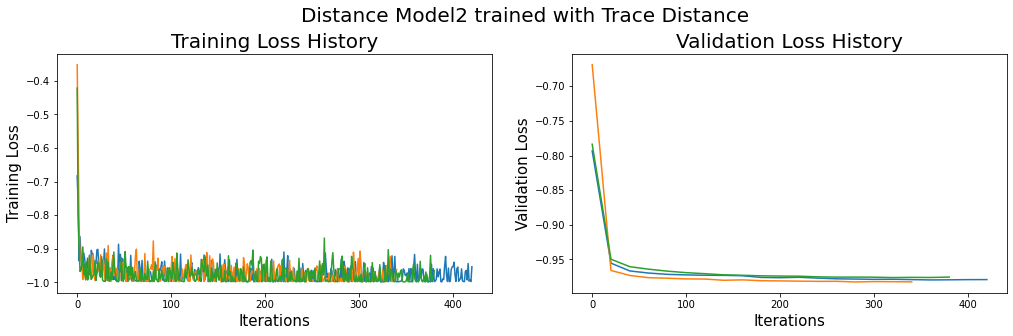

In [21]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, (ax1, ax2) = plt.subplots(1,2)
fig.tight_layout(pad=5.0)
fig.suptitle("Distance Model2 trained with Trace Distance").set_fontsize(20)
ax1.plot(range(len(loss_history1)), loss_history1, range(len(loss_history2)), loss_history2, range(len(loss_history3)), loss_history3)
ax1.set_title("Training Loss History").set_fontsize(20)
ax1.set_xlabel("Iterations").set_fontsize(15)
ax1.set_ylabel("Training Loss").set_fontsize(15)
ax2.plot(np.array(range(len(validation_loss_history1))) * 20, validation_loss_history1, np.array(range(len(validation_loss_history2))) * 20, validation_loss_history2, np.array(range(len(validation_loss_history3))) * 20, validation_loss_history3)
ax2.set_title("Validation Loss History").set_fontsize(20)
ax2.set_xlabel("Iterations").set_fontsize(15)
ax2.set_ylabel("Validation Loss").set_fontsize(15)

print(f"Trace Distance of Test dataset (Experiment1): {Test_loss1 * -1}\n")
print(f"Trace Distance of Test dataset (Experiment2): {Test_loss2 * -1}\n")
print(f"Trace Distance of Test dataset (Experiment3): {Test_loss3 * -1}\n")

# 2.8. Distance Model2 with Hilbert-Schmidt Distance

In [22]:
loss_history1 = np.array([-0.06478387117385864, -0.07919085025787354, -0.15626780688762665, -0.20907407999038696, -0.21809101104736328, -0.2273031771183014, -0.25842249393463135, -0.3311956524848938, -0.2763577699661255, -0.3217118978500366, -0.3723877966403961, -0.39519262313842773, -0.3770314157009125, -0.36550280451774597, -0.37159159779548645, -0.37159261107444763, -0.3702244758605957, -0.42694443464279175, -0.3683179020881653, -0.43519192934036255, -0.4192143678665161, -0.38072025775909424, -0.37525874376296997, -0.3700233995914459, -0.44770127534866333, -0.4174607992172241, -0.46055108308792114, -0.49742627143859863, -0.38154006004333496, -0.5372611284255981, -0.433505654335022, -0.4852032959461212, -0.434012770652771, -0.40978944301605225, -0.456298828125, -0.4490874707698822, -0.575198769569397, -0.4645557105541229, -0.5038631558418274, -0.47484540939331055, -0.5545700788497925, -0.5397047400474548, -0.5508406162261963, -0.48591747879981995, -0.6335841417312622, -0.44245752692222595, -0.6712613701820374, -0.5641945004463196, -0.6455862522125244, -0.6066006422042847, -0.5309675931930542, -0.7135723829269409, -0.36923956871032715, -0.6641775369644165, -0.6358122825622559, -0.5884534120559692, -0.6071606874465942, -0.4980877637863159, -0.6900254487991333, -0.6374812126159668, -0.5969792604446411, -0.6694115400314331, -0.5353292226791382, -0.7176999449729919, -0.7818342447280884, -0.5769585967063904, -0.7980787754058838, -0.7646234035491943, -0.49316415190696716, -0.7959743738174438, -0.6944729685783386, -0.6749374866485596, -0.5918219089508057, -0.6235365867614746, -0.5815210342407227, -0.7914183139801025, -0.7316015958786011, -0.7179465293884277, -0.58539879322052, -0.6694871187210083, -0.6339622735977173, -0.6713505983352661, -0.80460524559021, -0.6181759238243103, -0.5786795616149902, -0.6866591572761536, -0.6571944952011108, -0.6773083209991455, -0.6368728876113892, -0.6652193069458008, -0.6667520999908447, -0.5788812041282654, -0.8025850057601929, -0.6881440877914429, -0.6677103638648987, -0.7273494005203247, -0.591376006603241, -0.7182043790817261, -0.6495909690856934, -0.5708340406417847, -0.6425362825393677, -0.7729640007019043, -0.6358318328857422, -0.7823288440704346, -0.6485537886619568, -0.6675517559051514, -0.690088152885437, -0.7733715772628784, -0.7903065085411072, -0.6633951663970947, -0.5750771164894104, -0.8343400955200195, -0.797509491443634, -0.7576770782470703, -0.5586297512054443, -0.7947889566421509, -0.7224496603012085, -0.7687090635299683, -0.6978261470794678, -0.7195088863372803, -0.7147424817085266, -0.8000791072845459, -0.7910501956939697, -0.6222209334373474, -0.7804723978042603, -0.7123770713806152, -0.5720654726028442, -0.7116936445236206, -0.748321533203125, -0.6076241731643677, -0.7036501169204712, -0.6281861662864685, -0.6380202770233154, -0.7473030090332031, -0.7740147709846497, -0.6096668243408203, -0.7202060222625732, -0.7036938071250916, -0.6755726337432861, -0.5957834124565125, -0.8188367486000061, -0.7087938785552979, -0.7048760652542114, -0.7624057531356812, -0.6734695434570312, -0.7654998302459717, -0.7255988121032715, -0.8140150308609009, -0.7421494722366333, -0.666974663734436, -0.6789425611495972, -0.7614347338676453, -0.6585139036178589, -0.6573085188865662, -0.7635664939880371, -0.7164252996444702, -0.7144471406936646, -0.7021536827087402, -0.663832426071167, -0.6781383752822876, -0.7555652260780334, -0.731205940246582, -0.7146801948547363, -0.7252205610275269, -0.6457861661911011, -0.8022305369377136, -0.7727593183517456, -0.6906262636184692, -0.5029958486557007, -0.837533712387085, -0.79690021276474, -0.769150972366333, -0.6400051712989807, -0.6272526979446411, -0.6593103408813477, -0.7949461340904236, -0.7158163189888, -0.7623047828674316, -0.6969780325889587, -0.7682063579559326, -0.6325891017913818, -0.6798723936080933, -0.7817792296409607, -0.6555452346801758, -0.6755893230438232, -0.7502585649490356, -0.5695269107818604, -0.7725732326507568, -0.6919426321983337, -0.7993987798690796, -0.625224769115448, -0.8072834014892578, -0.7591184377670288, -0.6301020383834839, -0.6048523783683777, -0.7717081308364868, -0.8267650604248047, -0.7210384607315063, -0.6380166411399841, -0.8078271746635437, -0.7877561450004578, -0.7177460193634033, -0.6958125829696655, -0.7537474632263184, -0.6075938940048218, -0.7850444912910461, -0.843852698802948, -0.7418075799942017, -0.6917285919189453, -0.6784551739692688, -0.7184966802597046, -0.7374579906463623, -0.7662910223007202, -0.7294702529907227, -0.7076939940452576, -0.7893186807632446, -0.7183424234390259, -0.6821633577346802, -0.8106632232666016, -0.6414668560028076, -0.7682583332061768, -0.7889539003372192, -0.6120527982711792, -0.7800763845443726, -0.6847345232963562, -0.7598584890365601, -0.737183153629303, -0.7230433225631714, -0.7725001573562622, -0.7653948068618774, -0.7470215559005737, -0.7864192724227905, -0.6732678413391113, -0.6809824705123901, -0.8414628505706787, -0.8023266196250916, -0.7136826515197754, -0.6392496228218079, -0.7704131007194519, -0.8019014596939087, -0.6799522638320923])
loss_history2 = np.array([-0.08920525014400482, -0.18471777439117432, -0.20492859184741974, -0.3234937787055969, -0.2786557376384735, -0.3811865448951721, -0.36868250370025635, -0.44051918387413025, -0.46730688214302063, -0.4542596638202667, -0.40228894352912903, -0.44676336646080017, -0.41317474842071533, -0.3546870946884155, -0.40207189321517944, -0.5103224515914917, -0.4108012318611145, -0.450688898563385, -0.459134042263031, -0.4760037064552307, -0.36825600266456604, -0.4128389358520508, -0.5382205843925476, -0.4110773205757141, -0.47672024369239807, -0.4485049247741699, -0.5213003158569336, -0.45735228061676025, -0.5934963226318359, -0.3911844491958618, -0.6380196213722229, -0.6292225122451782, -0.47545531392097473, -0.559457540512085, -0.5568963289260864, -0.47848910093307495, -0.5084288716316223, -0.503129243850708, -0.6061426997184753, -0.5561179518699646, -0.5569129586219788, -0.42394334077835083, -0.6095185875892639, -0.42195838689804077, -0.6039271950721741, -0.5159432291984558, -0.5175125598907471, -0.6250349283218384, -0.6611064076423645, -0.5432319045066833, -0.669340968132019, -0.6545376777648926, -0.5789565443992615, -0.7643587589263916, -0.6317409873008728, -0.6114381551742554, -0.7785204648971558, -0.6258652210235596, -0.8010884523391724, -0.549113929271698, -0.8606708645820618, -0.6879067420959473, -0.7247879505157471, -0.4675945043563843, -0.856735348701477, -0.5820665955543518, -0.6866489052772522, -0.7783703804016113, -0.5633541345596313, -0.6494107246398926, -0.6773889660835266, -0.4899480938911438, -0.7837977409362793, -0.8295621871948242, -0.5902618169784546, -0.8885229825973511, -0.6084909439086914, -0.6399470567703247, -0.6552934050559998, -0.692231297492981, -0.6960858106613159, -0.6927157640457153, -0.814489483833313, -0.5147268176078796, -0.7539872527122498, -0.8452221751213074, -0.6365821957588196, -0.7611887454986572, -0.8429926633834839, -0.5796582698822021, -0.7398841381072998, -0.7800511121749878, -0.6283941268920898, -0.8957468867301941, -0.7290156483650208, -0.7386718392372131, -0.6771959662437439, -0.7837816476821899, -0.5946528911590576, -0.8701978921890259, -0.6952612996101379, -0.7188459038734436, -0.7043465375900269, -0.750507116317749, -0.6539413928985596, -0.7883796095848083, -0.5367226600646973, -0.7533541917800903, -0.7283256649971008, -0.6658462285995483, -0.6871129274368286, -0.7872957587242126, -0.7960559129714966, -0.710462749004364, -0.6124526858329773, -0.6610826253890991, -0.7897648215293884, -0.7016259431838989, -0.728031575679779, -0.6720809936523438, -0.837383508682251, -0.6687600016593933, -0.8385426998138428, -0.5876217484474182, -0.8170511722564697, -0.6197121739387512, -0.7521854043006897, -0.8232607245445251, -0.8618514537811279, -0.6587503552436829, -0.7492175102233887, -0.7328746914863586, -0.5839215517044067, -0.7991616725921631, -0.748627781867981, -0.6629855632781982, -0.7532238364219666, -0.6604851484298706, -0.675981342792511, -0.8427999019622803, -0.7985424995422363, -0.7821775078773499, -0.6613277196884155, -0.8078513145446777, -0.7680652141571045, -0.7515783309936523, -0.6212881803512573, -0.7550821900367737, -0.7267894744873047, -0.599673867225647, -0.883931040763855, -0.7534141540527344, -0.7066395282745361, -0.6991717219352722, -0.7603937387466431, -0.8041566014289856, -0.5575687885284424, -0.7543108463287354, -0.7495437860488892, -0.6635035872459412, -0.64414381980896, -0.8315919041633606, -0.765296220779419, -0.6527036428451538, -0.7834513187408447, -0.8276602029800415, -0.7622030973434448, -0.7088852524757385, -0.7374782562255859, -0.7873826026916504, -0.7531228065490723, -0.6045252680778503, -0.7852925062179565, -0.7775636911392212, -0.6126952171325684, -0.8647581934928894, -0.7625892162322998, -0.7094610929489136, -0.8159111142158508, -0.786946177482605, -0.6856657266616821, -0.6841628551483154, -0.8357395529747009, -0.7342483401298523, -0.7924404144287109, -0.7253072261810303, -0.6751539707183838, -0.8384622931480408, -0.7445611953735352, -0.5467222929000854, -0.9213460683822632, -0.8774826526641846, -0.8043485879898071, -0.8732610940933228, -0.6992248892784119, -0.7754493355751038, -0.7572032809257507, -0.7512587904930115, -0.785148561000824, -0.700649082660675, -0.8499928712844849, -0.7193654179573059, -0.7950112819671631, -0.7040970325469971, -0.790906548500061, -0.8227737545967102, -0.5011693239212036, -0.8893750905990601, -0.7875608205795288, -0.6001232862472534, -0.9131729602813721, -0.8109667301177979, -0.8104349374771118, -0.6584428548812866, -0.8548138737678528, -0.7600815296173096, -0.8340845108032227, -0.6963613629341125, -0.9059604406356812, -0.8129360675811768, -0.6919838786125183])
loss_history3 = np.array([-0.10640609264373779, -0.19045166671276093, -0.241219162940979, -0.24304886162281036, -0.35020193457603455, -0.2935103476047516, -0.32414481043815613, -0.388778418302536, -0.4053787589073181, -0.3941439986228943, -0.4359644651412964, -0.5326147675514221, -0.5529202818870544, -0.5390462875366211, -0.4429468512535095, -0.5517902374267578, -0.42315730452537537, -0.5680448412895203, -0.4652807414531708, -0.5078889727592468, -0.5700868368148804, -0.4954667389392853, -0.6368206739425659, -0.5738922953605652, -0.3692168593406677, -0.4844313859939575, -0.6219980716705322, -0.4429174065589905, -0.6899101734161377, -0.6013783812522888, -0.46215999126434326, -0.6450287103652954, -0.7624366879463196, -0.687312126159668, -0.4822595417499542, -0.5350335836410522, -0.4566369652748108, -0.5203841328620911, -0.5937078595161438, -0.46514400839805603, -0.6273298263549805, -0.5170776844024658, -0.66790771484375, -0.7665638327598572, -0.6749140620231628, -0.49722781777381897, -0.6159089803695679, -0.7261011004447937, -0.6243418455123901, -0.618493914604187, -0.5917955040931702, -0.6802587509155273, -0.5881037712097168, -0.6627488732337952, -0.7123882174491882, -0.6515052318572998, -0.6475534439086914, -0.56831294298172, -0.544635534286499, -0.7467966675758362, -0.8589815497398376, -0.6710186004638672, -0.7385018467903137, -0.8176490068435669, -0.789998471736908, -0.5230318307876587, -0.735700249671936, -0.6811389923095703, -0.48541516065597534, -0.5603220462799072, -0.7822026610374451, -0.6489655375480652, -0.6697449684143066, -0.4355289936065674, -0.6487358212471008, -0.7799646854400635, -0.7183691263198853, -0.7488129734992981, -0.7636090517044067, -0.8056238889694214, -0.5507062077522278, -0.6068195104598999, -0.7737860083580017, -0.5916221141815186, -0.6233978867530823, -0.8155861496925354, -0.6283369064331055, -0.6681849956512451, -0.8455989360809326, -0.6716480255126953, -0.8731604814529419, -0.7417358160018921, -0.6249411106109619, -0.5577208995819092, -0.7524350881576538, -0.7753679752349854, -0.6815426349639893, -0.5889495015144348, -0.7272917628288269, -0.8494770526885986, -0.8056386113166809, -0.843846321105957, -0.7309434413909912, -0.6636915802955627, -0.741066575050354, -0.7182751893997192, -0.6750872135162354, -0.7371710538864136, -0.8303525447845459, -0.603626549243927, -0.6881169080734253, -0.7701832056045532, -0.8941096067428589, -0.6687638163566589, -0.6505236625671387, -0.7244447469711304, -0.8797787427902222, -0.7862036228179932, -0.7864640951156616, -0.6037548184394836, -0.7277624607086182, -0.6785790324211121, -0.596349835395813, -0.7772222757339478, -0.8808674812316895, -0.7874219417572021, -0.7483636140823364, -0.5683834552764893, -0.70100998878479, -0.8538740873336792, -0.6450172662734985, -0.8376710414886475, -0.8327143788337708, -0.575545072555542, -0.7785122990608215, -0.6862649917602539, -0.689439058303833, -0.7797108888626099, -0.7787672281265259, -0.8167141675949097, -0.778471827507019, -0.6340236663818359, -0.6959246397018433, -0.8199701309204102, -0.9031661748886108, -0.7429683208465576, -0.6731867790222168, -0.7616864442825317, -0.6803197264671326, -0.7142560482025146, -0.7117295265197754, -0.7444618344306946, -0.7141782641410828, -0.7710390090942383, -0.9292868971824646, -0.9447199106216431, -0.8413697481155396, -0.7686488032341003, -0.8051327466964722, -0.7249782085418701, -0.7048705220222473])

validation_loss_history1 = np.array([-0.14443542063236237, -0.4177446961402893, -0.5653027892112732, -0.6313847303390503, -0.5980824828147888, -0.7417118549346924, -0.7508537769317627, -0.7052974700927734, -0.7190512418746948, -0.751223087310791, -0.7345302104949951, -0.747085690498352, -0.7311123609542847])
validation_loss_history2 = np.array([-0.19376978278160095, -0.5314903259277344, -0.4541820287704468, -0.7041336297988892, -0.6743033528327942, -0.6609054803848267, -0.7429015040397644, -0.7380927205085754, -0.8130955696105957, -0.7406476736068726, -0.7409961223602295, -0.78452467918396])
validation_loss_history3 = np.array([-0.214525043964386, -0.4505290985107422, -0.6172794699668884, -0.6165752410888672, -0.6950369477272034, -0.7813552618026733, -0.6675912737846375, -0.6054282784461975, -0.7802492380142212])

Test_loss1 = -0.7245543003082275
Test_loss2 = -0.7798422574996948
Test_loss3 = -0.7701345086097717

## Data Plot

HS Distance of Test dataset (Experiment1): 0.7245543003082275

HS Distance of Test dataset (Experiment2): 0.7798422574996948

HS Distance of Test dataset (Experiment3): 0.7701345086097717



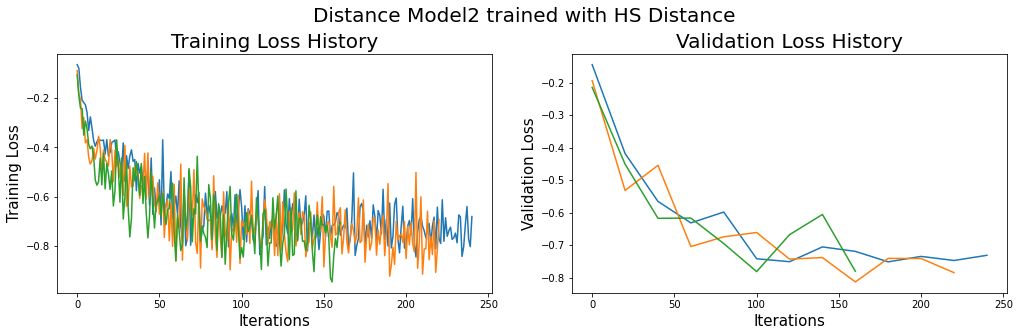

In [23]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, (ax1, ax2) = plt.subplots(1,2)
fig.tight_layout(pad=5.0)
fig.suptitle("Distance Model2 trained with HS Distance").set_fontsize(20)
ax1.plot(range(len(loss_history1)), loss_history1, range(len(loss_history2)), loss_history2, range(len(loss_history3)), loss_history3)
ax1.set_title("Training Loss History").set_fontsize(20)
ax1.set_xlabel("Iterations").set_fontsize(15)
ax1.set_ylabel("Training Loss").set_fontsize(15)
ax2.plot(np.array(range(len(validation_loss_history1))) * 20, validation_loss_history1, np.array(range(len(validation_loss_history2))) * 20, validation_loss_history2, np.array(range(len(validation_loss_history3))) * 20, validation_loss_history3)
ax2.set_title("Validation Loss History").set_fontsize(20)
ax2.set_xlabel("Iterations").set_fontsize(15)
ax2.set_ylabel("Validation Loss").set_fontsize(15)

print(f"HS Distance of Test dataset (Experiment1): {Test_loss1 * -1}\n")
print(f"HS Distance of Test dataset (Experiment2): {Test_loss2 * -1}\n")
print(f"HS Distance of Test dataset (Experiment3): {Test_loss3 * -1}\n")

# 3. Fashion MNIST Dataset

In [42]:
feature_reduction = 'PCA8'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('fashion', '2', feature_reduction=feature_reduction, classes=classes)
X1_test, X0_test = [], []
for i in range(len(X_test)):
    if Y_test[i] == 1:
        X1_test.append(X_test[i])
    else:
        X0_test.append(X_test[i])
X1_test, X0_test = torch.tensor(X1_test), torch.tensor(X0_test)

UnboundLocalError: local variable 'x_train' referenced before assignment